In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='physicalDist_gradientExp'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=1024
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
clf=None
adv=None  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'
protein=None #'scaled_binary'
proteinWeights=0.05
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']
# training_samples=['control13','control8']
targetBatch=None
training_sample_X='logminmax'
switchFreq=10
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allphygradientExpXA_01_dca'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in sampleidx.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
            
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
            features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(19990)+'.pt')))
# epochs=40000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        modelAdv.eval()
        advOut=modelAdv(z)
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    if 'dca' in model_str:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
#     loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        advOut=modelAdv(z)
    if 'dca' in model_str:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    loss_val = loss_x_val+loss_a_val
#     loss_val=loss_x_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val)        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()
for ep in range(epochs):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 21.7918 loss_kl_train: 0.0009 loss_x_train: 7.7451 loss_a_train: 14.0459 loss_val: 9.8527 loss_x_val: 7.6636 loss_a_val: 2.1891 time: 0.8326s
control13 Epoch: 0001 loss_train: 19.5198 loss_kl_train: 0.0002 loss_x_train: 6.4262 loss_a_train: 13.0934 loss_val: 9.6741 loss_x_val: 7.6080 loss_a_val: 2.0661 time: 0.5235s
control13 Epoch: 0002 loss_train: 18.3134 loss_kl_train: 0.0002 loss_x_train: 5.3883 loss_a_train: 12.9249 loss_val: 9.8036 loss_x_val: 7.5168 loss_a_val: 2.2868 time: 0.5231s
control13 Epoch: 0003 loss_train: 17.3194 loss_kl_train: 0.0003 loss_x_train: 4.5854 loss_a_train: 12.7337 loss_val: 10.4232 loss_x_val: 7.3924 loss_a_val: 3.0308 time: 0.5247s
control13 Epoch: 0004 loss_train: 16.2973 loss_kl_train: 0.0005 loss_x_train: 3.9801 loss_a_train: 12.3168 loss_val: 10.3341 loss_x_val: 7.3176 loss_a_val: 3.0165 time: 0.5205s
control13 Epoch: 0005 loss_train: 15.5214 loss_kl_train: 0.0005 loss_x_train: 3.5282 loss_a_train: 11.9927 loss_val: 1

control13 Epoch: 0047 loss_train: 10.0146 loss_kl_train: 0.0038 loss_x_train: 1.5632 loss_a_train: 8.4476 loss_val: 8.5130 loss_x_val: 5.1541 loss_a_val: 3.3588 time: 0.5264s
control13 Epoch: 0048 loss_train: 9.6622 loss_kl_train: 0.0040 loss_x_train: 1.5569 loss_a_train: 8.1013 loss_val: 8.2770 loss_x_val: 5.1896 loss_a_val: 3.0873 time: 0.5254s
control13 Epoch: 0049 loss_train: 9.7055 loss_kl_train: 0.0042 loss_x_train: 1.5511 loss_a_train: 8.1503 loss_val: 8.4069 loss_x_val: 5.1859 loss_a_val: 3.2211 time: 0.5313s
disease13 Epoch: 0050 loss_train: 9.7322 loss_kl_train: 0.0042 loss_x_train: 1.7005 loss_a_train: 8.0275 loss_val: 9.3287 loss_x_val: 5.3302 loss_a_val: 3.9986 time: 0.7658s
disease13 Epoch: 0051 loss_train: 9.3084 loss_kl_train: 0.0046 loss_x_train: 1.6940 loss_a_train: 7.6098 loss_val: 9.3686 loss_x_val: 5.1732 loss_a_val: 4.1954 time: 0.7589s
disease13 Epoch: 0052 loss_train: 9.2504 loss_kl_train: 0.0052 loss_x_train: 1.6879 loss_a_train: 7.5573 loss_val: 8.8522 loss_x_

disease13 Epoch: 0095 loss_train: 4.4123 loss_kl_train: 0.0570 loss_x_train: 1.5693 loss_a_train: 2.7859 loss_val: 4.9420 loss_x_val: 2.7433 loss_a_val: 2.1987 time: 0.7611s
disease13 Epoch: 0096 loss_train: 4.3431 loss_kl_train: 0.0583 loss_x_train: 1.5678 loss_a_train: 2.7171 loss_val: 4.9093 loss_x_val: 2.7019 loss_a_val: 2.2074 time: 0.7577s
disease13 Epoch: 0097 loss_train: 4.3665 loss_kl_train: 0.0595 loss_x_train: 1.5659 loss_a_train: 2.7410 loss_val: 5.1347 loss_x_val: 2.6264 loss_a_val: 2.5084 time: 0.7673s
disease13 Epoch: 0098 loss_train: 4.5730 loss_kl_train: 0.0608 loss_x_train: 1.5648 loss_a_train: 2.9474 loss_val: 4.8828 loss_x_val: 2.6519 loss_a_val: 2.2309 time: 0.7673s
disease13 Epoch: 0099 loss_train: 4.2099 loss_kl_train: 0.0617 loss_x_train: 1.5629 loss_a_train: 2.5854 loss_val: 5.2214 loss_x_val: 2.6205 loss_a_val: 2.6010 time: 0.7647s
disease8 Epoch: 0100 loss_train: 4.5856 loss_kl_train: 0.0716 loss_x_train: 1.3708 loss_a_train: 3.1432 loss_val: 5.9212 loss_x_va

disease8 Epoch: 0143 loss_train: 3.7297 loss_kl_train: 0.1006 loss_x_train: 1.3332 loss_a_train: 2.2959 loss_val: 5.7708 loss_x_val: 2.9292 loss_a_val: 2.8416 time: 0.4418s
disease8 Epoch: 0144 loss_train: 3.5793 loss_kl_train: 0.1009 loss_x_train: 1.3335 loss_a_train: 2.1448 loss_val: 5.6501 loss_x_val: 2.8317 loss_a_val: 2.8185 time: 0.4414s
disease8 Epoch: 0145 loss_train: 3.5824 loss_kl_train: 0.1015 loss_x_train: 1.3328 loss_a_train: 2.1481 loss_val: 5.6655 loss_x_val: 2.7988 loss_a_val: 2.8667 time: 0.4414s
disease8 Epoch: 0146 loss_train: 3.5336 loss_kl_train: 0.1021 loss_x_train: 1.3315 loss_a_train: 2.1000 loss_val: 5.6451 loss_x_val: 2.7505 loss_a_val: 2.8946 time: 0.4410s
disease8 Epoch: 0147 loss_train: 3.5501 loss_kl_train: 0.1027 loss_x_train: 1.3320 loss_a_train: 2.1154 loss_val: 5.6156 loss_x_val: 2.7148 loss_a_val: 2.9009 time: 0.4444s
disease8 Epoch: 0148 loss_train: 3.5151 loss_kl_train: 0.1034 loss_x_train: 1.3312 loss_a_train: 2.0805 loss_val: 5.5491 loss_x_val: 2.

control8 Epoch: 0191 loss_train: 3.0079 loss_kl_train: 0.1357 loss_x_train: 1.4556 loss_a_train: 1.4166 loss_val: 5.8797 loss_x_val: 2.1615 loss_a_val: 3.7182 time: 0.5109s
control8 Epoch: 0192 loss_train: 3.0278 loss_kl_train: 0.1365 loss_x_train: 1.4555 loss_a_train: 1.4357 loss_val: 5.5041 loss_x_val: 2.1289 loss_a_val: 3.3752 time: 0.5096s
control8 Epoch: 0193 loss_train: 3.0150 loss_kl_train: 0.1374 loss_x_train: 1.4550 loss_a_train: 1.4227 loss_val: 5.8140 loss_x_val: 2.1386 loss_a_val: 3.6755 time: 0.5128s
control8 Epoch: 0194 loss_train: 2.9837 loss_kl_train: 0.1381 loss_x_train: 1.4544 loss_a_train: 1.3911 loss_val: 5.6314 loss_x_val: 2.1255 loss_a_val: 3.5059 time: 0.5101s
control8 Epoch: 0195 loss_train: 3.0462 loss_kl_train: 0.1390 loss_x_train: 1.4547 loss_a_train: 1.4526 loss_val: 6.0949 loss_x_val: 2.1366 loss_a_val: 3.9583 time: 0.5119s
control8 Epoch: 0196 loss_train: 2.9715 loss_kl_train: 0.1396 loss_x_train: 1.4541 loss_a_train: 1.3778 loss_val: 5.9011 loss_x_val: 2.

control8 Epoch: 0239 loss_train: 2.5923 loss_kl_train: 0.1706 loss_x_train: 1.4432 loss_a_train: 0.9786 loss_val: 7.4685 loss_x_val: 1.8759 loss_a_val: 5.5926 time: 0.5133s
control13 Epoch: 0240 loss_train: 2.6129 loss_kl_train: 0.1591 loss_x_train: 1.3621 loss_a_train: 1.0918 loss_val: 4.9018 loss_x_val: 1.8155 loss_a_val: 3.0864 time: 0.5313s
control13 Epoch: 0241 loss_train: 2.5647 loss_kl_train: 0.1595 loss_x_train: 1.3623 loss_a_train: 1.0429 loss_val: 4.9566 loss_x_val: 1.8192 loss_a_val: 3.1374 time: 0.5348s
control13 Epoch: 0242 loss_train: 2.5791 loss_kl_train: 0.1601 loss_x_train: 1.3619 loss_a_train: 1.0572 loss_val: 4.7792 loss_x_val: 1.7931 loss_a_val: 2.9861 time: 0.5337s
control13 Epoch: 0243 loss_train: 2.5356 loss_kl_train: 0.1608 loss_x_train: 1.3606 loss_a_train: 1.0142 loss_val: 4.6805 loss_x_val: 1.7747 loss_a_val: 2.9058 time: 0.5322s
control13 Epoch: 0244 loss_train: 2.5649 loss_kl_train: 0.1616 loss_x_train: 1.3602 loss_a_train: 1.0431 loss_val: 4.7518 loss_x_va

control13 Epoch: 0287 loss_train: 2.3777 loss_kl_train: 0.1854 loss_x_train: 1.3536 loss_a_train: 0.8386 loss_val: 5.1317 loss_x_val: 1.5161 loss_a_val: 3.6155 time: 0.5347s
control13 Epoch: 0288 loss_train: 2.3660 loss_kl_train: 0.1860 loss_x_train: 1.3532 loss_a_train: 0.8268 loss_val: 4.9938 loss_x_val: 1.5108 loss_a_val: 3.4830 time: 0.5302s
control13 Epoch: 0289 loss_train: 2.3693 loss_kl_train: 0.1866 loss_x_train: 1.3528 loss_a_train: 0.8299 loss_val: 5.1162 loss_x_val: 1.5074 loss_a_val: 3.6088 time: 0.5328s
disease13 Epoch: 0290 loss_train: 2.4111 loss_kl_train: 0.1685 loss_x_train: 1.4831 loss_a_train: 0.7595 loss_val: 6.5180 loss_x_val: 1.6378 loss_a_val: 4.8802 time: 0.7715s
disease13 Epoch: 0291 loss_train: 2.4040 loss_kl_train: 0.1689 loss_x_train: 1.4838 loss_a_train: 0.7514 loss_val: 6.0715 loss_x_val: 1.6390 loss_a_val: 4.4325 time: 0.7642s
disease13 Epoch: 0292 loss_train: 2.4153 loss_kl_train: 0.1692 loss_x_train: 1.4833 loss_a_train: 0.7627 loss_val: 6.0202 loss_x_v

disease13 Epoch: 0335 loss_train: 2.3815 loss_kl_train: 0.1825 loss_x_train: 1.4758 loss_a_train: 0.7231 loss_val: 5.9861 loss_x_val: 1.5372 loss_a_val: 4.4490 time: 0.7780s
disease13 Epoch: 0336 loss_train: 2.3778 loss_kl_train: 0.1828 loss_x_train: 1.4754 loss_a_train: 0.7197 loss_val: 5.9794 loss_x_val: 1.5379 loss_a_val: 4.4415 time: 0.7656s
disease13 Epoch: 0337 loss_train: 2.3812 loss_kl_train: 0.1830 loss_x_train: 1.4753 loss_a_train: 0.7229 loss_val: 5.9130 loss_x_val: 1.5401 loss_a_val: 4.3729 time: 0.7640s
disease13 Epoch: 0338 loss_train: 2.3824 loss_kl_train: 0.1832 loss_x_train: 1.4754 loss_a_train: 0.7238 loss_val: 5.8518 loss_x_val: 1.5399 loss_a_val: 4.3120 time: 0.7690s
disease13 Epoch: 0339 loss_train: 2.3807 loss_kl_train: 0.1834 loss_x_train: 1.4751 loss_a_train: 0.7222 loss_val: 5.8560 loss_x_val: 1.5384 loss_a_val: 4.3176 time: 0.7730s
disease8 Epoch: 0340 loss_train: 2.3407 loss_kl_train: 0.2146 loss_x_train: 1.2932 loss_a_train: 0.8330 loss_val: 8.3762 loss_x_va

disease8 Epoch: 0383 loss_train: 2.2868 loss_kl_train: 0.2234 loss_x_train: 1.2873 loss_a_train: 0.7761 loss_val: 7.9413 loss_x_val: 1.2896 loss_a_val: 6.6516 time: 0.4400s
disease8 Epoch: 0384 loss_train: 2.2879 loss_kl_train: 0.2236 loss_x_train: 1.2874 loss_a_train: 0.7769 loss_val: 8.0900 loss_x_val: 1.2873 loss_a_val: 6.8028 time: 0.4424s
disease8 Epoch: 0385 loss_train: 2.2826 loss_kl_train: 0.2238 loss_x_train: 1.2873 loss_a_train: 0.7716 loss_val: 8.1160 loss_x_val: 1.2846 loss_a_val: 6.8314 time: 0.4411s
disease8 Epoch: 0386 loss_train: 2.2808 loss_kl_train: 0.2240 loss_x_train: 1.2872 loss_a_train: 0.7697 loss_val: 8.1056 loss_x_val: 1.2825 loss_a_val: 6.8231 time: 0.4452s
disease8 Epoch: 0387 loss_train: 2.2856 loss_kl_train: 0.2242 loss_x_train: 1.2869 loss_a_train: 0.7746 loss_val: 8.0629 loss_x_val: 1.2807 loss_a_val: 6.7823 time: 0.4435s
disease8 Epoch: 0388 loss_train: 2.2846 loss_kl_train: 0.2244 loss_x_train: 1.2869 loss_a_train: 0.7732 loss_val: 8.0389 loss_x_val: 1.

control8 Epoch: 0431 loss_train: 2.3712 loss_kl_train: 0.2341 loss_x_train: 1.4188 loss_a_train: 0.7183 loss_val: 8.5112 loss_x_val: 1.4451 loss_a_val: 7.0661 time: 0.5117s
control8 Epoch: 0432 loss_train: 2.3725 loss_kl_train: 0.2341 loss_x_train: 1.4185 loss_a_train: 0.7199 loss_val: 8.4059 loss_x_val: 1.4444 loss_a_val: 6.9615 time: 0.5063s
control8 Epoch: 0433 loss_train: 2.3730 loss_kl_train: 0.2342 loss_x_train: 1.4185 loss_a_train: 0.7203 loss_val: 8.3538 loss_x_val: 1.4448 loss_a_val: 6.9091 time: 0.5144s
control8 Epoch: 0434 loss_train: 2.3735 loss_kl_train: 0.2343 loss_x_train: 1.4185 loss_a_train: 0.7207 loss_val: 8.4502 loss_x_val: 1.4454 loss_a_val: 7.0048 time: 0.5172s
control8 Epoch: 0435 loss_train: 2.3658 loss_kl_train: 0.2344 loss_x_train: 1.4183 loss_a_train: 0.7131 loss_val: 8.0855 loss_x_val: 1.4463 loss_a_val: 6.6392 time: 0.5133s
control8 Epoch: 0436 loss_train: 2.3683 loss_kl_train: 0.2344 loss_x_train: 1.4183 loss_a_train: 0.7156 loss_val: 8.0807 loss_x_val: 1.

control8 Epoch: 0479 loss_train: 2.3599 loss_kl_train: 0.2364 loss_x_train: 1.4156 loss_a_train: 0.7079 loss_val: 8.1386 loss_x_val: 1.4413 loss_a_val: 6.6972 time: 0.5134s
control13 Epoch: 0480 loss_train: 2.3511 loss_kl_train: 0.2210 loss_x_train: 1.3368 loss_a_train: 0.7933 loss_val: 5.0168 loss_x_val: 1.3549 loss_a_val: 3.6619 time: 0.5311s
control13 Epoch: 0481 loss_train: 2.2922 loss_kl_train: 0.2207 loss_x_train: 1.3369 loss_a_train: 0.7345 loss_val: 5.1170 loss_x_val: 1.3549 loss_a_val: 3.7621 time: 0.5266s
control13 Epoch: 0482 loss_train: 2.3147 loss_kl_train: 0.2206 loss_x_train: 1.3370 loss_a_train: 0.7572 loss_val: 4.9670 loss_x_val: 1.3543 loss_a_val: 3.6127 time: 0.5349s
control13 Epoch: 0483 loss_train: 2.2931 loss_kl_train: 0.2206 loss_x_train: 1.3367 loss_a_train: 0.7358 loss_val: 4.7998 loss_x_val: 1.3536 loss_a_val: 3.4462 time: 0.5269s
control13 Epoch: 0484 loss_train: 2.2887 loss_kl_train: 0.2206 loss_x_train: 1.3363 loss_a_train: 0.7318 loss_val: 4.7620 loss_x_va

control13 Epoch: 0527 loss_train: 2.3125 loss_kl_train: 0.2197 loss_x_train: 1.3346 loss_a_train: 0.7582 loss_val: 4.5076 loss_x_val: 1.3456 loss_a_val: 3.1620 time: 0.5301s
control13 Epoch: 0528 loss_train: 2.3239 loss_kl_train: 0.2194 loss_x_train: 1.3346 loss_a_train: 0.7699 loss_val: 4.4577 loss_x_val: 1.3453 loss_a_val: 3.1124 time: 0.5355s
control13 Epoch: 0529 loss_train: 2.3322 loss_kl_train: 0.2192 loss_x_train: 1.3344 loss_a_train: 0.7786 loss_val: 4.4256 loss_x_val: 1.3451 loss_a_val: 3.0804 time: 0.5284s
disease13 Epoch: 0530 loss_train: 2.4334 loss_kl_train: 0.1969 loss_x_train: 1.4629 loss_a_train: 0.7737 loss_val: 5.4336 loss_x_val: 1.4703 loss_a_val: 3.9633 time: 0.7655s
disease13 Epoch: 0531 loss_train: 2.4438 loss_kl_train: 0.1968 loss_x_train: 1.4627 loss_a_train: 0.7843 loss_val: 5.1707 loss_x_val: 1.4704 loss_a_val: 3.7003 time: 0.7731s
disease13 Epoch: 0532 loss_train: 2.4484 loss_kl_train: 0.1967 loss_x_train: 1.4623 loss_a_train: 0.7895 loss_val: 4.8306 loss_x_v

disease13 Epoch: 0575 loss_train: 2.4500 loss_kl_train: 0.1935 loss_x_train: 1.4607 loss_a_train: 0.7958 loss_val: 4.9009 loss_x_val: 1.4714 loss_a_val: 3.4295 time: 0.7640s
disease13 Epoch: 0576 loss_train: 2.4498 loss_kl_train: 0.1934 loss_x_train: 1.4606 loss_a_train: 0.7959 loss_val: 4.8469 loss_x_val: 1.4713 loss_a_val: 3.3757 time: 0.7757s
disease13 Epoch: 0577 loss_train: 2.4497 loss_kl_train: 0.1932 loss_x_train: 1.4604 loss_a_train: 0.7961 loss_val: 4.8459 loss_x_val: 1.4713 loss_a_val: 3.3746 time: 0.7747s
disease13 Epoch: 0578 loss_train: 2.4505 loss_kl_train: 0.1931 loss_x_train: 1.4604 loss_a_train: 0.7970 loss_val: 4.9242 loss_x_val: 1.4712 loss_a_val: 3.4530 time: 0.7704s
disease13 Epoch: 0579 loss_train: 2.4416 loss_kl_train: 0.1928 loss_x_train: 1.4603 loss_a_train: 0.7885 loss_val: 4.9548 loss_x_val: 1.4712 loss_a_val: 3.4836 time: 0.7661s
disease8 Epoch: 0580 loss_train: 2.3430 loss_kl_train: 0.2257 loss_x_train: 1.2796 loss_a_train: 0.8377 loss_val: 7.0338 loss_x_va

disease8 Epoch: 0623 loss_train: 2.2729 loss_kl_train: 0.2246 loss_x_train: 1.2774 loss_a_train: 0.7710 loss_val: 7.6547 loss_x_val: 1.2452 loss_a_val: 6.4095 time: 0.4419s
disease8 Epoch: 0624 loss_train: 2.2704 loss_kl_train: 0.2247 loss_x_train: 1.2773 loss_a_train: 0.7684 loss_val: 7.8285 loss_x_val: 1.2451 loss_a_val: 6.5834 time: 0.4436s
disease8 Epoch: 0625 loss_train: 2.2680 loss_kl_train: 0.2247 loss_x_train: 1.2772 loss_a_train: 0.7661 loss_val: 7.8956 loss_x_val: 1.2452 loss_a_val: 6.6504 time: 0.4473s
disease8 Epoch: 0626 loss_train: 2.2724 loss_kl_train: 0.2248 loss_x_train: 1.2772 loss_a_train: 0.7704 loss_val: 7.8105 loss_x_val: 1.2453 loss_a_val: 6.5652 time: 0.4465s
disease8 Epoch: 0627 loss_train: 2.2705 loss_kl_train: 0.2249 loss_x_train: 1.2772 loss_a_train: 0.7684 loss_val: 7.6601 loss_x_val: 1.2452 loss_a_val: 6.4148 time: 0.4447s
disease8 Epoch: 0628 loss_train: 2.2676 loss_kl_train: 0.2251 loss_x_train: 1.2769 loss_a_train: 0.7656 loss_val: 7.6018 loss_x_val: 1.

control8 Epoch: 0671 loss_train: 2.3559 loss_kl_train: 0.2306 loss_x_train: 1.4099 loss_a_train: 0.7155 loss_val: 7.6850 loss_x_val: 1.4262 loss_a_val: 6.2587 time: 0.5109s
control8 Epoch: 0672 loss_train: 2.3571 loss_kl_train: 0.2306 loss_x_train: 1.4096 loss_a_train: 0.7168 loss_val: 7.9192 loss_x_val: 1.4265 loss_a_val: 6.4927 time: 0.5115s
control8 Epoch: 0673 loss_train: 2.3585 loss_kl_train: 0.2307 loss_x_train: 1.4097 loss_a_train: 0.7181 loss_val: 7.7854 loss_x_val: 1.4267 loss_a_val: 6.3587 time: 0.5129s
control8 Epoch: 0674 loss_train: 2.3536 loss_kl_train: 0.2307 loss_x_train: 1.4097 loss_a_train: 0.7132 loss_val: 7.5494 loss_x_val: 1.4268 loss_a_val: 6.1226 time: 0.5160s
control8 Epoch: 0675 loss_train: 2.3555 loss_kl_train: 0.2308 loss_x_train: 1.4096 loss_a_train: 0.7151 loss_val: 7.8611 loss_x_val: 1.4263 loss_a_val: 6.4347 time: 0.5100s
control8 Epoch: 0676 loss_train: 2.3499 loss_kl_train: 0.2308 loss_x_train: 1.4095 loss_a_train: 0.7096 loss_val: 7.7243 loss_x_val: 1.

control8 Epoch: 0719 loss_train: 2.3219 loss_kl_train: 0.2336 loss_x_train: 1.4084 loss_a_train: 0.6799 loss_val: 7.0698 loss_x_val: 1.4238 loss_a_val: 5.6459 time: 0.5118s
control13 Epoch: 0720 loss_train: 2.3415 loss_kl_train: 0.2182 loss_x_train: 1.3301 loss_a_train: 0.7933 loss_val: 4.6694 loss_x_val: 1.3399 loss_a_val: 3.3295 time: 0.5343s
control13 Epoch: 0721 loss_train: 2.2495 loss_kl_train: 0.2181 loss_x_train: 1.3298 loss_a_train: 0.7017 loss_val: 4.7596 loss_x_val: 1.3400 loss_a_val: 3.4196 time: 0.5272s
control13 Epoch: 0722 loss_train: 2.2697 loss_kl_train: 0.2179 loss_x_train: 1.3299 loss_a_train: 0.7219 loss_val: 4.7119 loss_x_val: 1.3400 loss_a_val: 3.3718 time: 0.5330s
control13 Epoch: 0723 loss_train: 2.2722 loss_kl_train: 0.2179 loss_x_train: 1.3299 loss_a_train: 0.7244 loss_val: 4.6149 loss_x_val: 1.3397 loss_a_val: 3.2752 time: 0.5268s
control13 Epoch: 0724 loss_train: 2.2574 loss_kl_train: 0.2179 loss_x_train: 1.3296 loss_a_train: 0.7100 loss_val: 4.5249 loss_x_va

control13 Epoch: 0767 loss_train: 2.2558 loss_kl_train: 0.2183 loss_x_train: 1.3289 loss_a_train: 0.7086 loss_val: 4.7098 loss_x_val: 1.3387 loss_a_val: 3.3711 time: 0.5274s
control13 Epoch: 0768 loss_train: 2.2536 loss_kl_train: 0.2184 loss_x_train: 1.3288 loss_a_train: 0.7063 loss_val: 4.3873 loss_x_val: 1.3388 loss_a_val: 3.0485 time: 0.5347s
control13 Epoch: 0769 loss_train: 2.2611 loss_kl_train: 0.2184 loss_x_train: 1.3287 loss_a_train: 0.7140 loss_val: 4.5566 loss_x_val: 1.3383 loss_a_val: 3.2182 time: 0.5277s
disease13 Epoch: 0770 loss_train: 2.3323 loss_kl_train: 0.1969 loss_x_train: 1.4560 loss_a_train: 0.6794 loss_val: 5.4264 loss_x_val: 1.4632 loss_a_val: 3.9631 time: 0.7658s
disease13 Epoch: 0771 loss_train: 2.3294 loss_kl_train: 0.1970 loss_x_train: 1.4560 loss_a_train: 0.6764 loss_val: 5.4444 loss_x_val: 1.4630 loss_a_val: 3.9814 time: 0.7772s
disease13 Epoch: 0772 loss_train: 2.3316 loss_kl_train: 0.1970 loss_x_train: 1.4560 loss_a_train: 0.6786 loss_val: 5.2015 loss_x_v

disease13 Epoch: 0815 loss_train: 2.2783 loss_kl_train: 0.1968 loss_x_train: 1.4548 loss_a_train: 0.6266 loss_val: 5.6753 loss_x_val: 1.4621 loss_a_val: 4.2132 time: 0.7688s
disease13 Epoch: 0816 loss_train: 2.2782 loss_kl_train: 0.1969 loss_x_train: 1.4548 loss_a_train: 0.6266 loss_val: 5.5977 loss_x_val: 1.4619 loss_a_val: 4.1358 time: 0.7732s
disease13 Epoch: 0817 loss_train: 2.2761 loss_kl_train: 0.1968 loss_x_train: 1.4546 loss_a_train: 0.6247 loss_val: 5.5121 loss_x_val: 1.4617 loss_a_val: 4.0504 time: 0.7778s
disease13 Epoch: 0818 loss_train: 2.2735 loss_kl_train: 0.1968 loss_x_train: 1.4545 loss_a_train: 0.6222 loss_val: 5.5273 loss_x_val: 1.4615 loss_a_val: 4.0658 time: 0.7743s
disease13 Epoch: 0819 loss_train: 2.2715 loss_kl_train: 0.1967 loss_x_train: 1.4544 loss_a_train: 0.6203 loss_val: 5.6259 loss_x_val: 1.4614 loss_a_val: 4.1646 time: 0.7712s
disease8 Epoch: 0820 loss_train: 2.2020 loss_kl_train: 0.2309 loss_x_train: 1.2743 loss_a_train: 0.6968 loss_val: 8.3704 loss_x_va

disease8 Epoch: 0863 loss_train: 2.2138 loss_kl_train: 0.2322 loss_x_train: 1.2729 loss_a_train: 0.7087 loss_val: 7.7196 loss_x_val: 1.2368 loss_a_val: 6.4828 time: 0.4410s
disease8 Epoch: 0864 loss_train: 2.1896 loss_kl_train: 0.2322 loss_x_train: 1.2728 loss_a_train: 0.6847 loss_val: 7.6761 loss_x_val: 1.2368 loss_a_val: 6.4393 time: 0.4423s
disease8 Epoch: 0865 loss_train: 2.1958 loss_kl_train: 0.2322 loss_x_train: 1.2726 loss_a_train: 0.6910 loss_val: 7.6624 loss_x_val: 1.2371 loss_a_val: 6.4253 time: 0.4441s
disease8 Epoch: 0866 loss_train: 2.1974 loss_kl_train: 0.2323 loss_x_train: 1.2726 loss_a_train: 0.6926 loss_val: 7.5358 loss_x_val: 1.2373 loss_a_val: 6.2985 time: 0.4429s
disease8 Epoch: 0867 loss_train: 2.2001 loss_kl_train: 0.2324 loss_x_train: 1.2725 loss_a_train: 0.6951 loss_val: 7.4859 loss_x_val: 1.2373 loss_a_val: 6.2485 time: 0.4407s
disease8 Epoch: 0868 loss_train: 2.2003 loss_kl_train: 0.2325 loss_x_train: 1.2724 loss_a_train: 0.6953 loss_val: 7.4110 loss_x_val: 1.

control8 Epoch: 0911 loss_train: 2.3120 loss_kl_train: 0.2346 loss_x_train: 1.4049 loss_a_train: 0.6724 loss_val: 7.0339 loss_x_val: 1.4195 loss_a_val: 5.6145 time: 0.5102s
control8 Epoch: 0912 loss_train: 2.3047 loss_kl_train: 0.2345 loss_x_train: 1.4047 loss_a_train: 0.6655 loss_val: 7.3362 loss_x_val: 1.4199 loss_a_val: 5.9163 time: 0.5140s
control8 Epoch: 0913 loss_train: 2.3040 loss_kl_train: 0.2346 loss_x_train: 1.4049 loss_a_train: 0.6645 loss_val: 7.6203 loss_x_val: 1.4199 loss_a_val: 6.2004 time: 0.5104s
control8 Epoch: 0914 loss_train: 2.3070 loss_kl_train: 0.2344 loss_x_train: 1.4050 loss_a_train: 0.6676 loss_val: 7.4969 loss_x_val: 1.4197 loss_a_val: 6.0771 time: 0.5136s
control8 Epoch: 0915 loss_train: 2.3080 loss_kl_train: 0.2344 loss_x_train: 1.4048 loss_a_train: 0.6688 loss_val: 7.1975 loss_x_val: 1.4195 loss_a_val: 5.7780 time: 0.5152s
control8 Epoch: 0916 loss_train: 2.3019 loss_kl_train: 0.2344 loss_x_train: 1.4047 loss_a_train: 0.6628 loss_val: 7.3850 loss_x_val: 1.

control8 Epoch: 0959 loss_train: 2.2734 loss_kl_train: 0.2341 loss_x_train: 1.4039 loss_a_train: 0.6354 loss_val: 7.3029 loss_x_val: 1.4184 loss_a_val: 5.8845 time: 0.5147s
control13 Epoch: 0960 loss_train: 2.2427 loss_kl_train: 0.2186 loss_x_train: 1.3261 loss_a_train: 0.6979 loss_val: 4.5902 loss_x_val: 1.3350 loss_a_val: 3.2552 time: 0.5285s
control13 Epoch: 0961 loss_train: 2.2085 loss_kl_train: 0.2184 loss_x_train: 1.3258 loss_a_train: 0.6643 loss_val: 4.7231 loss_x_val: 1.3352 loss_a_val: 3.3878 time: 0.5293s
control13 Epoch: 0962 loss_train: 2.2145 loss_kl_train: 0.2182 loss_x_train: 1.3259 loss_a_train: 0.6703 loss_val: 4.8008 loss_x_val: 1.3354 loss_a_val: 3.4653 time: 0.5369s
control13 Epoch: 0963 loss_train: 2.2224 loss_kl_train: 0.2182 loss_x_train: 1.3260 loss_a_train: 0.6782 loss_val: 4.6391 loss_x_val: 1.3352 loss_a_val: 3.3038 time: 0.5306s
control13 Epoch: 0964 loss_train: 2.2099 loss_kl_train: 0.2182 loss_x_train: 1.3258 loss_a_train: 0.6660 loss_val: 4.5067 loss_x_va

control13 Epoch: 1007 loss_train: 2.1950 loss_kl_train: 0.2200 loss_x_train: 1.3250 loss_a_train: 0.6499 loss_val: 4.6088 loss_x_val: 1.3343 loss_a_val: 3.2744 time: 0.5289s
control13 Epoch: 1008 loss_train: 2.1943 loss_kl_train: 0.2202 loss_x_train: 1.3250 loss_a_train: 0.6491 loss_val: 4.6069 loss_x_val: 1.3343 loss_a_val: 3.2726 time: 0.5354s
control13 Epoch: 1009 loss_train: 2.1952 loss_kl_train: 0.2203 loss_x_train: 1.3250 loss_a_train: 0.6499 loss_val: 4.6515 loss_x_val: 1.3343 loss_a_val: 3.3172 time: 0.5316s
disease13 Epoch: 1010 loss_train: 2.2668 loss_kl_train: 0.1991 loss_x_train: 1.4523 loss_a_train: 0.6154 loss_val: 5.4312 loss_x_val: 1.4587 loss_a_val: 3.9725 time: 0.7688s
disease13 Epoch: 1011 loss_train: 2.2634 loss_kl_train: 0.1991 loss_x_train: 1.4521 loss_a_train: 0.6122 loss_val: 5.3150 loss_x_val: 1.4588 loss_a_val: 3.8563 time: 0.7706s
disease13 Epoch: 1012 loss_train: 2.2643 loss_kl_train: 0.1992 loss_x_train: 1.4522 loss_a_train: 0.6128 loss_val: 4.8725 loss_x_v

disease13 Epoch: 1055 loss_train: 2.2432 loss_kl_train: 0.1992 loss_x_train: 1.4513 loss_a_train: 0.5928 loss_val: 5.2606 loss_x_val: 1.4579 loss_a_val: 3.8027 time: 0.7709s
disease13 Epoch: 1056 loss_train: 2.2427 loss_kl_train: 0.1992 loss_x_train: 1.4513 loss_a_train: 0.5922 loss_val: 5.0939 loss_x_val: 1.4577 loss_a_val: 3.6362 time: 0.7659s
disease13 Epoch: 1057 loss_train: 2.2382 loss_kl_train: 0.1991 loss_x_train: 1.4511 loss_a_train: 0.5881 loss_val: 5.1820 loss_x_val: 1.4575 loss_a_val: 3.7245 time: 0.7696s
disease13 Epoch: 1058 loss_train: 2.2360 loss_kl_train: 0.1990 loss_x_train: 1.4510 loss_a_train: 0.5860 loss_val: 5.2533 loss_x_val: 1.4574 loss_a_val: 3.7958 time: 0.7806s
disease13 Epoch: 1059 loss_train: 2.2355 loss_kl_train: 0.1989 loss_x_train: 1.4510 loss_a_train: 0.5856 loss_val: 5.1985 loss_x_val: 1.4574 loss_a_val: 3.7411 time: 0.7795s
disease8 Epoch: 1060 loss_train: 2.1733 loss_kl_train: 0.2333 loss_x_train: 1.2709 loss_a_train: 0.6691 loss_val: 7.6583 loss_x_va

disease8 Epoch: 1103 loss_train: 2.1878 loss_kl_train: 0.2332 loss_x_train: 1.2702 loss_a_train: 0.6844 loss_val: 7.1867 loss_x_val: 1.2338 loss_a_val: 5.9530 time: 0.4410s
disease8 Epoch: 1104 loss_train: 2.1722 loss_kl_train: 0.2332 loss_x_train: 1.2699 loss_a_train: 0.6692 loss_val: 6.4688 loss_x_val: 1.2339 loss_a_val: 5.2349 time: 0.4439s
disease8 Epoch: 1105 loss_train: 2.1768 loss_kl_train: 0.2331 loss_x_train: 1.2698 loss_a_train: 0.6740 loss_val: 7.3209 loss_x_val: 1.2341 loss_a_val: 6.0868 time: 0.4424s
disease8 Epoch: 1106 loss_train: 2.1775 loss_kl_train: 0.2332 loss_x_train: 1.2698 loss_a_train: 0.6746 loss_val: 6.7295 loss_x_val: 1.2342 loss_a_val: 5.4954 time: 0.4417s
disease8 Epoch: 1107 loss_train: 2.1842 loss_kl_train: 0.2333 loss_x_train: 1.2697 loss_a_train: 0.6812 loss_val: 7.0023 loss_x_val: 1.2340 loss_a_val: 5.7682 time: 0.4398s
disease8 Epoch: 1108 loss_train: 2.1802 loss_kl_train: 0.2333 loss_x_train: 1.2696 loss_a_train: 0.6773 loss_val: 6.5375 loss_x_val: 1.

control8 Epoch: 1151 loss_train: 2.2928 loss_kl_train: 0.2313 loss_x_train: 1.4021 loss_a_train: 0.6593 loss_val: 6.3721 loss_x_val: 1.4160 loss_a_val: 4.9561 time: 0.5125s
control8 Epoch: 1152 loss_train: 2.2992 loss_kl_train: 0.2314 loss_x_train: 1.4020 loss_a_train: 0.6658 loss_val: 6.7227 loss_x_val: 1.4164 loss_a_val: 5.3063 time: 0.5082s
control8 Epoch: 1153 loss_train: 2.3015 loss_kl_train: 0.2313 loss_x_train: 1.4021 loss_a_train: 0.6680 loss_val: 6.8847 loss_x_val: 1.4162 loss_a_val: 5.4685 time: 0.5103s
control8 Epoch: 1154 loss_train: 2.3078 loss_kl_train: 0.2312 loss_x_train: 1.4021 loss_a_train: 0.6745 loss_val: 6.4601 loss_x_val: 1.4160 loss_a_val: 5.0441 time: 0.5093s
control8 Epoch: 1155 loss_train: 2.3197 loss_kl_train: 0.2312 loss_x_train: 1.4020 loss_a_train: 0.6865 loss_val: 6.7250 loss_x_val: 1.4158 loss_a_val: 5.3093 time: 0.5169s
control8 Epoch: 1156 loss_train: 2.3144 loss_kl_train: 0.2310 loss_x_train: 1.4019 loss_a_train: 0.6815 loss_val: 6.4771 loss_x_val: 1.

control8 Epoch: 1199 loss_train: 2.2943 loss_kl_train: 0.2253 loss_x_train: 1.4013 loss_a_train: 0.6677 loss_val: 6.6632 loss_x_val: 1.4156 loss_a_val: 5.2476 time: 0.5129s
control13 Epoch: 1200 loss_train: 2.2547 loss_kl_train: 0.2107 loss_x_train: 1.3239 loss_a_train: 0.7201 loss_val: 4.2326 loss_x_val: 1.3327 loss_a_val: 2.9000 time: 0.5359s
control13 Epoch: 1201 loss_train: 2.2266 loss_kl_train: 0.2100 loss_x_train: 1.3237 loss_a_train: 0.6928 loss_val: 4.2865 loss_x_val: 1.3327 loss_a_val: 2.9537 time: 0.5335s
control13 Epoch: 1202 loss_train: 2.2373 loss_kl_train: 0.2097 loss_x_train: 1.3237 loss_a_train: 0.7039 loss_val: 4.1653 loss_x_val: 1.3328 loss_a_val: 2.8325 time: 0.5277s
control13 Epoch: 1203 loss_train: 2.2350 loss_kl_train: 0.2095 loss_x_train: 1.3236 loss_a_train: 0.7019 loss_val: 3.9718 loss_x_val: 1.3327 loss_a_val: 2.6391 time: 0.5367s
control13 Epoch: 1204 loss_train: 2.2326 loss_kl_train: 0.2095 loss_x_train: 1.3234 loss_a_train: 0.6998 loss_val: 3.7492 loss_x_va

control13 Epoch: 1247 loss_train: 2.1852 loss_kl_train: 0.2119 loss_x_train: 1.3230 loss_a_train: 0.6504 loss_val: 4.1321 loss_x_val: 1.3320 loss_a_val: 2.8001 time: 0.5318s
control13 Epoch: 1248 loss_train: 2.1812 loss_kl_train: 0.2122 loss_x_train: 1.3230 loss_a_train: 0.6460 loss_val: 3.9347 loss_x_val: 1.3320 loss_a_val: 2.6027 time: 0.5286s
control13 Epoch: 1249 loss_train: 2.1841 loss_kl_train: 0.2126 loss_x_train: 1.3229 loss_a_train: 0.6487 loss_val: 4.1783 loss_x_val: 1.3321 loss_a_val: 2.8462 time: 0.5308s
disease13 Epoch: 1250 loss_train: 2.2671 loss_kl_train: 0.1927 loss_x_train: 1.4501 loss_a_train: 0.6242 loss_val: 5.0023 loss_x_val: 1.4560 loss_a_val: 3.5463 time: 0.7773s
disease13 Epoch: 1251 loss_train: 2.2632 loss_kl_train: 0.1929 loss_x_train: 1.4498 loss_a_train: 0.6206 loss_val: 4.4510 loss_x_val: 1.4562 loss_a_val: 2.9948 time: 0.7753s
disease13 Epoch: 1252 loss_train: 2.2687 loss_kl_train: 0.1931 loss_x_train: 1.4498 loss_a_train: 0.6258 loss_val: 4.9419 loss_x_v

disease13 Epoch: 1295 loss_train: 2.2281 loss_kl_train: 0.1940 loss_x_train: 1.4491 loss_a_train: 0.5850 loss_val: 4.9587 loss_x_val: 1.4556 loss_a_val: 3.5031 time: 0.7682s
disease13 Epoch: 1296 loss_train: 2.2283 loss_kl_train: 0.1940 loss_x_train: 1.4491 loss_a_train: 0.5852 loss_val: 4.8168 loss_x_val: 1.4554 loss_a_val: 3.3614 time: 0.7694s
disease13 Epoch: 1297 loss_train: 2.2247 loss_kl_train: 0.1939 loss_x_train: 1.4489 loss_a_train: 0.5819 loss_val: 4.6918 loss_x_val: 1.4554 loss_a_val: 3.2364 time: 0.7725s
disease13 Epoch: 1298 loss_train: 2.2235 loss_kl_train: 0.1939 loss_x_train: 1.4489 loss_a_train: 0.5807 loss_val: 4.8523 loss_x_val: 1.4553 loss_a_val: 3.3970 time: 0.7783s
disease13 Epoch: 1299 loss_train: 2.2211 loss_kl_train: 0.1938 loss_x_train: 1.4488 loss_a_train: 0.5784 loss_val: 4.8984 loss_x_val: 1.4553 loss_a_val: 3.4431 time: 0.7732s
disease8 Epoch: 1300 loss_train: 2.1373 loss_kl_train: 0.2275 loss_x_train: 1.2691 loss_a_train: 0.6407 loss_val: 6.8565 loss_x_va

disease8 Epoch: 1343 loss_train: 2.1666 loss_kl_train: 0.2294 loss_x_train: 1.2682 loss_a_train: 0.6690 loss_val: 5.7804 loss_x_val: 1.2321 loss_a_val: 4.5483 time: 0.4426s
disease8 Epoch: 1344 loss_train: 2.1629 loss_kl_train: 0.2292 loss_x_train: 1.2679 loss_a_train: 0.6658 loss_val: 5.9498 loss_x_val: 1.2323 loss_a_val: 4.7175 time: 0.4428s
disease8 Epoch: 1345 loss_train: 2.1635 loss_kl_train: 0.2291 loss_x_train: 1.2677 loss_a_train: 0.6666 loss_val: 5.7982 loss_x_val: 1.2325 loss_a_val: 4.5657 time: 0.4431s
disease8 Epoch: 1346 loss_train: 2.1666 loss_kl_train: 0.2290 loss_x_train: 1.2678 loss_a_train: 0.6698 loss_val: 5.8590 loss_x_val: 1.2325 loss_a_val: 4.6265 time: 0.4451s
disease8 Epoch: 1347 loss_train: 2.1683 loss_kl_train: 0.2288 loss_x_train: 1.2678 loss_a_train: 0.6717 loss_val: 5.9413 loss_x_val: 1.2324 loss_a_val: 4.7089 time: 0.4431s
disease8 Epoch: 1348 loss_train: 2.1665 loss_kl_train: 0.2288 loss_x_train: 1.2677 loss_a_train: 0.6700 loss_val: 5.8831 loss_x_val: 1.

control8 Epoch: 1391 loss_train: 2.2182 loss_kl_train: 0.2255 loss_x_train: 1.4001 loss_a_train: 0.5925 loss_val: 6.4952 loss_x_val: 1.4144 loss_a_val: 5.0807 time: 0.5124s
control8 Epoch: 1392 loss_train: 2.2181 loss_kl_train: 0.2257 loss_x_train: 1.4001 loss_a_train: 0.5924 loss_val: 6.7465 loss_x_val: 1.4146 loss_a_val: 5.3319 time: 0.5086s
control8 Epoch: 1393 loss_train: 2.2128 loss_kl_train: 0.2258 loss_x_train: 1.4000 loss_a_train: 0.5870 loss_val: 6.8607 loss_x_val: 1.4145 loss_a_val: 5.4462 time: 0.5125s
control8 Epoch: 1394 loss_train: 2.2123 loss_kl_train: 0.2258 loss_x_train: 1.4001 loss_a_train: 0.5865 loss_val: 6.9385 loss_x_val: 1.4142 loss_a_val: 5.5243 time: 0.5133s
control8 Epoch: 1395 loss_train: 2.2113 loss_kl_train: 0.2259 loss_x_train: 1.4000 loss_a_train: 0.5854 loss_val: 6.9807 loss_x_val: 1.4141 loss_a_val: 5.5665 time: 0.5105s
control8 Epoch: 1396 loss_train: 2.2140 loss_kl_train: 0.2259 loss_x_train: 1.4000 loss_a_train: 0.5881 loss_val: 7.1219 loss_x_val: 1.

control8 Epoch: 1439 loss_train: 2.2023 loss_kl_train: 0.2287 loss_x_train: 1.3993 loss_a_train: 0.5743 loss_val: 6.8787 loss_x_val: 1.4135 loss_a_val: 5.4652 time: 0.5128s
control13 Epoch: 1440 loss_train: 2.1797 loss_kl_train: 0.2146 loss_x_train: 1.3222 loss_a_train: 0.6429 loss_val: 4.4276 loss_x_val: 1.3309 loss_a_val: 3.0967 time: 0.5376s
control13 Epoch: 1441 loss_train: 2.1450 loss_kl_train: 0.2143 loss_x_train: 1.3219 loss_a_train: 0.6087 loss_val: 4.6240 loss_x_val: 1.3312 loss_a_val: 3.2928 time: 0.5295s
control13 Epoch: 1442 loss_train: 2.1542 loss_kl_train: 0.2141 loss_x_train: 1.3220 loss_a_train: 0.6181 loss_val: 4.5764 loss_x_val: 1.3313 loss_a_val: 3.2452 time: 0.5315s
control13 Epoch: 1443 loss_train: 2.1580 loss_kl_train: 0.2141 loss_x_train: 1.3220 loss_a_train: 0.6219 loss_val: 4.2630 loss_x_val: 1.3310 loss_a_val: 2.9319 time: 0.5344s
control13 Epoch: 1444 loss_train: 2.1531 loss_kl_train: 0.2142 loss_x_train: 1.3218 loss_a_train: 0.6172 loss_val: 4.1890 loss_x_va

control13 Epoch: 1487 loss_train: 2.1491 loss_kl_train: 0.2158 loss_x_train: 1.3213 loss_a_train: 0.6119 loss_val: 3.7776 loss_x_val: 1.3304 loss_a_val: 2.4473 time: 0.5367s
control13 Epoch: 1488 loss_train: 2.1495 loss_kl_train: 0.2160 loss_x_train: 1.3213 loss_a_train: 0.6122 loss_val: 4.1082 loss_x_val: 1.3304 loss_a_val: 2.7778 time: 0.5318s
control13 Epoch: 1489 loss_train: 2.1458 loss_kl_train: 0.2161 loss_x_train: 1.3213 loss_a_train: 0.6084 loss_val: 3.9603 loss_x_val: 1.3304 loss_a_val: 2.6299 time: 0.5342s
disease13 Epoch: 1490 loss_train: 2.2316 loss_kl_train: 0.1960 loss_x_train: 1.4484 loss_a_train: 0.5872 loss_val: 4.7316 loss_x_val: 1.4542 loss_a_val: 3.2775 time: 0.7778s
disease13 Epoch: 1491 loss_train: 2.2208 loss_kl_train: 0.1961 loss_x_train: 1.4479 loss_a_train: 0.5767 loss_val: 4.6538 loss_x_val: 1.4543 loss_a_val: 3.1995 time: 0.7742s
disease13 Epoch: 1492 loss_train: 2.2114 loss_kl_train: 0.1962 loss_x_train: 1.4480 loss_a_train: 0.5672 loss_val: 4.3476 loss_x_v

disease13 Epoch: 1535 loss_train: 2.1996 loss_kl_train: 0.1952 loss_x_train: 1.4474 loss_a_train: 0.5570 loss_val: 4.5907 loss_x_val: 1.4537 loss_a_val: 3.1370 time: 0.7761s
disease13 Epoch: 1536 loss_train: 2.1996 loss_kl_train: 0.1951 loss_x_train: 1.4474 loss_a_train: 0.5571 loss_val: 4.6803 loss_x_val: 1.4536 loss_a_val: 3.2267 time: 0.7727s
disease13 Epoch: 1537 loss_train: 2.1956 loss_kl_train: 0.1950 loss_x_train: 1.4473 loss_a_train: 0.5533 loss_val: 4.4907 loss_x_val: 1.4535 loss_a_val: 3.0373 time: 0.7644s
disease13 Epoch: 1538 loss_train: 2.1981 loss_kl_train: 0.1949 loss_x_train: 1.4472 loss_a_train: 0.5559 loss_val: 4.6225 loss_x_val: 1.4535 loss_a_val: 3.1690 time: 0.7814s
disease13 Epoch: 1539 loss_train: 2.1937 loss_kl_train: 0.1948 loss_x_train: 1.4472 loss_a_train: 0.5517 loss_val: 4.4318 loss_x_val: 1.4535 loss_a_val: 2.9782 time: 0.7742s
disease8 Epoch: 1540 loss_train: 2.1029 loss_kl_train: 0.2286 loss_x_train: 1.2674 loss_a_train: 0.6069 loss_val: 6.0363 loss_x_va

disease8 Epoch: 1583 loss_train: 2.0846 loss_kl_train: 0.2294 loss_x_train: 1.2666 loss_a_train: 0.5887 loss_val: 5.8730 loss_x_val: 1.2310 loss_a_val: 4.6420 time: 0.4446s
disease8 Epoch: 1584 loss_train: 2.0835 loss_kl_train: 0.2293 loss_x_train: 1.2664 loss_a_train: 0.5877 loss_val: 5.7836 loss_x_val: 1.2312 loss_a_val: 4.5525 time: 0.4433s
disease8 Epoch: 1585 loss_train: 2.0847 loss_kl_train: 0.2293 loss_x_train: 1.2663 loss_a_train: 0.5891 loss_val: 5.7308 loss_x_val: 1.2312 loss_a_val: 4.4996 time: 0.4428s
disease8 Epoch: 1586 loss_train: 2.0820 loss_kl_train: 0.2292 loss_x_train: 1.2663 loss_a_train: 0.5865 loss_val: 5.7662 loss_x_val: 1.2311 loss_a_val: 4.5351 time: 0.4435s
disease8 Epoch: 1587 loss_train: 2.0827 loss_kl_train: 0.2293 loss_x_train: 1.2663 loss_a_train: 0.5871 loss_val: 5.8411 loss_x_val: 1.2309 loss_a_val: 4.6101 time: 0.4453s
disease8 Epoch: 1588 loss_train: 2.0799 loss_kl_train: 0.2293 loss_x_train: 1.2662 loss_a_train: 0.5843 loss_val: 5.8869 loss_x_val: 1.

control8 Epoch: 1631 loss_train: 2.1847 loss_kl_train: 0.2305 loss_x_train: 1.3986 loss_a_train: 0.5556 loss_val: 6.0968 loss_x_val: 1.4130 loss_a_val: 4.6838 time: 0.5103s
control8 Epoch: 1632 loss_train: 2.1916 loss_kl_train: 0.2305 loss_x_train: 1.3986 loss_a_train: 0.5625 loss_val: 5.9356 loss_x_val: 1.4130 loss_a_val: 4.5226 time: 0.5146s
control8 Epoch: 1633 loss_train: 2.1906 loss_kl_train: 0.2305 loss_x_train: 1.3985 loss_a_train: 0.5616 loss_val: 6.1890 loss_x_val: 1.4128 loss_a_val: 4.7763 time: 0.5097s
control8 Epoch: 1634 loss_train: 2.1858 loss_kl_train: 0.2304 loss_x_train: 1.3985 loss_a_train: 0.5570 loss_val: 6.3407 loss_x_val: 1.4126 loss_a_val: 4.9281 time: 0.5165s
control8 Epoch: 1635 loss_train: 2.1877 loss_kl_train: 0.2303 loss_x_train: 1.3984 loss_a_train: 0.5590 loss_val: 6.2003 loss_x_val: 1.4126 loss_a_val: 4.7878 time: 0.5141s
control8 Epoch: 1636 loss_train: 2.1838 loss_kl_train: 0.2301 loss_x_train: 1.3984 loss_a_train: 0.5554 loss_val: 6.1272 loss_x_val: 1.

control8 Epoch: 1679 loss_train: 2.1566 loss_kl_train: 0.2279 loss_x_train: 1.3978 loss_a_train: 0.5309 loss_val: 5.9518 loss_x_val: 1.4121 loss_a_val: 4.5397 time: 0.5090s
control13 Epoch: 1680 loss_train: 2.1481 loss_kl_train: 0.2150 loss_x_train: 1.3207 loss_a_train: 0.6124 loss_val: 3.9162 loss_x_val: 1.3296 loss_a_val: 2.5865 time: 0.5353s
control13 Epoch: 1681 loss_train: 2.1097 loss_kl_train: 0.2147 loss_x_train: 1.3205 loss_a_train: 0.5745 loss_val: 4.0529 loss_x_val: 1.3299 loss_a_val: 2.7230 time: 0.5342s
control13 Epoch: 1682 loss_train: 2.1209 loss_kl_train: 0.2146 loss_x_train: 1.3206 loss_a_train: 0.5857 loss_val: 3.9632 loss_x_val: 1.3298 loss_a_val: 2.6334 time: 0.5286s
control13 Epoch: 1683 loss_train: 2.1134 loss_kl_train: 0.2146 loss_x_train: 1.3206 loss_a_train: 0.5782 loss_val: 3.6656 loss_x_val: 1.3296 loss_a_val: 2.3360 time: 0.5363s
control13 Epoch: 1684 loss_train: 2.1192 loss_kl_train: 0.2148 loss_x_train: 1.3205 loss_a_train: 0.5839 loss_val: 3.5909 loss_x_va

control13 Epoch: 1727 loss_train: 2.1042 loss_kl_train: 0.2165 loss_x_train: 1.3200 loss_a_train: 0.5677 loss_val: 3.6529 loss_x_val: 1.3291 loss_a_val: 2.3238 time: 0.5349s
control13 Epoch: 1728 loss_train: 2.1029 loss_kl_train: 0.2168 loss_x_train: 1.3200 loss_a_train: 0.5661 loss_val: 3.5417 loss_x_val: 1.3291 loss_a_val: 2.2126 time: 0.5317s
control13 Epoch: 1729 loss_train: 2.1010 loss_kl_train: 0.2170 loss_x_train: 1.3199 loss_a_train: 0.5640 loss_val: 3.4785 loss_x_val: 1.3290 loss_a_val: 2.1495 time: 0.5323s
disease13 Epoch: 1730 loss_train: 2.1707 loss_kl_train: 0.1966 loss_x_train: 1.4469 loss_a_train: 0.5271 loss_val: 4.2616 loss_x_val: 1.4528 loss_a_val: 2.8089 time: 0.7780s
disease13 Epoch: 1731 loss_train: 2.1648 loss_kl_train: 0.1968 loss_x_train: 1.4465 loss_a_train: 0.5214 loss_val: 4.4292 loss_x_val: 1.4528 loss_a_val: 2.9763 time: 0.7765s
disease13 Epoch: 1732 loss_train: 2.1594 loss_kl_train: 0.1970 loss_x_train: 1.4466 loss_a_train: 0.5159 loss_val: 4.1936 loss_x_v

disease13 Epoch: 1775 loss_train: 2.1564 loss_kl_train: 0.1971 loss_x_train: 1.4460 loss_a_train: 0.5133 loss_val: 4.1082 loss_x_val: 1.4524 loss_a_val: 2.6558 time: 0.7736s
disease13 Epoch: 1776 loss_train: 2.1532 loss_kl_train: 0.1971 loss_x_train: 1.4460 loss_a_train: 0.5101 loss_val: 4.0932 loss_x_val: 1.4523 loss_a_val: 2.6409 time: 0.7747s
disease13 Epoch: 1777 loss_train: 2.1526 loss_kl_train: 0.1970 loss_x_train: 1.4459 loss_a_train: 0.5098 loss_val: 4.1766 loss_x_val: 1.4523 loss_a_val: 2.7243 time: 0.7662s
disease13 Epoch: 1778 loss_train: 2.1487 loss_kl_train: 0.1968 loss_x_train: 1.4458 loss_a_train: 0.5061 loss_val: 4.1273 loss_x_val: 1.4522 loss_a_val: 2.6750 time: 0.7815s
disease13 Epoch: 1779 loss_train: 2.1476 loss_kl_train: 0.1967 loss_x_train: 1.4458 loss_a_train: 0.5052 loss_val: 4.1250 loss_x_val: 1.4522 loss_a_val: 2.6727 time: 0.7780s
disease8 Epoch: 1780 loss_train: 2.0600 loss_kl_train: 0.2306 loss_x_train: 1.2661 loss_a_train: 0.5633 loss_val: 6.0186 loss_x_va

disease8 Epoch: 1823 loss_train: 2.0512 loss_kl_train: 0.2305 loss_x_train: 1.2654 loss_a_train: 0.5554 loss_val: 5.4011 loss_x_val: 1.2301 loss_a_val: 4.1710 time: 0.4439s
disease8 Epoch: 1824 loss_train: 2.0438 loss_kl_train: 0.2304 loss_x_train: 1.2653 loss_a_train: 0.5481 loss_val: 5.4426 loss_x_val: 1.2301 loss_a_val: 4.2125 time: 0.4437s
disease8 Epoch: 1825 loss_train: 2.0466 loss_kl_train: 0.2303 loss_x_train: 1.2650 loss_a_train: 0.5513 loss_val: 5.3359 loss_x_val: 1.2301 loss_a_val: 4.1058 time: 0.4451s
disease8 Epoch: 1826 loss_train: 2.0439 loss_kl_train: 0.2304 loss_x_train: 1.2651 loss_a_train: 0.5484 loss_val: 5.1877 loss_x_val: 1.2299 loss_a_val: 3.9577 time: 0.4427s
disease8 Epoch: 1827 loss_train: 2.0442 loss_kl_train: 0.2304 loss_x_train: 1.2651 loss_a_train: 0.5487 loss_val: 5.3343 loss_x_val: 1.2298 loss_a_val: 4.1045 time: 0.4432s
disease8 Epoch: 1828 loss_train: 2.0424 loss_kl_train: 0.2304 loss_x_train: 1.2649 loss_a_train: 0.5471 loss_val: 5.5082 loss_x_val: 1.

control8 Epoch: 1871 loss_train: 2.1457 loss_kl_train: 0.2274 loss_x_train: 1.3973 loss_a_train: 0.5210 loss_val: 5.9013 loss_x_val: 1.4120 loss_a_val: 4.4894 time: 0.5103s
control8 Epoch: 1872 loss_train: 2.1532 loss_kl_train: 0.2274 loss_x_train: 1.3973 loss_a_train: 0.5285 loss_val: 5.9414 loss_x_val: 1.4119 loss_a_val: 4.5295 time: 0.5121s
control8 Epoch: 1873 loss_train: 2.1549 loss_kl_train: 0.2276 loss_x_train: 1.3973 loss_a_train: 0.5301 loss_val: 5.7799 loss_x_val: 1.4116 loss_a_val: 4.3684 time: 0.5086s
control8 Epoch: 1874 loss_train: 2.1473 loss_kl_train: 0.2274 loss_x_train: 1.3971 loss_a_train: 0.5228 loss_val: 5.9317 loss_x_val: 1.4114 loss_a_val: 4.5204 time: 0.5146s
control8 Epoch: 1875 loss_train: 2.1447 loss_kl_train: 0.2274 loss_x_train: 1.3971 loss_a_train: 0.5202 loss_val: 5.8872 loss_x_val: 1.4115 loss_a_val: 4.4758 time: 0.5077s
control8 Epoch: 1876 loss_train: 2.1437 loss_kl_train: 0.2273 loss_x_train: 1.3970 loss_a_train: 0.5194 loss_val: 5.8741 loss_x_val: 1.

control8 Epoch: 1919 loss_train: 2.1345 loss_kl_train: 0.2273 loss_x_train: 1.3966 loss_a_train: 0.5106 loss_val: 5.7344 loss_x_val: 1.4110 loss_a_val: 4.3233 time: 0.5140s
control13 Epoch: 1920 loss_train: 2.1126 loss_kl_train: 0.2155 loss_x_train: 1.3196 loss_a_train: 0.5775 loss_val: 3.4203 loss_x_val: 1.3284 loss_a_val: 2.0919 time: 0.5347s
control13 Epoch: 1921 loss_train: 2.0837 loss_kl_train: 0.2153 loss_x_train: 1.3193 loss_a_train: 0.5490 loss_val: 3.5088 loss_x_val: 1.3286 loss_a_val: 2.1802 time: 0.5313s
control13 Epoch: 1922 loss_train: 2.0881 loss_kl_train: 0.2152 loss_x_train: 1.3195 loss_a_train: 0.5534 loss_val: 3.4172 loss_x_val: 1.3285 loss_a_val: 2.0887 time: 0.5313s
control13 Epoch: 1923 loss_train: 2.0858 loss_kl_train: 0.2153 loss_x_train: 1.3193 loss_a_train: 0.5511 loss_val: 3.2283 loss_x_val: 1.3283 loss_a_val: 1.8999 time: 0.5343s
control13 Epoch: 1924 loss_train: 2.0947 loss_kl_train: 0.2156 loss_x_train: 1.3193 loss_a_train: 0.5599 loss_val: 3.3159 loss_x_va

control13 Epoch: 1967 loss_train: 2.0770 loss_kl_train: 0.2164 loss_x_train: 1.3190 loss_a_train: 0.5416 loss_val: 3.2871 loss_x_val: 1.3281 loss_a_val: 1.9591 time: 0.5289s
control13 Epoch: 1968 loss_train: 2.0769 loss_kl_train: 0.2166 loss_x_train: 1.3189 loss_a_train: 0.5413 loss_val: 3.2870 loss_x_val: 1.3279 loss_a_val: 1.9591 time: 0.5354s
control13 Epoch: 1969 loss_train: 2.0737 loss_kl_train: 0.2169 loss_x_train: 1.3189 loss_a_train: 0.5379 loss_val: 3.2798 loss_x_val: 1.3278 loss_a_val: 1.9519 time: 0.5308s
disease13 Epoch: 1970 loss_train: 2.1541 loss_kl_train: 0.1963 loss_x_train: 1.4458 loss_a_train: 0.5120 loss_val: 4.0033 loss_x_val: 1.4517 loss_a_val: 2.5516 time: 0.7755s
disease13 Epoch: 1971 loss_train: 2.1423 loss_kl_train: 0.1965 loss_x_train: 1.4453 loss_a_train: 0.5005 loss_val: 3.8610 loss_x_val: 1.4518 loss_a_val: 2.4091 time: 0.7789s
disease13 Epoch: 1972 loss_train: 2.1405 loss_kl_train: 0.1967 loss_x_train: 1.4455 loss_a_train: 0.4983 loss_val: 3.9355 loss_x_v

disease13 Epoch: 2015 loss_train: 2.1285 loss_kl_train: 0.1968 loss_x_train: 1.4449 loss_a_train: 0.4868 loss_val: 3.8547 loss_x_val: 1.4513 loss_a_val: 2.4034 time: 0.7786s
disease13 Epoch: 2016 loss_train: 2.1278 loss_kl_train: 0.1968 loss_x_train: 1.4449 loss_a_train: 0.4861 loss_val: 3.9700 loss_x_val: 1.4513 loss_a_val: 2.5187 time: 0.7728s
disease13 Epoch: 2017 loss_train: 2.1261 loss_kl_train: 0.1966 loss_x_train: 1.4448 loss_a_train: 0.4847 loss_val: 3.8856 loss_x_val: 1.4513 loss_a_val: 2.4343 time: 0.7722s
disease13 Epoch: 2018 loss_train: 2.1228 loss_kl_train: 0.1964 loss_x_train: 1.4447 loss_a_train: 0.4817 loss_val: 3.8858 loss_x_val: 1.4513 loss_a_val: 2.4345 time: 0.7690s
disease13 Epoch: 2019 loss_train: 2.1219 loss_kl_train: 0.1962 loss_x_train: 1.4447 loss_a_train: 0.4811 loss_val: 3.9904 loss_x_val: 1.4513 loss_a_val: 2.5392 time: 0.7778s
disease8 Epoch: 2020 loss_train: 2.0454 loss_kl_train: 0.2301 loss_x_train: 1.2650 loss_a_train: 0.5503 loss_val: 5.6377 loss_x_va

disease8 Epoch: 2063 loss_train: 2.0222 loss_kl_train: 0.2306 loss_x_train: 1.2643 loss_a_train: 0.5272 loss_val: 5.0099 loss_x_val: 1.2293 loss_a_val: 3.7806 time: 0.4429s
disease8 Epoch: 2064 loss_train: 2.0168 loss_kl_train: 0.2307 loss_x_train: 1.2642 loss_a_train: 0.5218 loss_val: 5.0724 loss_x_val: 1.2293 loss_a_val: 3.8430 time: 0.4396s
disease8 Epoch: 2065 loss_train: 2.0143 loss_kl_train: 0.2307 loss_x_train: 1.2640 loss_a_train: 0.5196 loss_val: 5.1188 loss_x_val: 1.2292 loss_a_val: 3.8896 time: 0.4414s
disease8 Epoch: 2066 loss_train: 2.0187 loss_kl_train: 0.2309 loss_x_train: 1.2640 loss_a_train: 0.5238 loss_val: 5.2743 loss_x_val: 1.2290 loss_a_val: 4.0453 time: 0.4429s
disease8 Epoch: 2067 loss_train: 2.0137 loss_kl_train: 0.2311 loss_x_train: 1.2640 loss_a_train: 0.5186 loss_val: 4.8948 loss_x_val: 1.2289 loss_a_val: 3.6659 time: 0.4433s
disease8 Epoch: 2068 loss_train: 2.0161 loss_kl_train: 0.2312 loss_x_train: 1.2639 loss_a_train: 0.5210 loss_val: 5.2870 loss_x_val: 1.

control8 Epoch: 2111 loss_train: 2.1309 loss_kl_train: 0.2273 loss_x_train: 1.3964 loss_a_train: 0.5071 loss_val: 6.2531 loss_x_val: 1.4114 loss_a_val: 4.8418 time: 0.5093s
control8 Epoch: 2112 loss_train: 2.1343 loss_kl_train: 0.2273 loss_x_train: 1.3964 loss_a_train: 0.5107 loss_val: 5.5939 loss_x_val: 1.4110 loss_a_val: 4.1829 time: 0.5142s
control8 Epoch: 2113 loss_train: 2.1416 loss_kl_train: 0.2272 loss_x_train: 1.3963 loss_a_train: 0.5181 loss_val: 4.6202 loss_x_val: 1.4105 loss_a_val: 3.2097 time: 0.5085s
control8 Epoch: 2114 loss_train: 2.2196 loss_kl_train: 0.2273 loss_x_train: 1.3961 loss_a_train: 0.5962 loss_val: 6.1935 loss_x_val: 1.4104 loss_a_val: 4.7831 time: 0.5117s
control8 Epoch: 2115 loss_train: 2.1254 loss_kl_train: 0.2268 loss_x_train: 1.3962 loss_a_train: 0.5025 loss_val: 6.1777 loss_x_val: 1.4105 loss_a_val: 4.7672 time: 0.5125s
control8 Epoch: 2116 loss_train: 2.1296 loss_kl_train: 0.2266 loss_x_train: 1.3961 loss_a_train: 0.5069 loss_val: 5.4995 loss_x_val: 1.

control8 Epoch: 2159 loss_train: 2.1372 loss_kl_train: 0.2244 loss_x_train: 1.3958 loss_a_train: 0.5171 loss_val: 5.3667 loss_x_val: 1.4101 loss_a_val: 3.9565 time: 0.5118s
control13 Epoch: 2160 loss_train: 2.1133 loss_kl_train: 0.2141 loss_x_train: 1.3189 loss_a_train: 0.5803 loss_val: 3.2933 loss_x_val: 1.3276 loss_a_val: 1.9657 time: 0.5310s
control13 Epoch: 2161 loss_train: 2.0848 loss_kl_train: 0.2138 loss_x_train: 1.3185 loss_a_train: 0.5524 loss_val: 3.3889 loss_x_val: 1.3278 loss_a_val: 2.0611 time: 0.5320s
control13 Epoch: 2162 loss_train: 2.0867 loss_kl_train: 0.2137 loss_x_train: 1.3187 loss_a_train: 0.5543 loss_val: 3.2524 loss_x_val: 1.3276 loss_a_val: 1.9247 time: 0.5343s
control13 Epoch: 2163 loss_train: 2.0789 loss_kl_train: 0.2138 loss_x_train: 1.3185 loss_a_train: 0.5466 loss_val: 3.1278 loss_x_val: 1.3274 loss_a_val: 1.8004 time: 0.5322s
control13 Epoch: 2164 loss_train: 2.0777 loss_kl_train: 0.2139 loss_x_train: 1.3184 loss_a_train: 0.5454 loss_val: 3.0883 loss_x_va

control13 Epoch: 2207 loss_train: 2.0651 loss_kl_train: 0.2158 loss_x_train: 1.3182 loss_a_train: 0.5312 loss_val: 3.1050 loss_x_val: 1.3271 loss_a_val: 1.7779 time: 0.5293s
control13 Epoch: 2208 loss_train: 2.0649 loss_kl_train: 0.2160 loss_x_train: 1.3181 loss_a_train: 0.5307 loss_val: 3.0761 loss_x_val: 1.3270 loss_a_val: 1.7491 time: 0.5355s
control13 Epoch: 2209 loss_train: 2.0642 loss_kl_train: 0.2164 loss_x_train: 1.3180 loss_a_train: 0.5299 loss_val: 3.0755 loss_x_val: 1.3269 loss_a_val: 1.7486 time: 0.5326s
disease13 Epoch: 2210 loss_train: 2.1516 loss_kl_train: 0.1952 loss_x_train: 1.4450 loss_a_train: 0.5114 loss_val: 3.9855 loss_x_val: 1.4509 loss_a_val: 2.5346 time: 0.7644s
disease13 Epoch: 2211 loss_train: 2.1368 loss_kl_train: 0.1954 loss_x_train: 1.4445 loss_a_train: 0.4970 loss_val: 3.6939 loss_x_val: 1.4509 loss_a_val: 2.2430 time: 0.7688s
disease13 Epoch: 2212 loss_train: 2.1371 loss_kl_train: 0.1956 loss_x_train: 1.4445 loss_a_train: 0.4969 loss_val: 3.8118 loss_x_v

disease13 Epoch: 2255 loss_train: 2.1289 loss_kl_train: 0.1942 loss_x_train: 1.4441 loss_a_train: 0.4905 loss_val: 3.7868 loss_x_val: 1.4506 loss_a_val: 2.3362 time: 0.7766s
disease13 Epoch: 2256 loss_train: 2.1260 loss_kl_train: 0.1941 loss_x_train: 1.4440 loss_a_train: 0.4879 loss_val: 3.6570 loss_x_val: 1.4505 loss_a_val: 2.2065 time: 0.7744s
disease13 Epoch: 2257 loss_train: 2.1258 loss_kl_train: 0.1938 loss_x_train: 1.4439 loss_a_train: 0.4881 loss_val: 3.6696 loss_x_val: 1.4505 loss_a_val: 2.2191 time: 0.7681s
disease13 Epoch: 2258 loss_train: 2.1245 loss_kl_train: 0.1936 loss_x_train: 1.4439 loss_a_train: 0.4871 loss_val: 3.7707 loss_x_val: 1.4506 loss_a_val: 2.3201 time: 0.7759s
disease13 Epoch: 2259 loss_train: 2.1213 loss_kl_train: 0.1934 loss_x_train: 1.4438 loss_a_train: 0.4842 loss_val: 3.8351 loss_x_val: 1.4505 loss_a_val: 2.3846 time: 0.7784s
disease8 Epoch: 2260 loss_train: 2.0321 loss_kl_train: 0.2266 loss_x_train: 1.2642 loss_a_train: 0.5413 loss_val: 4.9272 loss_x_va

disease8 Epoch: 2303 loss_train: 2.0082 loss_kl_train: 0.2281 loss_x_train: 1.2635 loss_a_train: 0.5165 loss_val: 4.5269 loss_x_val: 1.2286 loss_a_val: 3.2983 time: 0.4392s
disease8 Epoch: 2304 loss_train: 2.0060 loss_kl_train: 0.2282 loss_x_train: 1.2634 loss_a_train: 0.5144 loss_val: 4.6593 loss_x_val: 1.2284 loss_a_val: 3.4309 time: 0.4416s
disease8 Epoch: 2305 loss_train: 2.0055 loss_kl_train: 0.2284 loss_x_train: 1.2632 loss_a_train: 0.5139 loss_val: 4.9366 loss_x_val: 1.2283 loss_a_val: 3.7082 time: 0.4420s
disease8 Epoch: 2306 loss_train: 2.0063 loss_kl_train: 0.2285 loss_x_train: 1.2632 loss_a_train: 0.5145 loss_val: 4.9429 loss_x_val: 1.2282 loss_a_val: 3.7147 time: 0.4425s
disease8 Epoch: 2307 loss_train: 2.0042 loss_kl_train: 0.2285 loss_x_train: 1.2631 loss_a_train: 0.5126 loss_val: 4.7816 loss_x_val: 1.2282 loss_a_val: 3.5535 time: 0.4415s
disease8 Epoch: 2308 loss_train: 2.0008 loss_kl_train: 0.2287 loss_x_train: 1.2631 loss_a_train: 0.5090 loss_val: 4.6748 loss_x_val: 1.

control8 Epoch: 2351 loss_train: 2.1110 loss_kl_train: 0.2261 loss_x_train: 1.3955 loss_a_train: 0.4894 loss_val: 6.4782 loss_x_val: 1.4109 loss_a_val: 5.0673 time: 0.5106s
control8 Epoch: 2352 loss_train: 2.1167 loss_kl_train: 0.2262 loss_x_train: 1.3956 loss_a_train: 0.4950 loss_val: 5.9032 loss_x_val: 1.4105 loss_a_val: 4.4926 time: 0.5121s
control8 Epoch: 2353 loss_train: 2.1186 loss_kl_train: 0.2262 loss_x_train: 1.3955 loss_a_train: 0.4969 loss_val: 5.1328 loss_x_val: 1.4099 loss_a_val: 3.7229 time: 0.5092s
control8 Epoch: 2354 loss_train: 2.1134 loss_kl_train: 0.2260 loss_x_train: 1.3953 loss_a_train: 0.4921 loss_val: 5.1463 loss_x_val: 1.4097 loss_a_val: 3.7366 time: 0.5114s
control8 Epoch: 2355 loss_train: 2.1109 loss_kl_train: 0.2260 loss_x_train: 1.3952 loss_a_train: 0.4897 loss_val: 5.4923 loss_x_val: 1.4099 loss_a_val: 4.0824 time: 0.5124s
control8 Epoch: 2356 loss_train: 2.1125 loss_kl_train: 0.2260 loss_x_train: 1.3951 loss_a_train: 0.4914 loss_val: 5.7745 loss_x_val: 1.

control8 Epoch: 2399 loss_train: 2.1031 loss_kl_train: 0.2249 loss_x_train: 1.3949 loss_a_train: 0.4833 loss_val: 5.4912 loss_x_val: 1.4095 loss_a_val: 4.0818 time: 0.5095s
control13 Epoch: 2400 loss_train: 2.0903 loss_kl_train: 0.2164 loss_x_train: 1.3183 loss_a_train: 0.5556 loss_val: 3.1842 loss_x_val: 1.3270 loss_a_val: 1.8572 time: 0.5298s
control13 Epoch: 2401 loss_train: 2.0573 loss_kl_train: 0.2162 loss_x_train: 1.3179 loss_a_train: 0.5233 loss_val: 3.2110 loss_x_val: 1.3271 loss_a_val: 1.8839 time: 0.5299s
control13 Epoch: 2402 loss_train: 2.0654 loss_kl_train: 0.2160 loss_x_train: 1.3180 loss_a_train: 0.5315 loss_val: 3.0462 loss_x_val: 1.3269 loss_a_val: 1.7193 time: 0.5301s
control13 Epoch: 2403 loss_train: 2.0561 loss_kl_train: 0.2160 loss_x_train: 1.3178 loss_a_train: 0.5223 loss_val: 2.8931 loss_x_val: 1.3266 loss_a_val: 1.5665 time: 0.5350s
control13 Epoch: 2404 loss_train: 2.0527 loss_kl_train: 0.2164 loss_x_train: 1.3177 loss_a_train: 0.5186 loss_val: 3.0324 loss_x_va

control13 Epoch: 2447 loss_train: 2.0417 loss_kl_train: 0.2173 loss_x_train: 1.3174 loss_a_train: 0.5070 loss_val: 3.0457 loss_x_val: 1.3265 loss_a_val: 1.7192 time: 0.5270s
control13 Epoch: 2448 loss_train: 2.0441 loss_kl_train: 0.2175 loss_x_train: 1.3174 loss_a_train: 0.5092 loss_val: 2.9487 loss_x_val: 1.3264 loss_a_val: 1.6223 time: 0.5305s
control13 Epoch: 2449 loss_train: 2.0410 loss_kl_train: 0.2178 loss_x_train: 1.3173 loss_a_train: 0.5059 loss_val: 2.8438 loss_x_val: 1.3263 loss_a_val: 1.5175 time: 0.5296s
disease13 Epoch: 2450 loss_train: 2.1508 loss_kl_train: 0.1955 loss_x_train: 1.4442 loss_a_train: 0.5110 loss_val: 4.1652 loss_x_val: 1.4503 loss_a_val: 2.7149 time: 0.7726s
disease13 Epoch: 2451 loss_train: 2.1166 loss_kl_train: 0.1957 loss_x_train: 1.4438 loss_a_train: 0.4772 loss_val: 3.9509 loss_x_val: 1.4502 loss_a_val: 2.5007 time: 0.7702s
disease13 Epoch: 2452 loss_train: 2.1202 loss_kl_train: 0.1959 loss_x_train: 1.4438 loss_a_train: 0.4804 loss_val: 3.6428 loss_x_v

disease13 Epoch: 2495 loss_train: 2.1110 loss_kl_train: 0.1950 loss_x_train: 1.4435 loss_a_train: 0.4725 loss_val: 3.7412 loss_x_val: 1.4503 loss_a_val: 2.2909 time: 0.7794s
disease13 Epoch: 2496 loss_train: 2.1085 loss_kl_train: 0.1949 loss_x_train: 1.4434 loss_a_train: 0.4702 loss_val: 3.7873 loss_x_val: 1.4501 loss_a_val: 2.3372 time: 0.7728s
disease13 Epoch: 2497 loss_train: 2.1044 loss_kl_train: 0.1948 loss_x_train: 1.4432 loss_a_train: 0.4664 loss_val: 3.7268 loss_x_val: 1.4500 loss_a_val: 2.2768 time: 0.7661s
disease13 Epoch: 2498 loss_train: 2.1056 loss_kl_train: 0.1946 loss_x_train: 1.4432 loss_a_train: 0.4678 loss_val: 3.7410 loss_x_val: 1.4499 loss_a_val: 2.2911 time: 0.7675s
disease13 Epoch: 2499 loss_train: 2.1059 loss_kl_train: 0.1944 loss_x_train: 1.4432 loss_a_train: 0.4684 loss_val: 3.7765 loss_x_val: 1.4499 loss_a_val: 2.3266 time: 0.7766s
disease8 Epoch: 2500 loss_train: 2.0285 loss_kl_train: 0.2285 loss_x_train: 1.2635 loss_a_train: 0.5366 loss_val: 5.0136 loss_x_va

disease8 Epoch: 2543 loss_train: 2.0155 loss_kl_train: 0.2263 loss_x_train: 1.2629 loss_a_train: 0.5263 loss_val: 4.5767 loss_x_val: 1.2285 loss_a_val: 3.3482 time: 0.4421s
disease8 Epoch: 2544 loss_train: 2.0068 loss_kl_train: 0.2263 loss_x_train: 1.2627 loss_a_train: 0.5178 loss_val: 4.2428 loss_x_val: 1.2280 loss_a_val: 3.0147 time: 0.4434s
disease8 Epoch: 2545 loss_train: 2.0114 loss_kl_train: 0.2263 loss_x_train: 1.2624 loss_a_train: 0.5228 loss_val: 4.4128 loss_x_val: 1.2279 loss_a_val: 3.1849 time: 0.4423s
disease8 Epoch: 2546 loss_train: 2.0060 loss_kl_train: 0.2262 loss_x_train: 1.2626 loss_a_train: 0.5172 loss_val: 4.6341 loss_x_val: 1.2279 loss_a_val: 3.4061 time: 0.4400s
disease8 Epoch: 2547 loss_train: 2.0019 loss_kl_train: 0.2264 loss_x_train: 1.2625 loss_a_train: 0.5131 loss_val: 4.7032 loss_x_val: 1.2279 loss_a_val: 3.4752 time: 0.4406s
disease8 Epoch: 2548 loss_train: 2.0035 loss_kl_train: 0.2265 loss_x_train: 1.2624 loss_a_train: 0.5146 loss_val: 4.5260 loss_x_val: 1.

control8 Epoch: 2591 loss_train: 2.1188 loss_kl_train: 0.2226 loss_x_train: 1.3947 loss_a_train: 0.5015 loss_val: 5.4903 loss_x_val: 1.4099 loss_a_val: 4.0804 time: 0.5156s
control8 Epoch: 2592 loss_train: 2.1188 loss_kl_train: 0.2226 loss_x_train: 1.3948 loss_a_train: 0.5014 loss_val: 5.5656 loss_x_val: 1.4097 loss_a_val: 4.1559 time: 0.5081s
control8 Epoch: 2593 loss_train: 2.1209 loss_kl_train: 0.2225 loss_x_train: 1.3947 loss_a_train: 0.5037 loss_val: 5.2806 loss_x_val: 1.4093 loss_a_val: 3.8714 time: 0.5189s
control8 Epoch: 2594 loss_train: 2.1186 loss_kl_train: 0.2224 loss_x_train: 1.3947 loss_a_train: 0.5014 loss_val: 5.1067 loss_x_val: 1.4092 loss_a_val: 3.6975 time: 0.5082s
control8 Epoch: 2595 loss_train: 2.1160 loss_kl_train: 0.2222 loss_x_train: 1.3946 loss_a_train: 0.4992 loss_val: 5.2231 loss_x_val: 1.4093 loss_a_val: 3.8138 time: 0.5107s
control8 Epoch: 2596 loss_train: 2.1168 loss_kl_train: 0.2221 loss_x_train: 1.3945 loss_a_train: 0.5001 loss_val: 5.4378 loss_x_val: 1.

control8 Epoch: 2639 loss_train: 2.1102 loss_kl_train: 0.2191 loss_x_train: 1.3942 loss_a_train: 0.4969 loss_val: 5.2734 loss_x_val: 1.4089 loss_a_val: 3.8645 time: 0.5154s
control13 Epoch: 2640 loss_train: 2.0768 loss_kl_train: 0.2127 loss_x_train: 1.3176 loss_a_train: 0.5465 loss_val: 3.0271 loss_x_val: 1.3262 loss_a_val: 1.7009 time: 0.5300s
control13 Epoch: 2641 loss_train: 2.0531 loss_kl_train: 0.2124 loss_x_train: 1.3172 loss_a_train: 0.5235 loss_val: 3.0512 loss_x_val: 1.3265 loss_a_val: 1.7247 time: 0.5300s
control13 Epoch: 2642 loss_train: 2.0580 loss_kl_train: 0.2122 loss_x_train: 1.3173 loss_a_train: 0.5285 loss_val: 2.9692 loss_x_val: 1.3263 loss_a_val: 1.6428 time: 0.5331s
control13 Epoch: 2643 loss_train: 2.0577 loss_kl_train: 0.2123 loss_x_train: 1.3171 loss_a_train: 0.5283 loss_val: 2.8316 loss_x_val: 1.3261 loss_a_val: 1.5055 time: 0.5291s
control13 Epoch: 2644 loss_train: 2.0481 loss_kl_train: 0.2125 loss_x_train: 1.3171 loss_a_train: 0.5185 loss_val: 2.7857 loss_x_va

control13 Epoch: 2687 loss_train: 2.0381 loss_kl_train: 0.2168 loss_x_train: 1.3167 loss_a_train: 0.5045 loss_val: 2.9699 loss_x_val: 1.3259 loss_a_val: 1.6440 time: 0.5345s
control13 Epoch: 2688 loss_train: 2.0343 loss_kl_train: 0.2169 loss_x_train: 1.3167 loss_a_train: 0.5006 loss_val: 2.9645 loss_x_val: 1.3259 loss_a_val: 1.6386 time: 0.5253s
control13 Epoch: 2689 loss_train: 2.0366 loss_kl_train: 0.2173 loss_x_train: 1.3167 loss_a_train: 0.5026 loss_val: 2.8624 loss_x_val: 1.3258 loss_a_val: 1.5366 time: 0.5336s
disease13 Epoch: 2690 loss_train: 2.1363 loss_kl_train: 0.1938 loss_x_train: 1.4436 loss_a_train: 0.4989 loss_val: 3.7637 loss_x_val: 1.4498 loss_a_val: 2.3139 time: 0.7770s
disease13 Epoch: 2691 loss_train: 2.1183 loss_kl_train: 0.1941 loss_x_train: 1.4431 loss_a_train: 0.4811 loss_val: 3.8850 loss_x_val: 1.4498 loss_a_val: 2.4352 time: 0.7793s
disease13 Epoch: 2692 loss_train: 2.1123 loss_kl_train: 0.1941 loss_x_train: 1.4432 loss_a_train: 0.4750 loss_val: 3.8323 loss_x_v

disease13 Epoch: 2735 loss_train: 2.0965 loss_kl_train: 0.1941 loss_x_train: 1.4426 loss_a_train: 0.4598 loss_val: 3.5301 loss_x_val: 1.4496 loss_a_val: 2.0804 time: 0.7788s
disease13 Epoch: 2736 loss_train: 2.0963 loss_kl_train: 0.1939 loss_x_train: 1.4427 loss_a_train: 0.4597 loss_val: 3.5698 loss_x_val: 1.4496 loss_a_val: 2.1203 time: 0.7741s
disease13 Epoch: 2737 loss_train: 2.0954 loss_kl_train: 0.1937 loss_x_train: 1.4426 loss_a_train: 0.4591 loss_val: 3.6552 loss_x_val: 1.4495 loss_a_val: 2.2057 time: 0.7654s
disease13 Epoch: 2738 loss_train: 2.0939 loss_kl_train: 0.1935 loss_x_train: 1.4425 loss_a_train: 0.4578 loss_val: 3.6268 loss_x_val: 1.4495 loss_a_val: 2.1773 time: 0.7720s
disease13 Epoch: 2739 loss_train: 2.0933 loss_kl_train: 0.1934 loss_x_train: 1.4425 loss_a_train: 0.4574 loss_val: 3.5817 loss_x_val: 1.4494 loss_a_val: 2.1323 time: 0.7726s
disease8 Epoch: 2740 loss_train: 2.0085 loss_kl_train: 0.2283 loss_x_train: 1.2628 loss_a_train: 0.5174 loss_val: 4.8069 loss_x_va

disease8 Epoch: 2783 loss_train: 1.9789 loss_kl_train: 0.2278 loss_x_train: 1.2621 loss_a_train: 0.4890 loss_val: 4.8058 loss_x_val: 1.2281 loss_a_val: 3.5777 time: 0.4425s
disease8 Epoch: 2784 loss_train: 1.9769 loss_kl_train: 0.2278 loss_x_train: 1.2620 loss_a_train: 0.4871 loss_val: 4.3864 loss_x_val: 1.2274 loss_a_val: 3.1590 time: 0.4414s
disease8 Epoch: 2785 loss_train: 1.9764 loss_kl_train: 0.2279 loss_x_train: 1.2616 loss_a_train: 0.4869 loss_val: 4.3219 loss_x_val: 1.2271 loss_a_val: 3.0947 time: 0.4406s
disease8 Epoch: 2786 loss_train: 1.9778 loss_kl_train: 0.2279 loss_x_train: 1.2618 loss_a_train: 0.4881 loss_val: 4.4813 loss_x_val: 1.2273 loss_a_val: 3.2541 time: 0.4423s
disease8 Epoch: 2787 loss_train: 1.9751 loss_kl_train: 0.2281 loss_x_train: 1.2617 loss_a_train: 0.4852 loss_val: 4.6812 loss_x_val: 1.2275 loss_a_val: 3.4538 time: 0.4426s
disease8 Epoch: 2788 loss_train: 1.9737 loss_kl_train: 0.2284 loss_x_train: 1.2617 loss_a_train: 0.4836 loss_val: 4.7465 loss_x_val: 1.

control8 Epoch: 2831 loss_train: 2.0866 loss_kl_train: 0.2236 loss_x_train: 1.3941 loss_a_train: 0.4689 loss_val: 5.8282 loss_x_val: 1.4096 loss_a_val: 4.4186 time: 0.5145s
control8 Epoch: 2832 loss_train: 2.0875 loss_kl_train: 0.2238 loss_x_train: 1.3942 loss_a_train: 0.4695 loss_val: 5.8442 loss_x_val: 1.4091 loss_a_val: 4.4351 time: 0.5108s
control8 Epoch: 2833 loss_train: 2.0910 loss_kl_train: 0.2238 loss_x_train: 1.3941 loss_a_train: 0.4731 loss_val: 5.3853 loss_x_val: 1.4087 loss_a_val: 3.9766 time: 0.5162s
control8 Epoch: 2834 loss_train: 2.0870 loss_kl_train: 0.2239 loss_x_train: 1.3940 loss_a_train: 0.4691 loss_val: 5.0602 loss_x_val: 1.4087 loss_a_val: 3.6515 time: 0.5098s
control8 Epoch: 2835 loss_train: 2.0851 loss_kl_train: 0.2237 loss_x_train: 1.3939 loss_a_train: 0.4675 loss_val: 5.1262 loss_x_val: 1.4089 loss_a_val: 3.7173 time: 0.5110s
control8 Epoch: 2836 loss_train: 2.0863 loss_kl_train: 0.2237 loss_x_train: 1.3938 loss_a_train: 0.4689 loss_val: 5.3754 loss_x_val: 1.

control8 Epoch: 2879 loss_train: 2.0809 loss_kl_train: 0.2221 loss_x_train: 1.3935 loss_a_train: 0.4652 loss_val: 5.4840 loss_x_val: 1.4083 loss_a_val: 4.0757 time: 0.5113s
control13 Epoch: 2880 loss_train: 2.0530 loss_kl_train: 0.2176 loss_x_train: 1.3169 loss_a_train: 0.5184 loss_val: 2.9563 loss_x_val: 1.3257 loss_a_val: 1.6305 time: 0.5321s
control13 Epoch: 2881 loss_train: 2.0237 loss_kl_train: 0.2174 loss_x_train: 1.3167 loss_a_train: 0.4896 loss_val: 2.8947 loss_x_val: 1.3259 loss_a_val: 1.5688 time: 0.5318s
control13 Epoch: 2882 loss_train: 2.0272 loss_kl_train: 0.2173 loss_x_train: 1.3167 loss_a_train: 0.4932 loss_val: 2.7860 loss_x_val: 1.3257 loss_a_val: 1.4603 time: 0.5312s
control13 Epoch: 2883 loss_train: 2.0306 loss_kl_train: 0.2173 loss_x_train: 1.3166 loss_a_train: 0.4967 loss_val: 2.6861 loss_x_val: 1.3255 loss_a_val: 1.3605 time: 0.5322s
control13 Epoch: 2884 loss_train: 2.0189 loss_kl_train: 0.2174 loss_x_train: 1.3164 loss_a_train: 0.4850 loss_val: 2.6859 loss_x_va

control13 Epoch: 2927 loss_train: 2.0171 loss_kl_train: 0.2187 loss_x_train: 1.3162 loss_a_train: 0.4822 loss_val: 2.9311 loss_x_val: 1.3255 loss_a_val: 1.6056 time: 0.5343s
control13 Epoch: 2928 loss_train: 2.0144 loss_kl_train: 0.2189 loss_x_train: 1.3161 loss_a_train: 0.4794 loss_val: 2.8970 loss_x_val: 1.3254 loss_a_val: 1.5716 time: 0.5306s
control13 Epoch: 2929 loss_train: 2.0148 loss_kl_train: 0.2192 loss_x_train: 1.3161 loss_a_train: 0.4795 loss_val: 2.7959 loss_x_val: 1.3253 loss_a_val: 1.4706 time: 0.5357s
disease13 Epoch: 2930 loss_train: 2.1106 loss_kl_train: 0.1940 loss_x_train: 1.4429 loss_a_train: 0.4737 loss_val: 3.6034 loss_x_val: 1.4492 loss_a_val: 2.1542 time: 0.7778s
disease13 Epoch: 2931 loss_train: 2.0935 loss_kl_train: 0.1941 loss_x_train: 1.4424 loss_a_train: 0.4569 loss_val: 3.4565 loss_x_val: 1.4491 loss_a_val: 2.0074 time: 0.7768s
disease13 Epoch: 2932 loss_train: 2.0937 loss_kl_train: 0.1942 loss_x_train: 1.4424 loss_a_train: 0.4570 loss_val: 3.5270 loss_x_v

disease13 Epoch: 2975 loss_train: 2.0852 loss_kl_train: 0.1941 loss_x_train: 1.4421 loss_a_train: 0.4490 loss_val: 3.3770 loss_x_val: 1.4491 loss_a_val: 1.9279 time: 0.7805s
disease13 Epoch: 2976 loss_train: 2.0842 loss_kl_train: 0.1938 loss_x_train: 1.4421 loss_a_train: 0.4483 loss_val: 3.4125 loss_x_val: 1.4490 loss_a_val: 1.9635 time: 0.7698s
disease13 Epoch: 2977 loss_train: 2.0829 loss_kl_train: 0.1936 loss_x_train: 1.4419 loss_a_train: 0.4473 loss_val: 3.5466 loss_x_val: 1.4489 loss_a_val: 2.0977 time: 0.7634s
disease13 Epoch: 2978 loss_train: 2.0798 loss_kl_train: 0.1933 loss_x_train: 1.4419 loss_a_train: 0.4445 loss_val: 3.6108 loss_x_val: 1.4489 loss_a_val: 2.1619 time: 0.7809s
disease13 Epoch: 2979 loss_train: 2.0807 loss_kl_train: 0.1931 loss_x_train: 1.4419 loss_a_train: 0.4457 loss_val: 3.5741 loss_x_val: 1.4489 loss_a_val: 2.1252 time: 0.7773s
disease8 Epoch: 2980 loss_train: 1.9863 loss_kl_train: 0.2291 loss_x_train: 1.2621 loss_a_train: 0.4951 loss_val: 4.5264 loss_x_va

disease8 Epoch: 3023 loss_train: 1.9732 loss_kl_train: 0.2285 loss_x_train: 1.2616 loss_a_train: 0.4831 loss_val: 4.7963 loss_x_val: 1.2278 loss_a_val: 3.5686 time: 0.4432s
disease8 Epoch: 3024 loss_train: 1.9708 loss_kl_train: 0.2284 loss_x_train: 1.2615 loss_a_train: 0.4810 loss_val: 4.2583 loss_x_val: 1.2270 loss_a_val: 3.0313 time: 0.4432s
disease8 Epoch: 3025 loss_train: 1.9682 loss_kl_train: 0.2284 loss_x_train: 1.2610 loss_a_train: 0.4787 loss_val: 4.0212 loss_x_val: 1.2266 loss_a_val: 2.7946 time: 0.4425s
disease8 Epoch: 3026 loss_train: 1.9705 loss_kl_train: 0.2284 loss_x_train: 1.2611 loss_a_train: 0.4810 loss_val: 4.1665 loss_x_val: 1.2267 loss_a_val: 2.9399 time: 0.4426s
disease8 Epoch: 3027 loss_train: 1.9672 loss_kl_train: 0.2284 loss_x_train: 1.2611 loss_a_train: 0.4778 loss_val: 4.4801 loss_x_val: 1.2269 loss_a_val: 3.2532 time: 0.4426s
disease8 Epoch: 3028 loss_train: 1.9638 loss_kl_train: 0.2286 loss_x_train: 1.2611 loss_a_train: 0.4742 loss_val: 4.7637 loss_x_val: 1.

control8 Epoch: 3071 loss_train: 2.0788 loss_kl_train: 0.2220 loss_x_train: 1.3935 loss_a_train: 0.4634 loss_val: 5.7279 loss_x_val: 1.4093 loss_a_val: 4.3186 time: 0.5064s
control8 Epoch: 3072 loss_train: 2.0763 loss_kl_train: 0.2223 loss_x_train: 1.3936 loss_a_train: 0.4605 loss_val: 5.7113 loss_x_val: 1.4087 loss_a_val: 4.3027 time: 0.5113s
control8 Epoch: 3073 loss_train: 2.0808 loss_kl_train: 0.2223 loss_x_train: 1.3934 loss_a_train: 0.4650 loss_val: 5.3486 loss_x_val: 1.4083 loss_a_val: 3.9402 time: 0.5080s
control8 Epoch: 3074 loss_train: 2.0767 loss_kl_train: 0.2224 loss_x_train: 1.3934 loss_a_train: 0.4608 loss_val: 5.0807 loss_x_val: 1.4086 loss_a_val: 3.6721 time: 0.5135s
control8 Epoch: 3075 loss_train: 2.0758 loss_kl_train: 0.2223 loss_x_train: 1.3933 loss_a_train: 0.4602 loss_val: 5.1577 loss_x_val: 1.4088 loss_a_val: 3.7489 time: 0.5118s
control8 Epoch: 3076 loss_train: 2.0763 loss_kl_train: 0.2222 loss_x_train: 1.3933 loss_a_train: 0.4608 loss_val: 5.3825 loss_x_val: 1.

control8 Epoch: 3119 loss_train: 2.0776 loss_kl_train: 0.2201 loss_x_train: 1.3930 loss_a_train: 0.4645 loss_val: 5.2911 loss_x_val: 1.4080 loss_a_val: 3.8831 time: 0.5139s
control13 Epoch: 3120 loss_train: 2.0379 loss_kl_train: 0.2175 loss_x_train: 1.3166 loss_a_train: 0.5038 loss_val: 2.7809 loss_x_val: 1.3253 loss_a_val: 1.4555 time: 0.5280s
control13 Epoch: 3121 loss_train: 2.0169 loss_kl_train: 0.2173 loss_x_train: 1.3162 loss_a_train: 0.4834 loss_val: 2.6926 loss_x_val: 1.3254 loss_a_val: 1.3672 time: 0.5298s
control13 Epoch: 3122 loss_train: 2.0159 loss_kl_train: 0.2172 loss_x_train: 1.3161 loss_a_train: 0.4826 loss_val: 2.6065 loss_x_val: 1.3252 loss_a_val: 1.2813 time: 0.5329s
control13 Epoch: 3123 loss_train: 2.0167 loss_kl_train: 0.2170 loss_x_train: 1.3160 loss_a_train: 0.4837 loss_val: 2.5286 loss_x_val: 1.3251 loss_a_val: 1.2036 time: 0.5299s
control13 Epoch: 3124 loss_train: 2.0140 loss_kl_train: 0.2172 loss_x_train: 1.3159 loss_a_train: 0.4809 loss_val: 2.5495 loss_x_va

control13 Epoch: 3167 loss_train: 2.0085 loss_kl_train: 0.2187 loss_x_train: 1.3157 loss_a_train: 0.4741 loss_val: 2.8134 loss_x_val: 1.3250 loss_a_val: 1.4884 time: 0.5321s
control13 Epoch: 3168 loss_train: 2.0072 loss_kl_train: 0.2188 loss_x_train: 1.3156 loss_a_train: 0.4728 loss_val: 2.7654 loss_x_val: 1.3249 loss_a_val: 1.4405 time: 0.5328s
control13 Epoch: 3169 loss_train: 2.0061 loss_kl_train: 0.2191 loss_x_train: 1.3155 loss_a_train: 0.4715 loss_val: 2.6970 loss_x_val: 1.3248 loss_a_val: 1.3722 time: 0.5285s
disease13 Epoch: 3170 loss_train: 2.1028 loss_kl_train: 0.1925 loss_x_train: 1.4424 loss_a_train: 0.4680 loss_val: 3.5594 loss_x_val: 1.4489 loss_a_val: 2.1106 time: 0.7697s
disease13 Epoch: 3171 loss_train: 2.0888 loss_kl_train: 0.1925 loss_x_train: 1.4420 loss_a_train: 0.4544 loss_val: 3.3717 loss_x_val: 1.4488 loss_a_val: 1.9229 time: 0.7733s
disease13 Epoch: 3172 loss_train: 2.0878 loss_kl_train: 0.1925 loss_x_train: 1.4419 loss_a_train: 0.4533 loss_val: 3.4130 loss_x_v

disease13 Epoch: 3215 loss_train: 2.0815 loss_kl_train: 0.1923 loss_x_train: 1.4417 loss_a_train: 0.4476 loss_val: 3.4241 loss_x_val: 1.4487 loss_a_val: 1.9754 time: 0.7753s
disease13 Epoch: 3216 loss_train: 2.0788 loss_kl_train: 0.1921 loss_x_train: 1.4416 loss_a_train: 0.4451 loss_val: 3.3648 loss_x_val: 1.4486 loss_a_val: 1.9163 time: 0.7800s
disease13 Epoch: 3217 loss_train: 2.0778 loss_kl_train: 0.1919 loss_x_train: 1.4415 loss_a_train: 0.4444 loss_val: 3.4014 loss_x_val: 1.4485 loss_a_val: 1.9529 time: 0.7764s
disease13 Epoch: 3218 loss_train: 2.0772 loss_kl_train: 0.1917 loss_x_train: 1.4414 loss_a_train: 0.4441 loss_val: 3.5110 loss_x_val: 1.4485 loss_a_val: 2.0625 time: 0.7691s
disease13 Epoch: 3219 loss_train: 2.0756 loss_kl_train: 0.1914 loss_x_train: 1.4414 loss_a_train: 0.4428 loss_val: 3.5604 loss_x_val: 1.4485 loss_a_val: 2.1118 time: 0.7646s
disease8 Epoch: 3220 loss_train: 1.9813 loss_kl_train: 0.2285 loss_x_train: 1.2617 loss_a_train: 0.4911 loss_val: 4.4792 loss_x_va

disease8 Epoch: 3263 loss_train: 1.9618 loss_kl_train: 0.2276 loss_x_train: 1.2611 loss_a_train: 0.4730 loss_val: 4.8424 loss_x_val: 1.2277 loss_a_val: 3.6147 time: 0.4422s
disease8 Epoch: 3264 loss_train: 1.9638 loss_kl_train: 0.2276 loss_x_train: 1.2612 loss_a_train: 0.4750 loss_val: 4.5896 loss_x_val: 1.2268 loss_a_val: 3.3628 time: 0.4397s
disease8 Epoch: 3265 loss_train: 1.9616 loss_kl_train: 0.2275 loss_x_train: 1.2607 loss_a_train: 0.4734 loss_val: 4.3401 loss_x_val: 1.2264 loss_a_val: 3.1137 time: 0.4399s
disease8 Epoch: 3266 loss_train: 1.9617 loss_kl_train: 0.2277 loss_x_train: 1.2608 loss_a_train: 0.4731 loss_val: 4.2469 loss_x_val: 1.2266 loss_a_val: 3.0203 time: 0.4391s
disease8 Epoch: 3267 loss_train: 1.9606 loss_kl_train: 0.2278 loss_x_train: 1.2607 loss_a_train: 0.4721 loss_val: 4.2804 loss_x_val: 1.2267 loss_a_val: 3.0537 time: 0.4431s
disease8 Epoch: 3268 loss_train: 1.9600 loss_kl_train: 0.2279 loss_x_train: 1.2607 loss_a_train: 0.4714 loss_val: 4.3681 loss_x_val: 1.

control8 Epoch: 3311 loss_train: 2.0800 loss_kl_train: 0.2197 loss_x_train: 1.3929 loss_a_train: 0.4673 loss_val: 5.7157 loss_x_val: 1.4089 loss_a_val: 4.3068 time: 0.5148s
control8 Epoch: 3312 loss_train: 2.0716 loss_kl_train: 0.2200 loss_x_train: 1.3931 loss_a_train: 0.4584 loss_val: 5.9949 loss_x_val: 1.4082 loss_a_val: 4.5867 time: 0.5093s
control8 Epoch: 3313 loss_train: 2.0816 loss_kl_train: 0.2203 loss_x_train: 1.3931 loss_a_train: 0.4682 loss_val: 5.7128 loss_x_val: 1.4080 loss_a_val: 4.3049 time: 0.5126s
control8 Epoch: 3314 loss_train: 2.0815 loss_kl_train: 0.2203 loss_x_train: 1.3930 loss_a_train: 0.4682 loss_val: 5.0705 loss_x_val: 1.4082 loss_a_val: 3.6623 time: 0.5105s
control8 Epoch: 3315 loss_train: 2.0797 loss_kl_train: 0.2202 loss_x_train: 1.3929 loss_a_train: 0.4665 loss_val: 4.8118 loss_x_val: 1.4083 loss_a_val: 3.4035 time: 0.5145s
control8 Epoch: 3316 loss_train: 2.0769 loss_kl_train: 0.2202 loss_x_train: 1.3927 loss_a_train: 0.4640 loss_val: 5.0817 loss_x_val: 1.

control8 Epoch: 3359 loss_train: 2.0752 loss_kl_train: 0.2186 loss_x_train: 1.3926 loss_a_train: 0.4640 loss_val: 5.5597 loss_x_val: 1.4079 loss_a_val: 4.1518 time: 0.5101s
control13 Epoch: 3360 loss_train: 2.0325 loss_kl_train: 0.2176 loss_x_train: 1.3162 loss_a_train: 0.4988 loss_val: 2.8904 loss_x_val: 1.3250 loss_a_val: 1.5653 time: 0.5278s
control13 Epoch: 3361 loss_train: 2.0133 loss_kl_train: 0.2175 loss_x_train: 1.3157 loss_a_train: 0.4801 loss_val: 2.7416 loss_x_val: 1.3251 loss_a_val: 1.4164 time: 0.5273s
control13 Epoch: 3362 loss_train: 2.0078 loss_kl_train: 0.2176 loss_x_train: 1.3157 loss_a_train: 0.4744 loss_val: 2.5876 loss_x_val: 1.3249 loss_a_val: 1.2627 time: 0.5328s
control13 Epoch: 3363 loss_train: 2.0092 loss_kl_train: 0.2178 loss_x_train: 1.3156 loss_a_train: 0.4759 loss_val: 2.5097 loss_x_val: 1.3248 loss_a_val: 1.1849 time: 0.5292s
control13 Epoch: 3364 loss_train: 2.0080 loss_kl_train: 0.2179 loss_x_train: 1.3156 loss_a_train: 0.4746 loss_val: 2.5216 loss_x_va

control13 Epoch: 3407 loss_train: 1.9972 loss_kl_train: 0.2196 loss_x_train: 1.3152 loss_a_train: 0.4623 loss_val: 2.7103 loss_x_val: 1.3248 loss_a_val: 1.3854 time: 0.5309s
control13 Epoch: 3408 loss_train: 1.9946 loss_kl_train: 0.2200 loss_x_train: 1.3152 loss_a_train: 0.4595 loss_val: 2.6971 loss_x_val: 1.3248 loss_a_val: 1.3723 time: 0.5280s
control13 Epoch: 3409 loss_train: 1.9965 loss_kl_train: 0.2202 loss_x_train: 1.3151 loss_a_train: 0.4612 loss_val: 2.6438 loss_x_val: 1.3247 loss_a_val: 1.3192 time: 0.5357s
disease13 Epoch: 3410 loss_train: 2.1020 loss_kl_train: 0.1919 loss_x_train: 1.4420 loss_a_train: 0.4681 loss_val: 3.5840 loss_x_val: 1.4485 loss_a_val: 2.1354 time: 0.7805s
disease13 Epoch: 3411 loss_train: 2.0866 loss_kl_train: 0.1919 loss_x_train: 1.4415 loss_a_train: 0.4531 loss_val: 3.2532 loss_x_val: 1.4484 loss_a_val: 1.8048 time: 0.7684s
disease13 Epoch: 3412 loss_train: 2.0801 loss_kl_train: 0.1918 loss_x_train: 1.4415 loss_a_train: 0.4468 loss_val: 3.1924 loss_x_v

disease13 Epoch: 3455 loss_train: 2.0765 loss_kl_train: 0.1909 loss_x_train: 1.4413 loss_a_train: 0.4442 loss_val: 3.5426 loss_x_val: 1.4485 loss_a_val: 2.0941 time: 0.7745s
disease13 Epoch: 3456 loss_train: 2.0751 loss_kl_train: 0.1907 loss_x_train: 1.4412 loss_a_train: 0.4431 loss_val: 3.3771 loss_x_val: 1.4483 loss_a_val: 1.9287 time: 0.7768s
disease13 Epoch: 3457 loss_train: 2.0737 loss_kl_train: 0.1904 loss_x_train: 1.4410 loss_a_train: 0.4422 loss_val: 3.2620 loss_x_val: 1.4482 loss_a_val: 1.8138 time: 0.7693s
disease13 Epoch: 3458 loss_train: 2.0716 loss_kl_train: 0.1902 loss_x_train: 1.4409 loss_a_train: 0.4405 loss_val: 3.2953 loss_x_val: 1.4481 loss_a_val: 1.8472 time: 0.7768s
disease13 Epoch: 3459 loss_train: 2.0720 loss_kl_train: 0.1898 loss_x_train: 1.4409 loss_a_train: 0.4414 loss_val: 3.4124 loss_x_val: 1.4481 loss_a_val: 1.9643 time: 0.7806s
disease8 Epoch: 3460 loss_train: 1.9774 loss_kl_train: 0.2285 loss_x_train: 1.2612 loss_a_train: 0.4876 loss_val: 4.3643 loss_x_va

disease8 Epoch: 3503 loss_train: 1.9615 loss_kl_train: 0.2278 loss_x_train: 1.2608 loss_a_train: 0.4729 loss_val: 4.7174 loss_x_val: 1.2278 loss_a_val: 3.4896 time: 0.4403s
disease8 Epoch: 3504 loss_train: 1.9601 loss_kl_train: 0.2275 loss_x_train: 1.2607 loss_a_train: 0.4718 loss_val: 4.4651 loss_x_val: 1.2268 loss_a_val: 3.2382 time: 0.4395s
disease8 Epoch: 3505 loss_train: 1.9633 loss_kl_train: 0.2275 loss_x_train: 1.2603 loss_a_train: 0.4754 loss_val: 4.3550 loss_x_val: 1.2264 loss_a_val: 3.1287 time: 0.4405s
disease8 Epoch: 3506 loss_train: 1.9656 loss_kl_train: 0.2275 loss_x_train: 1.2604 loss_a_train: 0.4776 loss_val: 4.3803 loss_x_val: 1.2265 loss_a_val: 3.1538 time: 0.4424s
disease8 Epoch: 3507 loss_train: 1.9612 loss_kl_train: 0.2276 loss_x_train: 1.2603 loss_a_train: 0.4733 loss_val: 4.4451 loss_x_val: 1.2267 loss_a_val: 3.2184 time: 0.4416s
disease8 Epoch: 3508 loss_train: 1.9602 loss_kl_train: 0.2277 loss_x_train: 1.2603 loss_a_train: 0.4722 loss_val: 4.4913 loss_x_val: 1.

control8 Epoch: 3551 loss_train: 2.0771 loss_kl_train: 0.2160 loss_x_train: 1.3926 loss_a_train: 0.4685 loss_val: 4.9921 loss_x_val: 1.4085 loss_a_val: 3.5837 time: 0.5123s
control8 Epoch: 3552 loss_train: 2.0726 loss_kl_train: 0.2162 loss_x_train: 1.3926 loss_a_train: 0.4637 loss_val: 4.9951 loss_x_val: 1.4077 loss_a_val: 3.5873 time: 0.5140s
control8 Epoch: 3553 loss_train: 2.0719 loss_kl_train: 0.2165 loss_x_train: 1.3924 loss_a_train: 0.4630 loss_val: 4.9829 loss_x_val: 1.4076 loss_a_val: 3.5753 time: 0.5086s
control8 Epoch: 3554 loss_train: 2.0723 loss_kl_train: 0.2165 loss_x_train: 1.3924 loss_a_train: 0.4634 loss_val: 4.9653 loss_x_val: 1.4079 loss_a_val: 3.5574 time: 0.5119s
control8 Epoch: 3555 loss_train: 2.0710 loss_kl_train: 0.2166 loss_x_train: 1.3924 loss_a_train: 0.4619 loss_val: 4.9754 loss_x_val: 1.4081 loss_a_val: 3.5673 time: 0.5114s
control8 Epoch: 3556 loss_train: 2.0675 loss_kl_train: 0.2167 loss_x_train: 1.3923 loss_a_train: 0.4586 loss_val: 5.0493 loss_x_val: 1.

control8 Epoch: 3599 loss_train: 2.0653 loss_kl_train: 0.2176 loss_x_train: 1.3920 loss_a_train: 0.4557 loss_val: 5.0924 loss_x_val: 1.4075 loss_a_val: 3.6849 time: 0.5171s
control13 Epoch: 3600 loss_train: 2.0283 loss_kl_train: 0.2183 loss_x_train: 1.3156 loss_a_train: 0.4943 loss_val: 2.8107 loss_x_val: 1.3250 loss_a_val: 1.4857 time: 0.5323s
control13 Epoch: 3601 loss_train: 2.0056 loss_kl_train: 0.2183 loss_x_train: 1.3154 loss_a_train: 0.4719 loss_val: 2.8222 loss_x_val: 1.3251 loss_a_val: 1.4971 time: 0.5248s
control13 Epoch: 3602 loss_train: 2.0002 loss_kl_train: 0.2184 loss_x_train: 1.3154 loss_a_train: 0.4664 loss_val: 2.7656 loss_x_val: 1.3247 loss_a_val: 1.4409 time: 0.5328s
control13 Epoch: 3603 loss_train: 2.0029 loss_kl_train: 0.2186 loss_x_train: 1.3153 loss_a_train: 0.4690 loss_val: 2.6458 loss_x_val: 1.3246 loss_a_val: 1.3213 time: 0.5284s
control13 Epoch: 3604 loss_train: 2.0028 loss_kl_train: 0.2187 loss_x_train: 1.3151 loss_a_train: 0.4689 loss_val: 2.5336 loss_x_va

control13 Epoch: 3647 loss_train: 1.9935 loss_kl_train: 0.2200 loss_x_train: 1.3147 loss_a_train: 0.4589 loss_val: 2.6431 loss_x_val: 1.3245 loss_a_val: 1.3186 time: 0.5276s
control13 Epoch: 3648 loss_train: 1.9912 loss_kl_train: 0.2203 loss_x_train: 1.3147 loss_a_train: 0.4561 loss_val: 2.7025 loss_x_val: 1.3245 loss_a_val: 1.3780 time: 0.5351s
control13 Epoch: 3649 loss_train: 1.9916 loss_kl_train: 0.2206 loss_x_train: 1.3147 loss_a_train: 0.4563 loss_val: 2.6895 loss_x_val: 1.3244 loss_a_val: 1.3651 time: 0.5316s
disease13 Epoch: 3650 loss_train: 2.0920 loss_kl_train: 0.1904 loss_x_train: 1.4416 loss_a_train: 0.4599 loss_val: 3.6281 loss_x_val: 1.4482 loss_a_val: 2.1799 time: 0.7661s
disease13 Epoch: 3651 loss_train: 2.0786 loss_kl_train: 0.1904 loss_x_train: 1.4412 loss_a_train: 0.4471 loss_val: 3.2633 loss_x_val: 1.4482 loss_a_val: 1.8152 time: 0.7746s
disease13 Epoch: 3652 loss_train: 2.0728 loss_kl_train: 0.1902 loss_x_train: 1.4411 loss_a_train: 0.4415 loss_val: 3.1816 loss_x_v

disease13 Epoch: 3695 loss_train: 2.0688 loss_kl_train: 0.1896 loss_x_train: 1.4408 loss_a_train: 0.4383 loss_val: 3.4945 loss_x_val: 1.4482 loss_a_val: 2.0463 time: 0.7792s
disease13 Epoch: 3696 loss_train: 2.0676 loss_kl_train: 0.1894 loss_x_train: 1.4408 loss_a_train: 0.4374 loss_val: 3.4849 loss_x_val: 1.4481 loss_a_val: 2.0368 time: 0.7781s
disease13 Epoch: 3697 loss_train: 2.0687 loss_kl_train: 0.1892 loss_x_train: 1.4407 loss_a_train: 0.4388 loss_val: 3.4709 loss_x_val: 1.4480 loss_a_val: 2.0230 time: 0.7738s
disease13 Epoch: 3698 loss_train: 2.0665 loss_kl_train: 0.1889 loss_x_train: 1.4406 loss_a_train: 0.4371 loss_val: 3.4477 loss_x_val: 1.4479 loss_a_val: 1.9998 time: 0.7667s
disease13 Epoch: 3699 loss_train: 2.0647 loss_kl_train: 0.1885 loss_x_train: 1.4405 loss_a_train: 0.4357 loss_val: 3.4160 loss_x_val: 1.4478 loss_a_val: 1.9682 time: 0.7849s
disease8 Epoch: 3700 loss_train: 1.9686 loss_kl_train: 0.2291 loss_x_train: 1.2608 loss_a_train: 0.4787 loss_val: 4.1844 loss_x_va

disease8 Epoch: 3743 loss_train: 1.9456 loss_kl_train: 0.2284 loss_x_train: 1.2602 loss_a_train: 0.4570 loss_val: 4.6225 loss_x_val: 1.2269 loss_a_val: 3.3956 time: 0.4433s
disease8 Epoch: 3744 loss_train: 1.9452 loss_kl_train: 0.2283 loss_x_train: 1.2602 loss_a_train: 0.4568 loss_val: 4.3871 loss_x_val: 1.2262 loss_a_val: 3.1609 time: 0.4443s
disease8 Epoch: 3745 loss_train: 1.9467 loss_kl_train: 0.2283 loss_x_train: 1.2598 loss_a_train: 0.4586 loss_val: 4.2565 loss_x_val: 1.2260 loss_a_val: 3.0304 time: 0.4452s
disease8 Epoch: 3746 loss_train: 1.9503 loss_kl_train: 0.2282 loss_x_train: 1.2599 loss_a_train: 0.4621 loss_val: 4.3158 loss_x_val: 1.2263 loss_a_val: 3.0895 time: 0.4456s
disease8 Epoch: 3747 loss_train: 1.9475 loss_kl_train: 0.2283 loss_x_train: 1.2599 loss_a_train: 0.4593 loss_val: 4.4893 loss_x_val: 1.2265 loss_a_val: 3.2628 time: 0.4435s
disease8 Epoch: 3748 loss_train: 1.9463 loss_kl_train: 0.2285 loss_x_train: 1.2598 loss_a_train: 0.4579 loss_val: 4.5640 loss_x_val: 1.

control8 Epoch: 3791 loss_train: 2.0659 loss_kl_train: 0.2164 loss_x_train: 1.3922 loss_a_train: 0.4574 loss_val: 5.0363 loss_x_val: 1.4083 loss_a_val: 3.6280 time: 0.5114s
control8 Epoch: 3792 loss_train: 2.0608 loss_kl_train: 0.2167 loss_x_train: 1.3922 loss_a_train: 0.4519 loss_val: 5.0560 loss_x_val: 1.4075 loss_a_val: 3.6484 time: 0.5137s
control8 Epoch: 3793 loss_train: 2.0610 loss_kl_train: 0.2169 loss_x_train: 1.3921 loss_a_train: 0.4521 loss_val: 5.0063 loss_x_val: 1.4074 loss_a_val: 3.5990 time: 0.5117s
control8 Epoch: 3794 loss_train: 2.0635 loss_kl_train: 0.2170 loss_x_train: 1.3921 loss_a_train: 0.4543 loss_val: 4.9064 loss_x_val: 1.4077 loss_a_val: 3.4987 time: 0.5144s
control8 Epoch: 3795 loss_train: 2.0622 loss_kl_train: 0.2171 loss_x_train: 1.3920 loss_a_train: 0.4531 loss_val: 4.8291 loss_x_val: 1.4079 loss_a_val: 3.4212 time: 0.5153s
control8 Epoch: 3796 loss_train: 2.0615 loss_kl_train: 0.2170 loss_x_train: 1.3919 loss_a_train: 0.4526 loss_val: 4.8378 loss_x_val: 1.

control8 Epoch: 3839 loss_train: 2.0571 loss_kl_train: 0.2174 loss_x_train: 1.3917 loss_a_train: 0.4479 loss_val: 5.1462 loss_x_val: 1.4074 loss_a_val: 3.7388 time: 0.5140s
control13 Epoch: 3840 loss_train: 2.0164 loss_kl_train: 0.2197 loss_x_train: 1.3154 loss_a_train: 0.4813 loss_val: 2.7523 loss_x_val: 1.3247 loss_a_val: 1.4276 time: 0.5283s
control13 Epoch: 3841 loss_train: 1.9972 loss_kl_train: 0.2199 loss_x_train: 1.3151 loss_a_train: 0.4622 loss_val: 2.7697 loss_x_val: 1.3249 loss_a_val: 1.4448 time: 0.5272s
control13 Epoch: 3842 loss_train: 1.9934 loss_kl_train: 0.2202 loss_x_train: 1.3151 loss_a_train: 0.4581 loss_val: 2.7587 loss_x_val: 1.3246 loss_a_val: 1.4341 time: 0.5350s
control13 Epoch: 3843 loss_train: 1.9930 loss_kl_train: 0.2204 loss_x_train: 1.3150 loss_a_train: 0.4577 loss_val: 2.6932 loss_x_val: 1.3245 loss_a_val: 1.3687 time: 0.5313s
control13 Epoch: 3844 loss_train: 1.9927 loss_kl_train: 0.2204 loss_x_train: 1.3149 loss_a_train: 0.4573 loss_val: 2.5747 loss_x_va

control13 Epoch: 3887 loss_train: 1.9896 loss_kl_train: 0.2202 loss_x_train: 1.3145 loss_a_train: 0.4549 loss_val: 2.5915 loss_x_val: 1.3242 loss_a_val: 1.2673 time: 0.5339s
control13 Epoch: 3888 loss_train: 1.9876 loss_kl_train: 0.2204 loss_x_train: 1.3145 loss_a_train: 0.4528 loss_val: 2.6398 loss_x_val: 1.3243 loss_a_val: 1.3156 time: 0.5259s
control13 Epoch: 3889 loss_train: 1.9858 loss_kl_train: 0.2207 loss_x_train: 1.3144 loss_a_train: 0.4507 loss_val: 2.6422 loss_x_val: 1.3243 loss_a_val: 1.3179 time: 0.5333s
disease13 Epoch: 3890 loss_train: 2.0851 loss_kl_train: 0.1888 loss_x_train: 1.4413 loss_a_train: 0.4551 loss_val: 3.5297 loss_x_val: 1.4480 loss_a_val: 2.0817 time: 0.7836s
disease13 Epoch: 3891 loss_train: 2.0731 loss_kl_train: 0.1888 loss_x_train: 1.4409 loss_a_train: 0.4435 loss_val: 3.3933 loss_x_val: 1.4481 loss_a_val: 1.9453 time: 0.7658s
disease13 Epoch: 3892 loss_train: 2.0698 loss_kl_train: 0.1888 loss_x_train: 1.4408 loss_a_train: 0.4402 loss_val: 3.2919 loss_x_v

disease13 Epoch: 3935 loss_train: 2.0688 loss_kl_train: 0.1877 loss_x_train: 1.4405 loss_a_train: 0.4406 loss_val: 3.4319 loss_x_val: 1.4478 loss_a_val: 1.9841 time: 0.7729s
disease13 Epoch: 3936 loss_train: 2.0665 loss_kl_train: 0.1874 loss_x_train: 1.4405 loss_a_train: 0.4387 loss_val: 3.4787 loss_x_val: 1.4478 loss_a_val: 2.0309 time: 0.7729s
disease13 Epoch: 3937 loss_train: 2.0656 loss_kl_train: 0.1872 loss_x_train: 1.4405 loss_a_train: 0.4379 loss_val: 3.4537 loss_x_val: 1.4478 loss_a_val: 2.0058 time: 0.7617s
disease13 Epoch: 3938 loss_train: 2.0675 loss_kl_train: 0.1870 loss_x_train: 1.4404 loss_a_train: 0.4402 loss_val: 3.4063 loss_x_val: 1.4479 loss_a_val: 1.9585 time: 0.7745s
disease13 Epoch: 3939 loss_train: 2.0675 loss_kl_train: 0.1865 loss_x_train: 1.4403 loss_a_train: 0.4407 loss_val: 3.3500 loss_x_val: 1.4478 loss_a_val: 1.9022 time: 0.7740s
disease8 Epoch: 3940 loss_train: 1.9652 loss_kl_train: 0.2293 loss_x_train: 1.2605 loss_a_train: 0.4754 loss_val: 4.0646 loss_x_va

disease8 Epoch: 3983 loss_train: 1.9401 loss_kl_train: 0.2287 loss_x_train: 1.2597 loss_a_train: 0.4517 loss_val: 4.5056 loss_x_val: 1.2267 loss_a_val: 3.2789 time: 0.4402s
disease8 Epoch: 3984 loss_train: 1.9404 loss_kl_train: 0.2286 loss_x_train: 1.2598 loss_a_train: 0.4520 loss_val: 4.4809 loss_x_val: 1.2257 loss_a_val: 3.2552 time: 0.4383s
disease8 Epoch: 3985 loss_train: 1.9399 loss_kl_train: 0.2285 loss_x_train: 1.2595 loss_a_train: 0.4518 loss_val: 4.3962 loss_x_val: 1.2256 loss_a_val: 3.1705 time: 0.4416s
disease8 Epoch: 3986 loss_train: 1.9412 loss_kl_train: 0.2285 loss_x_train: 1.2597 loss_a_train: 0.4530 loss_val: 4.3207 loss_x_val: 1.2261 loss_a_val: 3.0947 time: 0.4396s
disease8 Epoch: 3987 loss_train: 1.9420 loss_kl_train: 0.2286 loss_x_train: 1.2595 loss_a_train: 0.4539 loss_val: 4.2807 loss_x_val: 1.2262 loss_a_val: 3.0545 time: 0.4398s
disease8 Epoch: 3988 loss_train: 1.9423 loss_kl_train: 0.2288 loss_x_train: 1.2594 loss_a_train: 0.4541 loss_val: 4.2829 loss_x_val: 1.

control8 Epoch: 4031 loss_train: 2.0620 loss_kl_train: 0.2150 loss_x_train: 1.3918 loss_a_train: 0.4552 loss_val: 5.2418 loss_x_val: 1.4081 loss_a_val: 3.8338 time: 0.5131s
control8 Epoch: 4032 loss_train: 2.0548 loss_kl_train: 0.2157 loss_x_train: 1.3919 loss_a_train: 0.4472 loss_val: 5.3613 loss_x_val: 1.4073 loss_a_val: 3.9540 time: 0.5124s
control8 Epoch: 4033 loss_train: 2.0605 loss_kl_train: 0.2160 loss_x_train: 1.3919 loss_a_train: 0.4526 loss_val: 5.1767 loss_x_val: 1.4071 loss_a_val: 3.7696 time: 0.5140s
control8 Epoch: 4034 loss_train: 2.0599 loss_kl_train: 0.2163 loss_x_train: 1.3918 loss_a_train: 0.4518 loss_val: 4.8559 loss_x_val: 1.4075 loss_a_val: 3.4485 time: 0.5128s
control8 Epoch: 4035 loss_train: 2.0577 loss_kl_train: 0.2163 loss_x_train: 1.3916 loss_a_train: 0.4498 loss_val: 4.6873 loss_x_val: 1.4077 loss_a_val: 3.2796 time: 0.5118s
control8 Epoch: 4036 loss_train: 2.0573 loss_kl_train: 0.2163 loss_x_train: 1.3915 loss_a_train: 0.4495 loss_val: 4.7640 loss_x_val: 1.

control8 Epoch: 4079 loss_train: 2.0514 loss_kl_train: 0.2161 loss_x_train: 1.3913 loss_a_train: 0.4440 loss_val: 5.0969 loss_x_val: 1.4072 loss_a_val: 3.6897 time: 0.5123s
control13 Epoch: 4080 loss_train: 2.0171 loss_kl_train: 0.2199 loss_x_train: 1.3151 loss_a_train: 0.4821 loss_val: 2.7185 loss_x_val: 1.3247 loss_a_val: 1.3938 time: 0.5270s
control13 Epoch: 4081 loss_train: 1.9965 loss_kl_train: 0.2199 loss_x_train: 1.3148 loss_a_train: 0.4618 loss_val: 2.6731 loss_x_val: 1.3248 loss_a_val: 1.3483 time: 0.5283s
control13 Epoch: 4082 loss_train: 1.9876 loss_kl_train: 0.2199 loss_x_train: 1.3147 loss_a_train: 0.4531 loss_val: 2.6257 loss_x_val: 1.3244 loss_a_val: 1.3013 time: 0.5318s
control13 Epoch: 4083 loss_train: 1.9863 loss_kl_train: 0.2202 loss_x_train: 1.3146 loss_a_train: 0.4516 loss_val: 2.5990 loss_x_val: 1.3244 loss_a_val: 1.2747 time: 0.5311s
control13 Epoch: 4084 loss_train: 1.9895 loss_kl_train: 0.2205 loss_x_train: 1.3145 loss_a_train: 0.4545 loss_val: 2.6238 loss_x_va

control13 Epoch: 4127 loss_train: 1.9838 loss_kl_train: 0.2208 loss_x_train: 1.3142 loss_a_train: 0.4488 loss_val: 2.6047 loss_x_val: 1.3243 loss_a_val: 1.2805 time: 0.5319s
control13 Epoch: 4128 loss_train: 1.9829 loss_kl_train: 0.2209 loss_x_train: 1.3142 loss_a_train: 0.4479 loss_val: 2.5920 loss_x_val: 1.3242 loss_a_val: 1.2678 time: 0.5297s
control13 Epoch: 4129 loss_train: 1.9837 loss_kl_train: 0.2210 loss_x_train: 1.3142 loss_a_train: 0.4485 loss_val: 2.5791 loss_x_val: 1.3242 loss_a_val: 1.2549 time: 0.5288s
disease13 Epoch: 4130 loss_train: 2.0984 loss_kl_train: 0.1872 loss_x_train: 1.4408 loss_a_train: 0.4704 loss_val: 3.3840 loss_x_val: 1.4478 loss_a_val: 1.9362 time: 0.7755s
disease13 Epoch: 4131 loss_train: 2.0722 loss_kl_train: 0.1873 loss_x_train: 1.4405 loss_a_train: 0.4444 loss_val: 3.4175 loss_x_val: 1.4479 loss_a_val: 1.9696 time: 0.7811s
disease13 Epoch: 4132 loss_train: 2.0661 loss_kl_train: 0.1874 loss_x_train: 1.4405 loss_a_train: 0.4382 loss_val: 3.5036 loss_x_v

disease13 Epoch: 4175 loss_train: 2.0643 loss_kl_train: 0.1862 loss_x_train: 1.4403 loss_a_train: 0.4378 loss_val: 3.2628 loss_x_val: 1.4477 loss_a_val: 1.8151 time: 0.7694s
disease13 Epoch: 4176 loss_train: 2.0687 loss_kl_train: 0.1857 loss_x_train: 1.4403 loss_a_train: 0.4427 loss_val: 3.2938 loss_x_val: 1.4476 loss_a_val: 1.8462 time: 0.7758s
disease13 Epoch: 4177 loss_train: 2.0678 loss_kl_train: 0.1853 loss_x_train: 1.4402 loss_a_train: 0.4422 loss_val: 3.3753 loss_x_val: 1.4475 loss_a_val: 1.9278 time: 0.7794s
disease13 Epoch: 4178 loss_train: 2.0628 loss_kl_train: 0.1851 loss_x_train: 1.4400 loss_a_train: 0.4377 loss_val: 3.4841 loss_x_val: 1.4476 loss_a_val: 2.0365 time: 0.7765s
disease13 Epoch: 4179 loss_train: 2.0638 loss_kl_train: 0.1848 loss_x_train: 1.4400 loss_a_train: 0.4390 loss_val: 3.5189 loss_x_val: 1.4477 loss_a_val: 2.0712 time: 0.7648s
disease8 Epoch: 4180 loss_train: 1.9557 loss_kl_train: 0.2300 loss_x_train: 1.2604 loss_a_train: 0.4653 loss_val: 4.1712 loss_x_va

disease8 Epoch: 4223 loss_train: 1.9397 loss_kl_train: 0.2295 loss_x_train: 1.2595 loss_a_train: 0.4507 loss_val: 4.4174 loss_x_val: 1.2270 loss_a_val: 3.1904 time: 0.4424s
disease8 Epoch: 4224 loss_train: 1.9401 loss_kl_train: 0.2294 loss_x_train: 1.2596 loss_a_train: 0.4511 loss_val: 4.4074 loss_x_val: 1.2259 loss_a_val: 3.1815 time: 0.4440s
disease8 Epoch: 4225 loss_train: 1.9407 loss_kl_train: 0.2293 loss_x_train: 1.2593 loss_a_train: 0.4521 loss_val: 4.3475 loss_x_val: 1.2255 loss_a_val: 3.1220 time: 0.4437s
disease8 Epoch: 4226 loss_train: 1.9405 loss_kl_train: 0.2290 loss_x_train: 1.2594 loss_a_train: 0.4521 loss_val: 4.3069 loss_x_val: 1.2258 loss_a_val: 3.0811 time: 0.4415s
disease8 Epoch: 4227 loss_train: 1.9393 loss_kl_train: 0.2290 loss_x_train: 1.2593 loss_a_train: 0.4510 loss_val: 4.2860 loss_x_val: 1.2262 loss_a_val: 3.0597 time: 0.4419s
disease8 Epoch: 4228 loss_train: 1.9385 loss_kl_train: 0.2289 loss_x_train: 1.2591 loss_a_train: 0.4505 loss_val: 4.2753 loss_x_val: 1.

control8 Epoch: 4271 loss_train: 2.0701 loss_kl_train: 0.2129 loss_x_train: 1.3915 loss_a_train: 0.4657 loss_val: 4.7601 loss_x_val: 1.4082 loss_a_val: 3.3519 time: 0.5132s
control8 Epoch: 4272 loss_train: 2.0603 loss_kl_train: 0.2129 loss_x_train: 1.3917 loss_a_train: 0.4557 loss_val: 4.9203 loss_x_val: 1.4071 loss_a_val: 3.5131 time: 0.5108s
control8 Epoch: 4273 loss_train: 2.0576 loss_kl_train: 0.2131 loss_x_train: 1.3915 loss_a_train: 0.4530 loss_val: 4.9728 loss_x_val: 1.4069 loss_a_val: 3.5659 time: 0.5128s
control8 Epoch: 4274 loss_train: 2.0599 loss_kl_train: 0.2132 loss_x_train: 1.3914 loss_a_train: 0.4553 loss_val: 4.9060 loss_x_val: 1.4074 loss_a_val: 3.4986 time: 0.5163s
control8 Epoch: 4275 loss_train: 2.0624 loss_kl_train: 0.2133 loss_x_train: 1.3913 loss_a_train: 0.4578 loss_val: 4.7836 loss_x_val: 1.4075 loss_a_val: 3.3760 time: 0.5128s
control8 Epoch: 4276 loss_train: 2.0620 loss_kl_train: 0.2132 loss_x_train: 1.3914 loss_a_train: 0.4575 loss_val: 4.6788 loss_x_val: 1.

control8 Epoch: 4319 loss_train: 2.0495 loss_kl_train: 0.2152 loss_x_train: 1.3910 loss_a_train: 0.4434 loss_val: 4.7822 loss_x_val: 1.4072 loss_a_val: 3.3750 time: 0.5122s
control13 Epoch: 4320 loss_train: 2.0182 loss_kl_train: 0.2200 loss_x_train: 1.3148 loss_a_train: 0.4834 loss_val: 2.7714 loss_x_val: 1.3246 loss_a_val: 1.4469 time: 0.5278s
control13 Epoch: 4321 loss_train: 1.9949 loss_kl_train: 0.2203 loss_x_train: 1.3145 loss_a_train: 0.4601 loss_val: 2.8459 loss_x_val: 1.3248 loss_a_val: 1.5211 time: 0.5274s
control13 Epoch: 4322 loss_train: 1.9865 loss_kl_train: 0.2205 loss_x_train: 1.3146 loss_a_train: 0.4514 loss_val: 2.7794 loss_x_val: 1.3245 loss_a_val: 1.4549 time: 0.5345s
control13 Epoch: 4323 loss_train: 1.9887 loss_kl_train: 0.2205 loss_x_train: 1.3144 loss_a_train: 0.4537 loss_val: 2.6435 loss_x_val: 1.3243 loss_a_val: 1.3192 time: 0.5317s
control13 Epoch: 4324 loss_train: 1.9850 loss_kl_train: 0.2204 loss_x_train: 1.3143 loss_a_train: 0.4503 loss_val: 2.4774 loss_x_va

control13 Epoch: 4367 loss_train: 1.9787 loss_kl_train: 0.2207 loss_x_train: 1.3139 loss_a_train: 0.4442 loss_val: 2.6463 loss_x_val: 1.3242 loss_a_val: 1.3221 time: 0.5290s
control13 Epoch: 4368 loss_train: 1.9770 loss_kl_train: 0.2209 loss_x_train: 1.3138 loss_a_train: 0.4423 loss_val: 2.7256 loss_x_val: 1.3241 loss_a_val: 1.4014 time: 0.5300s
control13 Epoch: 4369 loss_train: 1.9765 loss_kl_train: 0.2213 loss_x_train: 1.3138 loss_a_train: 0.4414 loss_val: 2.7065 loss_x_val: 1.3241 loss_a_val: 1.3824 time: 0.5289s
disease13 Epoch: 4370 loss_train: 2.0726 loss_kl_train: 0.1856 loss_x_train: 1.4407 loss_a_train: 0.4464 loss_val: 3.4318 loss_x_val: 1.4478 loss_a_val: 1.9840 time: 0.7670s
disease13 Epoch: 4371 loss_train: 2.0640 loss_kl_train: 0.1856 loss_x_train: 1.4402 loss_a_train: 0.4382 loss_val: 3.3355 loss_x_val: 1.4478 loss_a_val: 1.8877 time: 0.7747s
disease13 Epoch: 4372 loss_train: 2.0600 loss_kl_train: 0.1854 loss_x_train: 1.4402 loss_a_train: 0.4344 loss_val: 3.2668 loss_x_v

disease13 Epoch: 4415 loss_train: 2.0560 loss_kl_train: 0.1844 loss_x_train: 1.4401 loss_a_train: 0.4315 loss_val: 3.3274 loss_x_val: 1.4476 loss_a_val: 1.8798 time: 0.7663s
disease13 Epoch: 4416 loss_train: 2.0569 loss_kl_train: 0.1841 loss_x_train: 1.4400 loss_a_train: 0.4328 loss_val: 3.3457 loss_x_val: 1.4476 loss_a_val: 1.8982 time: 0.7657s
disease13 Epoch: 4417 loss_train: 2.0582 loss_kl_train: 0.1838 loss_x_train: 1.4398 loss_a_train: 0.4345 loss_val: 3.2746 loss_x_val: 1.4474 loss_a_val: 1.8272 time: 0.7748s
disease13 Epoch: 4418 loss_train: 2.0564 loss_kl_train: 0.1835 loss_x_train: 1.4397 loss_a_train: 0.4332 loss_val: 3.2291 loss_x_val: 1.4474 loss_a_val: 1.7817 time: 0.7771s
disease13 Epoch: 4419 loss_train: 2.0576 loss_kl_train: 0.1832 loss_x_train: 1.4396 loss_a_train: 0.4348 loss_val: 3.2460 loss_x_val: 1.4475 loss_a_val: 1.7985 time: 0.7763s
disease8 Epoch: 4420 loss_train: 1.9566 loss_kl_train: 0.2303 loss_x_train: 1.2598 loss_a_train: 0.4665 loss_val: 4.1515 loss_x_va

disease8 Epoch: 4463 loss_train: 1.9354 loss_kl_train: 0.2292 loss_x_train: 1.2591 loss_a_train: 0.4471 loss_val: 4.3337 loss_x_val: 1.2267 loss_a_val: 3.1070 time: 0.4406s
disease8 Epoch: 4464 loss_train: 1.9338 loss_kl_train: 0.2293 loss_x_train: 1.2592 loss_a_train: 0.4454 loss_val: 4.3208 loss_x_val: 1.2257 loss_a_val: 3.0951 time: 0.4440s
disease8 Epoch: 4465 loss_train: 1.9347 loss_kl_train: 0.2294 loss_x_train: 1.2588 loss_a_train: 0.4465 loss_val: 4.3335 loss_x_val: 1.2253 loss_a_val: 3.1082 time: 0.4446s
disease8 Epoch: 4466 loss_train: 1.9352 loss_kl_train: 0.2295 loss_x_train: 1.2591 loss_a_train: 0.4466 loss_val: 4.3582 loss_x_val: 1.2256 loss_a_val: 3.1325 time: 0.4449s
disease8 Epoch: 4467 loss_train: 1.9353 loss_kl_train: 0.2297 loss_x_train: 1.2589 loss_a_train: 0.4468 loss_val: 4.3603 loss_x_val: 1.2261 loss_a_val: 3.1342 time: 0.4435s
disease8 Epoch: 4468 loss_train: 1.9341 loss_kl_train: 0.2299 loss_x_train: 1.2589 loss_a_train: 0.4453 loss_val: 4.3452 loss_x_val: 1.

control8 Epoch: 4511 loss_train: 2.0529 loss_kl_train: 0.2138 loss_x_train: 1.3911 loss_a_train: 0.4480 loss_val: 4.8865 loss_x_val: 1.4081 loss_a_val: 3.4784 time: 0.5106s
control8 Epoch: 4512 loss_train: 2.0497 loss_kl_train: 0.2140 loss_x_train: 1.3913 loss_a_train: 0.4445 loss_val: 4.8262 loss_x_val: 1.4070 loss_a_val: 3.4192 time: 0.5107s
control8 Epoch: 4513 loss_train: 2.0469 loss_kl_train: 0.2140 loss_x_train: 1.3911 loss_a_train: 0.4418 loss_val: 4.7157 loss_x_val: 1.4067 loss_a_val: 3.3090 time: 0.5112s
control8 Epoch: 4514 loss_train: 2.0472 loss_kl_train: 0.2141 loss_x_train: 1.3911 loss_a_train: 0.4421 loss_val: 4.6774 loss_x_val: 1.4072 loss_a_val: 3.2702 time: 0.5125s
control8 Epoch: 4515 loss_train: 2.0475 loss_kl_train: 0.2142 loss_x_train: 1.3909 loss_a_train: 0.4425 loss_val: 4.7456 loss_x_val: 1.4073 loss_a_val: 3.3383 time: 0.5079s
control8 Epoch: 4516 loss_train: 2.0465 loss_kl_train: 0.2144 loss_x_train: 1.3908 loss_a_train: 0.4413 loss_val: 4.8675 loss_x_val: 1.

control8 Epoch: 4559 loss_train: 2.0432 loss_kl_train: 0.2148 loss_x_train: 1.3906 loss_a_train: 0.4378 loss_val: 4.8614 loss_x_val: 1.4069 loss_a_val: 3.4545 time: 0.5148s
control13 Epoch: 4560 loss_train: 1.9979 loss_kl_train: 0.2206 loss_x_train: 1.3144 loss_a_train: 0.4629 loss_val: 2.6812 loss_x_val: 1.3246 loss_a_val: 1.3566 time: 0.5295s
control13 Epoch: 4561 loss_train: 1.9863 loss_kl_train: 0.2208 loss_x_train: 1.3141 loss_a_train: 0.4514 loss_val: 2.6623 loss_x_val: 1.3246 loss_a_val: 1.3376 time: 0.5299s
control13 Epoch: 4562 loss_train: 1.9763 loss_kl_train: 0.2210 loss_x_train: 1.3141 loss_a_train: 0.4412 loss_val: 2.6329 loss_x_val: 1.3243 loss_a_val: 1.3086 time: 0.5341s
control13 Epoch: 4563 loss_train: 1.9751 loss_kl_train: 0.2211 loss_x_train: 1.3139 loss_a_train: 0.4400 loss_val: 2.5813 loss_x_val: 1.3241 loss_a_val: 1.2572 time: 0.5293s
control13 Epoch: 4564 loss_train: 1.9765 loss_kl_train: 0.2213 loss_x_train: 1.3140 loss_a_train: 0.4412 loss_val: 2.4960 loss_x_va

control13 Epoch: 4607 loss_train: 1.9741 loss_kl_train: 0.2206 loss_x_train: 1.3136 loss_a_train: 0.4399 loss_val: 2.5235 loss_x_val: 1.3240 loss_a_val: 1.1996 time: 0.5313s
control13 Epoch: 4608 loss_train: 1.9714 loss_kl_train: 0.2207 loss_x_train: 1.3135 loss_a_train: 0.4371 loss_val: 2.6217 loss_x_val: 1.3240 loss_a_val: 1.2977 time: 0.5306s
control13 Epoch: 4609 loss_train: 1.9701 loss_kl_train: 0.2208 loss_x_train: 1.3135 loss_a_train: 0.4358 loss_val: 2.6817 loss_x_val: 1.3240 loss_a_val: 1.3577 time: 0.5331s
disease13 Epoch: 4610 loss_train: 2.0635 loss_kl_train: 0.1837 loss_x_train: 1.4404 loss_a_train: 0.4394 loss_val: 3.4243 loss_x_val: 1.4479 loss_a_val: 1.9764 time: 0.7740s
disease13 Epoch: 4611 loss_train: 2.0550 loss_kl_train: 0.1839 loss_x_train: 1.4400 loss_a_train: 0.4311 loss_val: 3.4643 loss_x_val: 1.4478 loss_a_val: 2.0165 time: 0.7767s
disease13 Epoch: 4612 loss_train: 2.0525 loss_kl_train: 0.1839 loss_x_train: 1.4400 loss_a_train: 0.4286 loss_val: 3.4480 loss_x_v

disease13 Epoch: 4655 loss_train: 2.0504 loss_kl_train: 0.1833 loss_x_train: 1.4396 loss_a_train: 0.4276 loss_val: 3.2608 loss_x_val: 1.4475 loss_a_val: 1.8133 time: 0.7670s
disease13 Epoch: 4656 loss_train: 2.0505 loss_kl_train: 0.1829 loss_x_train: 1.4396 loss_a_train: 0.4280 loss_val: 3.2948 loss_x_val: 1.4473 loss_a_val: 1.8475 time: 0.7714s
disease13 Epoch: 4657 loss_train: 2.0508 loss_kl_train: 0.1827 loss_x_train: 1.4395 loss_a_train: 0.4286 loss_val: 3.3414 loss_x_val: 1.4472 loss_a_val: 1.8942 time: 0.7741s
disease13 Epoch: 4658 loss_train: 2.0488 loss_kl_train: 0.1825 loss_x_train: 1.4394 loss_a_train: 0.4269 loss_val: 3.3465 loss_x_val: 1.4473 loss_a_val: 1.8992 time: 0.7796s
disease13 Epoch: 4659 loss_train: 2.0484 loss_kl_train: 0.1824 loss_x_train: 1.4394 loss_a_train: 0.4266 loss_val: 3.3300 loss_x_val: 1.4475 loss_a_val: 1.8825 time: 0.7738s
disease8 Epoch: 4660 loss_train: 1.9440 loss_kl_train: 0.2317 loss_x_train: 1.2598 loss_a_train: 0.4525 loss_val: 4.2291 loss_x_va

disease8 Epoch: 4703 loss_train: 1.9283 loss_kl_train: 0.2309 loss_x_train: 1.2588 loss_a_train: 0.4385 loss_val: 4.3671 loss_x_val: 1.2266 loss_a_val: 3.1406 time: 0.4410s
disease8 Epoch: 4704 loss_train: 1.9290 loss_kl_train: 0.2308 loss_x_train: 1.2589 loss_a_train: 0.4393 loss_val: 4.3482 loss_x_val: 1.2256 loss_a_val: 3.1225 time: 0.4407s
disease8 Epoch: 4705 loss_train: 1.9300 loss_kl_train: 0.2311 loss_x_train: 1.2586 loss_a_train: 0.4403 loss_val: 4.3041 loss_x_val: 1.2253 loss_a_val: 3.0789 time: 0.4408s
disease8 Epoch: 4706 loss_train: 1.9313 loss_kl_train: 0.2309 loss_x_train: 1.2588 loss_a_train: 0.4416 loss_val: 4.2619 loss_x_val: 1.2256 loss_a_val: 3.0364 time: 0.4416s
disease8 Epoch: 4707 loss_train: 1.9309 loss_kl_train: 0.2310 loss_x_train: 1.2586 loss_a_train: 0.4413 loss_val: 4.2327 loss_x_val: 1.2260 loss_a_val: 3.0067 time: 0.4398s
disease8 Epoch: 4708 loss_train: 1.9307 loss_kl_train: 0.2310 loss_x_train: 1.2586 loss_a_train: 0.4411 loss_val: 4.2358 loss_x_val: 1.

control8 Epoch: 4751 loss_train: 2.0510 loss_kl_train: 0.2133 loss_x_train: 1.3909 loss_a_train: 0.4468 loss_val: 5.1021 loss_x_val: 1.4079 loss_a_val: 3.6942 time: 0.5145s
control8 Epoch: 4752 loss_train: 2.0477 loss_kl_train: 0.2135 loss_x_train: 1.3910 loss_a_train: 0.4432 loss_val: 5.0726 loss_x_val: 1.4068 loss_a_val: 3.6659 time: 0.5168s
control8 Epoch: 4753 loss_train: 2.0453 loss_kl_train: 0.2137 loss_x_train: 1.3908 loss_a_train: 0.4409 loss_val: 4.6824 loss_x_val: 1.4065 loss_a_val: 3.2760 time: 0.5123s
control8 Epoch: 4754 loss_train: 2.0428 loss_kl_train: 0.2135 loss_x_train: 1.3906 loss_a_train: 0.4387 loss_val: 4.3262 loss_x_val: 1.4069 loss_a_val: 2.9192 time: 0.5123s
control8 Epoch: 4755 loss_train: 2.0454 loss_kl_train: 0.2134 loss_x_train: 1.3904 loss_a_train: 0.4416 loss_val: 4.3588 loss_x_val: 1.4072 loss_a_val: 2.9516 time: 0.5056s
control8 Epoch: 4756 loss_train: 2.0464 loss_kl_train: 0.2136 loss_x_train: 1.3905 loss_a_train: 0.4423 loss_val: 4.6541 loss_x_val: 1.

control8 Epoch: 4799 loss_train: 2.0427 loss_kl_train: 0.2147 loss_x_train: 1.3904 loss_a_train: 0.4377 loss_val: 5.0215 loss_x_val: 1.4069 loss_a_val: 3.6146 time: 0.5131s
control13 Epoch: 4800 loss_train: 2.0040 loss_kl_train: 0.2213 loss_x_train: 1.3142 loss_a_train: 0.4685 loss_val: 2.6771 loss_x_val: 1.3245 loss_a_val: 1.3526 time: 0.5391s
control13 Epoch: 4801 loss_train: 1.9891 loss_kl_train: 0.2212 loss_x_train: 1.3139 loss_a_train: 0.4540 loss_val: 2.5541 loss_x_val: 1.3246 loss_a_val: 1.2295 time: 0.5291s
control13 Epoch: 4802 loss_train: 1.9784 loss_kl_train: 0.2212 loss_x_train: 1.3137 loss_a_train: 0.4435 loss_val: 2.5172 loss_x_val: 1.3243 loss_a_val: 1.1930 time: 0.5277s
control13 Epoch: 4803 loss_train: 1.9760 loss_kl_train: 0.2213 loss_x_train: 1.3136 loss_a_train: 0.4410 loss_val: 2.5337 loss_x_val: 1.3241 loss_a_val: 1.2097 time: 0.5297s
control13 Epoch: 4804 loss_train: 1.9739 loss_kl_train: 0.2214 loss_x_train: 1.3136 loss_a_train: 0.4389 loss_val: 2.5832 loss_x_va

control13 Epoch: 4847 loss_train: 1.9797 loss_kl_train: 0.2203 loss_x_train: 1.3134 loss_a_train: 0.4460 loss_val: 2.5148 loss_x_val: 1.3236 loss_a_val: 1.1911 time: 0.5279s
control13 Epoch: 4848 loss_train: 1.9749 loss_kl_train: 0.2202 loss_x_train: 1.3132 loss_a_train: 0.4415 loss_val: 2.5281 loss_x_val: 1.3237 loss_a_val: 1.2044 time: 0.5329s
control13 Epoch: 4849 loss_train: 1.9714 loss_kl_train: 0.2201 loss_x_train: 1.3132 loss_a_train: 0.4382 loss_val: 2.5379 loss_x_val: 1.3238 loss_a_val: 1.2141 time: 0.5364s
disease13 Epoch: 4850 loss_train: 2.0694 loss_kl_train: 0.1814 loss_x_train: 1.4401 loss_a_train: 0.4479 loss_val: 3.2851 loss_x_val: 1.4477 loss_a_val: 1.8374 time: 0.7762s
disease13 Epoch: 4851 loss_train: 2.0565 loss_kl_train: 0.1815 loss_x_train: 1.4398 loss_a_train: 0.4353 loss_val: 3.4686 loss_x_val: 1.4477 loss_a_val: 2.0210 time: 0.7649s
disease13 Epoch: 4852 loss_train: 2.0518 loss_kl_train: 0.1816 loss_x_train: 1.4397 loss_a_train: 0.4305 loss_val: 3.5268 loss_x_v

disease13 Epoch: 4895 loss_train: 2.0526 loss_kl_train: 0.1817 loss_x_train: 1.4394 loss_a_train: 0.4315 loss_val: 3.2399 loss_x_val: 1.4475 loss_a_val: 1.7924 time: 0.7739s
disease13 Epoch: 4896 loss_train: 2.0512 loss_kl_train: 0.1816 loss_x_train: 1.4393 loss_a_train: 0.4303 loss_val: 3.2255 loss_x_val: 1.4473 loss_a_val: 1.7782 time: 0.7664s
disease13 Epoch: 4897 loss_train: 2.0512 loss_kl_train: 0.1813 loss_x_train: 1.4392 loss_a_train: 0.4308 loss_val: 3.2666 loss_x_val: 1.4472 loss_a_val: 1.8194 time: 0.7709s
disease13 Epoch: 4898 loss_train: 2.0518 loss_kl_train: 0.1810 loss_x_train: 1.4391 loss_a_train: 0.4317 loss_val: 3.3031 loss_x_val: 1.4472 loss_a_val: 1.8559 time: 0.7779s
disease13 Epoch: 4899 loss_train: 2.0519 loss_kl_train: 0.1807 loss_x_train: 1.4391 loss_a_train: 0.4320 loss_val: 3.3441 loss_x_val: 1.4473 loss_a_val: 1.8968 time: 0.7783s
disease8 Epoch: 4900 loss_train: 1.9454 loss_kl_train: 0.2320 loss_x_train: 1.2594 loss_a_train: 0.4539 loss_val: 4.2569 loss_x_va

disease8 Epoch: 4943 loss_train: 1.9245 loss_kl_train: 0.2320 loss_x_train: 1.2586 loss_a_train: 0.4340 loss_val: 4.3133 loss_x_val: 1.2264 loss_a_val: 3.0869 time: 0.4401s
disease8 Epoch: 4944 loss_train: 1.9240 loss_kl_train: 0.2318 loss_x_train: 1.2586 loss_a_train: 0.4336 loss_val: 4.3419 loss_x_val: 1.2254 loss_a_val: 3.1164 time: 0.4411s
disease8 Epoch: 4945 loss_train: 1.9248 loss_kl_train: 0.2320 loss_x_train: 1.2582 loss_a_train: 0.4346 loss_val: 4.2899 loss_x_val: 1.2252 loss_a_val: 3.0646 time: 0.4420s
disease8 Epoch: 4946 loss_train: 1.9268 loss_kl_train: 0.2318 loss_x_train: 1.2584 loss_a_train: 0.4366 loss_val: 4.2112 loss_x_val: 1.2258 loss_a_val: 2.9855 time: 0.4426s
disease8 Epoch: 4947 loss_train: 1.9259 loss_kl_train: 0.2319 loss_x_train: 1.2582 loss_a_train: 0.4358 loss_val: 4.1865 loss_x_val: 1.2262 loss_a_val: 2.9603 time: 0.4406s
disease8 Epoch: 4948 loss_train: 1.9262 loss_kl_train: 0.2319 loss_x_train: 1.2583 loss_a_train: 0.4360 loss_val: 4.2148 loss_x_val: 1.

control8 Epoch: 4991 loss_train: 2.0455 loss_kl_train: 0.2129 loss_x_train: 1.3907 loss_a_train: 0.4419 loss_val: 5.4453 loss_x_val: 1.4079 loss_a_val: 4.0374 time: 0.5138s
control8 Epoch: 4992 loss_train: 2.0429 loss_kl_train: 0.2134 loss_x_train: 1.3908 loss_a_train: 0.4388 loss_val: 5.4004 loss_x_val: 1.4068 loss_a_val: 3.9936 time: 0.5087s
control8 Epoch: 4993 loss_train: 2.0439 loss_kl_train: 0.2135 loss_x_train: 1.3906 loss_a_train: 0.4398 loss_val: 4.8444 loss_x_val: 1.4064 loss_a_val: 3.4380 time: 0.5108s
control8 Epoch: 4994 loss_train: 2.0394 loss_kl_train: 0.2135 loss_x_train: 1.3905 loss_a_train: 0.4354 loss_val: 4.2158 loss_x_val: 1.4068 loss_a_val: 2.8090 time: 0.5119s
control8 Epoch: 4995 loss_train: 2.0419 loss_kl_train: 0.2133 loss_x_train: 1.3902 loss_a_train: 0.4384 loss_val: 4.0737 loss_x_val: 1.4069 loss_a_val: 2.6668 time: 0.5159s
control8 Epoch: 4996 loss_train: 2.0432 loss_kl_train: 0.2134 loss_x_train: 1.3901 loss_a_train: 0.4398 loss_val: 4.4008 loss_x_val: 1.

control8 Epoch: 5039 loss_train: 2.0362 loss_kl_train: 0.2149 loss_x_train: 1.3900 loss_a_train: 0.4313 loss_val: 5.1004 loss_x_val: 1.4068 loss_a_val: 3.6936 time: 0.5135s
control13 Epoch: 5040 loss_train: 1.9835 loss_kl_train: 0.2215 loss_x_train: 1.3141 loss_a_train: 0.4479 loss_val: 2.6743 loss_x_val: 1.3244 loss_a_val: 1.3498 time: 0.5299s
control13 Epoch: 5041 loss_train: 1.9756 loss_kl_train: 0.2217 loss_x_train: 1.3136 loss_a_train: 0.4403 loss_val: 2.5862 loss_x_val: 1.3244 loss_a_val: 1.2617 time: 0.5261s
control13 Epoch: 5042 loss_train: 1.9714 loss_kl_train: 0.2216 loss_x_train: 1.3135 loss_a_train: 0.4363 loss_val: 2.5393 loss_x_val: 1.3241 loss_a_val: 1.2152 time: 0.5355s
control13 Epoch: 5043 loss_train: 1.9683 loss_kl_train: 0.2216 loss_x_train: 1.3133 loss_a_train: 0.4333 loss_val: 2.5393 loss_x_val: 1.3240 loss_a_val: 1.2154 time: 0.5341s
control13 Epoch: 5044 loss_train: 1.9674 loss_kl_train: 0.2218 loss_x_train: 1.3133 loss_a_train: 0.4322 loss_val: 2.5515 loss_x_va

control13 Epoch: 5087 loss_train: 1.9667 loss_kl_train: 0.2216 loss_x_train: 1.3130 loss_a_train: 0.4322 loss_val: 2.4904 loss_x_val: 1.3237 loss_a_val: 1.1668 time: 0.5316s
control13 Epoch: 5088 loss_train: 1.9652 loss_kl_train: 0.2214 loss_x_train: 1.3129 loss_a_train: 0.4309 loss_val: 2.5154 loss_x_val: 1.3236 loss_a_val: 1.1918 time: 0.5361s
control13 Epoch: 5089 loss_train: 1.9645 loss_kl_train: 0.2214 loss_x_train: 1.3128 loss_a_train: 0.4303 loss_val: 2.5425 loss_x_val: 1.3237 loss_a_val: 1.2188 time: 0.5300s
disease13 Epoch: 5090 loss_train: 2.0606 loss_kl_train: 0.1816 loss_x_train: 1.4400 loss_a_train: 0.4390 loss_val: 3.4792 loss_x_val: 1.4477 loss_a_val: 2.0316 time: 0.7683s
disease13 Epoch: 5091 loss_train: 2.0511 loss_kl_train: 0.1815 loss_x_train: 1.4396 loss_a_train: 0.4300 loss_val: 3.5812 loss_x_val: 1.4477 loss_a_val: 2.1334 time: 0.7780s
disease13 Epoch: 5092 loss_train: 2.0462 loss_kl_train: 0.1814 loss_x_train: 1.4396 loss_a_train: 0.4253 loss_val: 3.5340 loss_x_v

disease13 Epoch: 5135 loss_train: 2.0443 loss_kl_train: 0.1809 loss_x_train: 1.4393 loss_a_train: 0.4241 loss_val: 3.2447 loss_x_val: 1.4475 loss_a_val: 1.7971 time: 0.7777s
disease13 Epoch: 5136 loss_train: 2.0458 loss_kl_train: 0.1808 loss_x_train: 1.4392 loss_a_train: 0.4258 loss_val: 3.2186 loss_x_val: 1.4474 loss_a_val: 1.7712 time: 0.7821s
disease13 Epoch: 5137 loss_train: 2.0441 loss_kl_train: 0.1807 loss_x_train: 1.4390 loss_a_train: 0.4244 loss_val: 3.2417 loss_x_val: 1.4473 loss_a_val: 1.7944 time: 0.7759s
disease13 Epoch: 5138 loss_train: 2.0436 loss_kl_train: 0.1808 loss_x_train: 1.4390 loss_a_train: 0.4239 loss_val: 3.2700 loss_x_val: 1.4473 loss_a_val: 1.8227 time: 0.7717s
disease13 Epoch: 5139 loss_train: 2.0430 loss_kl_train: 0.1806 loss_x_train: 1.4389 loss_a_train: 0.4236 loss_val: 3.2742 loss_x_val: 1.4474 loss_a_val: 1.8268 time: 0.7668s
disease8 Epoch: 5140 loss_train: 1.9401 loss_kl_train: 0.2334 loss_x_train: 1.2592 loss_a_train: 0.4475 loss_val: 4.0744 loss_x_va

disease8 Epoch: 5183 loss_train: 1.9227 loss_kl_train: 0.2330 loss_x_train: 1.2583 loss_a_train: 0.4314 loss_val: 4.1888 loss_x_val: 1.2263 loss_a_val: 2.9625 time: 0.4422s
disease8 Epoch: 5184 loss_train: 1.9221 loss_kl_train: 0.2329 loss_x_train: 1.2583 loss_a_train: 0.4309 loss_val: 4.1509 loss_x_val: 1.2253 loss_a_val: 2.9256 time: 0.4389s
disease8 Epoch: 5185 loss_train: 1.9233 loss_kl_train: 0.2327 loss_x_train: 1.2580 loss_a_train: 0.4326 loss_val: 4.1613 loss_x_val: 1.2251 loss_a_val: 2.9362 time: 0.4425s
disease8 Epoch: 5186 loss_train: 1.9246 loss_kl_train: 0.2326 loss_x_train: 1.2581 loss_a_train: 0.4339 loss_val: 4.1775 loss_x_val: 1.2257 loss_a_val: 2.9518 time: 0.4403s
disease8 Epoch: 5187 loss_train: 1.9243 loss_kl_train: 0.2325 loss_x_train: 1.2580 loss_a_train: 0.4338 loss_val: 4.1834 loss_x_val: 1.2261 loss_a_val: 2.9573 time: 0.4396s
disease8 Epoch: 5188 loss_train: 1.9229 loss_kl_train: 0.2323 loss_x_train: 1.2579 loss_a_train: 0.4327 loss_val: 4.1734 loss_x_val: 1.

control8 Epoch: 5231 loss_train: 2.0440 loss_kl_train: 0.2126 loss_x_train: 1.3905 loss_a_train: 0.4409 loss_val: 5.2114 loss_x_val: 1.4080 loss_a_val: 3.8034 time: 0.5230s
control8 Epoch: 5232 loss_train: 2.0389 loss_kl_train: 0.2129 loss_x_train: 1.3906 loss_a_train: 0.4354 loss_val: 5.1989 loss_x_val: 1.4068 loss_a_val: 3.7921 time: 0.5146s
control8 Epoch: 5233 loss_train: 2.0375 loss_kl_train: 0.2131 loss_x_train: 1.3903 loss_a_train: 0.4341 loss_val: 4.8814 loss_x_val: 1.4065 loss_a_val: 3.4749 time: 0.5117s
control8 Epoch: 5234 loss_train: 2.0354 loss_kl_train: 0.2129 loss_x_train: 1.3902 loss_a_train: 0.4323 loss_val: 4.5222 loss_x_val: 1.4070 loss_a_val: 3.1152 time: 0.5096s
control8 Epoch: 5235 loss_train: 2.0369 loss_kl_train: 0.2128 loss_x_train: 1.3901 loss_a_train: 0.4341 loss_val: 4.3309 loss_x_val: 1.4073 loss_a_val: 2.9236 time: 0.5086s
control8 Epoch: 5236 loss_train: 2.0374 loss_kl_train: 0.2128 loss_x_train: 1.3899 loss_a_train: 0.4347 loss_val: 4.3883 loss_x_val: 1.

control8 Epoch: 5279 loss_train: 2.0342 loss_kl_train: 0.2141 loss_x_train: 1.3898 loss_a_train: 0.4304 loss_val: 4.6832 loss_x_val: 1.4068 loss_a_val: 3.2764 time: 0.5136s
control13 Epoch: 5280 loss_train: 1.9769 loss_kl_train: 0.2210 loss_x_train: 1.3139 loss_a_train: 0.4420 loss_val: 2.5726 loss_x_val: 1.3244 loss_a_val: 1.2482 time: 0.5298s
control13 Epoch: 5281 loss_train: 1.9713 loss_kl_train: 0.2211 loss_x_train: 1.3135 loss_a_train: 0.4366 loss_val: 2.6169 loss_x_val: 1.3246 loss_a_val: 1.2923 time: 0.5297s
control13 Epoch: 5282 loss_train: 1.9672 loss_kl_train: 0.2213 loss_x_train: 1.3135 loss_a_train: 0.4324 loss_val: 2.6246 loss_x_val: 1.3242 loss_a_val: 1.3004 time: 0.5267s
control13 Epoch: 5283 loss_train: 1.9665 loss_kl_train: 0.2212 loss_x_train: 1.3133 loss_a_train: 0.4320 loss_val: 2.5855 loss_x_val: 1.3241 loss_a_val: 1.2614 time: 0.5342s
control13 Epoch: 5284 loss_train: 1.9662 loss_kl_train: 0.2212 loss_x_train: 1.3133 loss_a_train: 0.4317 loss_val: 2.5255 loss_x_va

control13 Epoch: 5327 loss_train: 1.9647 loss_kl_train: 0.2207 loss_x_train: 1.3128 loss_a_train: 0.4312 loss_val: 2.4717 loss_x_val: 1.3236 loss_a_val: 1.1481 time: 0.5313s
control13 Epoch: 5328 loss_train: 1.9629 loss_kl_train: 0.2208 loss_x_train: 1.3126 loss_a_train: 0.4296 loss_val: 2.4921 loss_x_val: 1.3237 loss_a_val: 1.1685 time: 0.5326s
control13 Epoch: 5329 loss_train: 1.9621 loss_kl_train: 0.2207 loss_x_train: 1.3126 loss_a_train: 0.4288 loss_val: 2.5079 loss_x_val: 1.3237 loss_a_val: 1.1842 time: 0.5260s
disease13 Epoch: 5330 loss_train: 2.0553 loss_kl_train: 0.1803 loss_x_train: 1.4397 loss_a_train: 0.4353 loss_val: 3.4027 loss_x_val: 1.4477 loss_a_val: 1.9550 time: 0.7725s
disease13 Epoch: 5331 loss_train: 2.0468 loss_kl_train: 0.1802 loss_x_train: 1.4393 loss_a_train: 0.4273 loss_val: 3.4586 loss_x_val: 1.4475 loss_a_val: 2.0111 time: 0.7710s
disease13 Epoch: 5332 loss_train: 2.0434 loss_kl_train: 0.1800 loss_x_train: 1.4393 loss_a_train: 0.4241 loss_val: 3.4771 loss_x_v

disease13 Epoch: 5375 loss_train: 2.0390 loss_kl_train: 0.1803 loss_x_train: 1.4389 loss_a_train: 0.4198 loss_val: 3.4208 loss_x_val: 1.4474 loss_a_val: 1.9734 time: 0.7789s
disease13 Epoch: 5376 loss_train: 2.0382 loss_kl_train: 0.1805 loss_x_train: 1.4388 loss_a_train: 0.4189 loss_val: 3.3518 loss_x_val: 1.4472 loss_a_val: 1.9046 time: 0.7754s
disease13 Epoch: 5377 loss_train: 2.0376 loss_kl_train: 0.1803 loss_x_train: 1.4387 loss_a_train: 0.4186 loss_val: 3.2810 loss_x_val: 1.4470 loss_a_val: 1.8340 time: 0.7719s
disease13 Epoch: 5378 loss_train: 2.0376 loss_kl_train: 0.1804 loss_x_train: 1.4386 loss_a_train: 0.4186 loss_val: 3.2522 loss_x_val: 1.4470 loss_a_val: 1.8052 time: 0.7698s
disease13 Epoch: 5379 loss_train: 2.0375 loss_kl_train: 0.1804 loss_x_train: 1.4385 loss_a_train: 0.4186 loss_val: 3.2721 loss_x_val: 1.4471 loss_a_val: 1.8250 time: 0.7829s
disease8 Epoch: 5380 loss_train: 1.9306 loss_kl_train: 0.2338 loss_x_train: 1.2589 loss_a_train: 0.4379 loss_val: 4.0916 loss_x_va

disease8 Epoch: 5423 loss_train: 1.9178 loss_kl_train: 0.2334 loss_x_train: 1.2580 loss_a_train: 0.4265 loss_val: 4.3159 loss_x_val: 1.2264 loss_a_val: 3.0894 time: 0.4378s
disease8 Epoch: 5424 loss_train: 1.9180 loss_kl_train: 0.2334 loss_x_train: 1.2580 loss_a_train: 0.4265 loss_val: 4.2715 loss_x_val: 1.2251 loss_a_val: 3.0463 time: 0.4391s
disease8 Epoch: 5425 loss_train: 1.9183 loss_kl_train: 0.2332 loss_x_train: 1.2576 loss_a_train: 0.4276 loss_val: 4.1912 loss_x_val: 1.2246 loss_a_val: 2.9666 time: 0.4385s
disease8 Epoch: 5426 loss_train: 1.9195 loss_kl_train: 0.2330 loss_x_train: 1.2578 loss_a_train: 0.4287 loss_val: 4.1043 loss_x_val: 1.2251 loss_a_val: 2.8792 time: 0.4398s
disease8 Epoch: 5427 loss_train: 1.9186 loss_kl_train: 0.2328 loss_x_train: 1.2576 loss_a_train: 0.4282 loss_val: 4.0509 loss_x_val: 1.2256 loss_a_val: 2.8253 time: 0.4405s
disease8 Epoch: 5428 loss_train: 1.9191 loss_kl_train: 0.2325 loss_x_train: 1.2576 loss_a_train: 0.4289 loss_val: 4.0523 loss_x_val: 1.

control8 Epoch: 5471 loss_train: 2.0349 loss_kl_train: 0.2139 loss_x_train: 1.3899 loss_a_train: 0.4311 loss_val: 5.0960 loss_x_val: 1.4079 loss_a_val: 3.6881 time: 0.5105s
control8 Epoch: 5472 loss_train: 2.0320 loss_kl_train: 0.2140 loss_x_train: 1.3901 loss_a_train: 0.4279 loss_val: 5.0580 loss_x_val: 1.4065 loss_a_val: 3.6514 time: 0.5127s
control8 Epoch: 5473 loss_train: 2.0305 loss_kl_train: 0.2142 loss_x_train: 1.3899 loss_a_train: 0.4263 loss_val: 4.7904 loss_x_val: 1.4062 loss_a_val: 3.3843 time: 0.5088s
control8 Epoch: 5474 loss_train: 2.0300 loss_kl_train: 0.2140 loss_x_train: 1.3898 loss_a_train: 0.4262 loss_val: 4.5169 loss_x_val: 1.4067 loss_a_val: 3.1101 time: 0.5129s
control8 Epoch: 5475 loss_train: 2.0302 loss_kl_train: 0.2140 loss_x_train: 1.3896 loss_a_train: 0.4267 loss_val: 4.4691 loss_x_val: 1.4069 loss_a_val: 3.0622 time: 0.5097s
control8 Epoch: 5476 loss_train: 2.0306 loss_kl_train: 0.2137 loss_x_train: 1.3895 loss_a_train: 0.4274 loss_val: 4.6519 loss_x_val: 1.

control8 Epoch: 5519 loss_train: 2.0290 loss_kl_train: 0.2137 loss_x_train: 1.3894 loss_a_train: 0.4260 loss_val: 4.9264 loss_x_val: 1.4068 loss_a_val: 3.5196 time: 0.5159s
control13 Epoch: 5520 loss_train: 1.9729 loss_kl_train: 0.2209 loss_x_train: 1.3135 loss_a_train: 0.4384 loss_val: 2.6326 loss_x_val: 1.3243 loss_a_val: 1.3083 time: 0.5301s
control13 Epoch: 5521 loss_train: 1.9651 loss_kl_train: 0.2211 loss_x_train: 1.3132 loss_a_train: 0.4309 loss_val: 2.6308 loss_x_val: 1.3246 loss_a_val: 1.3062 time: 0.5261s
control13 Epoch: 5522 loss_train: 1.9616 loss_kl_train: 0.2213 loss_x_train: 1.3130 loss_a_train: 0.4273 loss_val: 2.6138 loss_x_val: 1.3243 loss_a_val: 1.2895 time: 0.5323s
control13 Epoch: 5523 loss_train: 1.9598 loss_kl_train: 0.2214 loss_x_train: 1.3129 loss_a_train: 0.4255 loss_val: 2.5407 loss_x_val: 1.3240 loss_a_val: 1.2167 time: 0.5275s
control13 Epoch: 5524 loss_train: 1.9594 loss_kl_train: 0.2213 loss_x_train: 1.3129 loss_a_train: 0.4252 loss_val: 2.4579 loss_x_va

control13 Epoch: 5567 loss_train: 1.9581 loss_kl_train: 0.2209 loss_x_train: 1.3124 loss_a_train: 0.4247 loss_val: 2.5344 loss_x_val: 1.3236 loss_a_val: 1.2109 time: 0.5268s
control13 Epoch: 5568 loss_train: 1.9572 loss_kl_train: 0.2208 loss_x_train: 1.3124 loss_a_train: 0.4240 loss_val: 2.5538 loss_x_val: 1.3236 loss_a_val: 1.2302 time: 0.5325s
control13 Epoch: 5569 loss_train: 1.9568 loss_kl_train: 0.2207 loss_x_train: 1.3124 loss_a_train: 0.4237 loss_val: 2.5552 loss_x_val: 1.3237 loss_a_val: 1.2315 time: 0.5321s
disease13 Epoch: 5570 loss_train: 2.0459 loss_kl_train: 0.1800 loss_x_train: 1.4394 loss_a_train: 0.4265 loss_val: 3.2731 loss_x_val: 1.4477 loss_a_val: 1.8255 time: 0.7651s
disease13 Epoch: 5571 loss_train: 2.0387 loss_kl_train: 0.1796 loss_x_train: 1.4389 loss_a_train: 0.4202 loss_val: 3.3816 loss_x_val: 1.4476 loss_a_val: 1.9340 time: 0.7781s
disease13 Epoch: 5572 loss_train: 2.0365 loss_kl_train: 0.1796 loss_x_train: 1.4389 loss_a_train: 0.4180 loss_val: 3.4803 loss_x_v

disease13 Epoch: 5615 loss_train: 2.0357 loss_kl_train: 0.1795 loss_x_train: 1.4387 loss_a_train: 0.4175 loss_val: 3.4120 loss_x_val: 1.4475 loss_a_val: 1.9645 time: 0.7756s
disease13 Epoch: 5616 loss_train: 2.0356 loss_kl_train: 0.1796 loss_x_train: 1.4386 loss_a_train: 0.4174 loss_val: 3.3394 loss_x_val: 1.4473 loss_a_val: 1.8922 time: 0.7779s
disease13 Epoch: 5617 loss_train: 2.0356 loss_kl_train: 0.1796 loss_x_train: 1.4385 loss_a_train: 0.4175 loss_val: 3.2933 loss_x_val: 1.4470 loss_a_val: 1.8462 time: 0.7758s
disease13 Epoch: 5618 loss_train: 2.0343 loss_kl_train: 0.1797 loss_x_train: 1.4383 loss_a_train: 0.4163 loss_val: 3.3086 loss_x_val: 1.4471 loss_a_val: 1.8615 time: 0.7668s
disease13 Epoch: 5619 loss_train: 2.0340 loss_kl_train: 0.1799 loss_x_train: 1.4383 loss_a_train: 0.4158 loss_val: 3.3199 loss_x_val: 1.4472 loss_a_val: 1.8727 time: 0.7766s
disease8 Epoch: 5620 loss_train: 1.9286 loss_kl_train: 0.2334 loss_x_train: 1.2586 loss_a_train: 0.4366 loss_val: 4.1019 loss_x_va

disease8 Epoch: 5663 loss_train: 1.9150 loss_kl_train: 0.2338 loss_x_train: 1.2576 loss_a_train: 0.4236 loss_val: 4.0751 loss_x_val: 1.2265 loss_a_val: 2.8487 time: 0.4423s
disease8 Epoch: 5664 loss_train: 1.9149 loss_kl_train: 0.2338 loss_x_train: 1.2576 loss_a_train: 0.4235 loss_val: 3.9789 loss_x_val: 1.2253 loss_a_val: 2.7536 time: 0.4441s
disease8 Epoch: 5665 loss_train: 1.9151 loss_kl_train: 0.2335 loss_x_train: 1.2572 loss_a_train: 0.4244 loss_val: 3.9649 loss_x_val: 1.2247 loss_a_val: 2.7402 time: 0.4420s
disease8 Epoch: 5666 loss_train: 1.9157 loss_kl_train: 0.2335 loss_x_train: 1.2574 loss_a_train: 0.4248 loss_val: 4.0437 loss_x_val: 1.2251 loss_a_val: 2.8185 time: 0.4442s
disease8 Epoch: 5667 loss_train: 1.9162 loss_kl_train: 0.2335 loss_x_train: 1.2573 loss_a_train: 0.4254 loss_val: 4.1707 loss_x_val: 1.2257 loss_a_val: 2.9451 time: 0.4432s
disease8 Epoch: 5668 loss_train: 1.9158 loss_kl_train: 0.2334 loss_x_train: 1.2573 loss_a_train: 0.4251 loss_val: 4.2314 loss_x_val: 1.

control8 Epoch: 5711 loss_train: 2.0313 loss_kl_train: 0.2146 loss_x_train: 1.3897 loss_a_train: 0.4270 loss_val: 5.0241 loss_x_val: 1.4080 loss_a_val: 3.6161 time: 0.5107s
control8 Epoch: 5712 loss_train: 2.0288 loss_kl_train: 0.2145 loss_x_train: 1.3898 loss_a_train: 0.4244 loss_val: 4.9022 loss_x_val: 1.4067 loss_a_val: 3.4956 time: 0.5089s
control8 Epoch: 5713 loss_train: 2.0263 loss_kl_train: 0.2144 loss_x_train: 1.3896 loss_a_train: 0.4224 loss_val: 4.6691 loss_x_val: 1.4062 loss_a_val: 3.2629 time: 0.5197s
control8 Epoch: 5714 loss_train: 2.0264 loss_kl_train: 0.2140 loss_x_train: 1.3895 loss_a_train: 0.4229 loss_val: 4.4888 loss_x_val: 1.4067 loss_a_val: 3.0820 time: 0.5098s
control8 Epoch: 5715 loss_train: 2.0270 loss_kl_train: 0.2137 loss_x_train: 1.3893 loss_a_train: 0.4240 loss_val: 4.4692 loss_x_val: 1.4070 loss_a_val: 3.0622 time: 0.5110s
control8 Epoch: 5716 loss_train: 2.0268 loss_kl_train: 0.2135 loss_x_train: 1.3892 loss_a_train: 0.4241 loss_val: 4.5881 loss_x_val: 1.

control8 Epoch: 5759 loss_train: 2.0251 loss_kl_train: 0.2141 loss_x_train: 1.3891 loss_a_train: 0.4219 loss_val: 4.8519 loss_x_val: 1.4066 loss_a_val: 3.4453 time: 0.5107s
control13 Epoch: 5760 loss_train: 1.9689 loss_kl_train: 0.2214 loss_x_train: 1.3132 loss_a_train: 0.4342 loss_val: 2.6464 loss_x_val: 1.3241 loss_a_val: 1.3222 time: 0.5288s
control13 Epoch: 5761 loss_train: 1.9605 loss_kl_train: 0.2213 loss_x_train: 1.3130 loss_a_train: 0.4263 loss_val: 2.6382 loss_x_val: 1.3243 loss_a_val: 1.3139 time: 0.5311s
control13 Epoch: 5762 loss_train: 1.9566 loss_kl_train: 0.2212 loss_x_train: 1.3128 loss_a_train: 0.4226 loss_val: 2.6076 loss_x_val: 1.3240 loss_a_val: 1.2836 time: 0.5259s
control13 Epoch: 5763 loss_train: 1.9564 loss_kl_train: 0.2209 loss_x_train: 1.3127 loss_a_train: 0.4228 loss_val: 2.5271 loss_x_val: 1.3240 loss_a_val: 1.2031 time: 0.5334s
control13 Epoch: 5764 loss_train: 1.9567 loss_kl_train: 0.2207 loss_x_train: 1.3127 loss_a_train: 0.4233 loss_val: 2.4350 loss_x_va

control13 Epoch: 5807 loss_train: 1.9544 loss_kl_train: 0.2199 loss_x_train: 1.3122 loss_a_train: 0.4223 loss_val: 2.5006 loss_x_val: 1.3238 loss_a_val: 1.1768 time: 0.5264s
control13 Epoch: 5808 loss_train: 1.9546 loss_kl_train: 0.2199 loss_x_train: 1.3122 loss_a_train: 0.4225 loss_val: 2.5277 loss_x_val: 1.3237 loss_a_val: 1.2040 time: 0.5331s
control13 Epoch: 5809 loss_train: 1.9549 loss_kl_train: 0.2200 loss_x_train: 1.3121 loss_a_train: 0.4228 loss_val: 2.5092 loss_x_val: 1.3237 loss_a_val: 1.1855 time: 0.5346s
disease13 Epoch: 5810 loss_train: 2.0435 loss_kl_train: 0.1785 loss_x_train: 1.4391 loss_a_train: 0.4258 loss_val: 3.2030 loss_x_val: 1.4476 loss_a_val: 1.7555 time: 0.7761s
disease13 Epoch: 5811 loss_train: 2.0364 loss_kl_train: 0.1785 loss_x_train: 1.4387 loss_a_train: 0.4192 loss_val: 3.3362 loss_x_val: 1.4473 loss_a_val: 1.8888 time: 0.7721s
disease13 Epoch: 5812 loss_train: 2.0330 loss_kl_train: 0.1786 loss_x_train: 1.4387 loss_a_train: 0.4158 loss_val: 3.4384 loss_x_v

disease13 Epoch: 5855 loss_train: 2.0335 loss_kl_train: 0.1792 loss_x_train: 1.4386 loss_a_train: 0.4157 loss_val: 3.4292 loss_x_val: 1.4473 loss_a_val: 1.9819 time: 0.7821s
disease13 Epoch: 5856 loss_train: 2.0334 loss_kl_train: 0.1795 loss_x_train: 1.4385 loss_a_train: 0.4155 loss_val: 3.3634 loss_x_val: 1.4471 loss_a_val: 1.9163 time: 0.7786s
disease13 Epoch: 5857 loss_train: 2.0324 loss_kl_train: 0.1795 loss_x_train: 1.4383 loss_a_train: 0.4145 loss_val: 3.3579 loss_x_val: 1.4470 loss_a_val: 1.9109 time: 0.7715s
disease13 Epoch: 5858 loss_train: 2.0318 loss_kl_train: 0.1797 loss_x_train: 1.4382 loss_a_train: 0.4139 loss_val: 3.3787 loss_x_val: 1.4471 loss_a_val: 1.9317 time: 0.7681s
disease13 Epoch: 5859 loss_train: 2.0309 loss_kl_train: 0.1798 loss_x_train: 1.4381 loss_a_train: 0.4130 loss_val: 3.3646 loss_x_val: 1.4472 loss_a_val: 1.9174 time: 0.7785s
disease8 Epoch: 5860 loss_train: 1.9238 loss_kl_train: 0.2331 loss_x_train: 1.2585 loss_a_train: 0.4321 loss_val: 4.2090 loss_x_va

disease8 Epoch: 5903 loss_train: 1.9128 loss_kl_train: 0.2334 loss_x_train: 1.2575 loss_a_train: 0.4220 loss_val: 4.0192 loss_x_val: 1.2264 loss_a_val: 2.7928 time: 0.4439s
disease8 Epoch: 5904 loss_train: 1.9130 loss_kl_train: 0.2333 loss_x_train: 1.2574 loss_a_train: 0.4223 loss_val: 3.9610 loss_x_val: 1.2254 loss_a_val: 2.7356 time: 0.4405s
disease8 Epoch: 5905 loss_train: 1.9146 loss_kl_train: 0.2330 loss_x_train: 1.2571 loss_a_train: 0.4245 loss_val: 3.9480 loss_x_val: 1.2251 loss_a_val: 2.7230 time: 0.4410s
disease8 Epoch: 5906 loss_train: 1.9145 loss_kl_train: 0.2329 loss_x_train: 1.2572 loss_a_train: 0.4244 loss_val: 3.9803 loss_x_val: 1.2255 loss_a_val: 2.7548 time: 0.4404s
disease8 Epoch: 5907 loss_train: 1.9144 loss_kl_train: 0.2327 loss_x_train: 1.2570 loss_a_train: 0.4246 loss_val: 4.0542 loss_x_val: 1.2259 loss_a_val: 2.8283 time: 0.4421s
disease8 Epoch: 5908 loss_train: 1.9132 loss_kl_train: 0.2325 loss_x_train: 1.2570 loss_a_train: 0.4237 loss_val: 4.1517 loss_x_val: 1.

control8 Epoch: 5951 loss_train: 2.0295 loss_kl_train: 0.2137 loss_x_train: 1.3894 loss_a_train: 0.4263 loss_val: 4.9932 loss_x_val: 1.4078 loss_a_val: 3.5854 time: 0.5068s
control8 Epoch: 5952 loss_train: 2.0266 loss_kl_train: 0.2139 loss_x_train: 1.3896 loss_a_train: 0.4231 loss_val: 4.9456 loss_x_val: 1.4068 loss_a_val: 3.5389 time: 0.5121s
control8 Epoch: 5953 loss_train: 2.0248 loss_kl_train: 0.2140 loss_x_train: 1.3894 loss_a_train: 0.4214 loss_val: 4.7126 loss_x_val: 1.4063 loss_a_val: 3.3063 time: 0.5125s
control8 Epoch: 5954 loss_train: 2.0237 loss_kl_train: 0.2140 loss_x_train: 1.3893 loss_a_train: 0.4204 loss_val: 4.4503 loss_x_val: 1.4068 loss_a_val: 3.0434 time: 0.5090s
control8 Epoch: 5955 loss_train: 2.0251 loss_kl_train: 0.2137 loss_x_train: 1.3892 loss_a_train: 0.4221 loss_val: 4.3928 loss_x_val: 1.4071 loss_a_val: 2.9857 time: 0.5141s
control8 Epoch: 5956 loss_train: 2.0250 loss_kl_train: 0.2136 loss_x_train: 1.3891 loss_a_train: 0.4222 loss_val: 4.5639 loss_x_val: 1.

control8 Epoch: 5999 loss_train: 2.0244 loss_kl_train: 0.2141 loss_x_train: 1.3889 loss_a_train: 0.4213 loss_val: 4.7666 loss_x_val: 1.4066 loss_a_val: 3.3600 time: 0.5114s
control13 Epoch: 6000 loss_train: 1.9672 loss_kl_train: 0.2218 loss_x_train: 1.3130 loss_a_train: 0.4324 loss_val: 2.6461 loss_x_val: 1.3240 loss_a_val: 1.3221 time: 0.5296s
control13 Epoch: 6001 loss_train: 1.9601 loss_kl_train: 0.2216 loss_x_train: 1.3128 loss_a_train: 0.4258 loss_val: 2.6803 loss_x_val: 1.3243 loss_a_val: 1.3560 time: 0.5324s
control13 Epoch: 6002 loss_train: 1.9566 loss_kl_train: 0.2213 loss_x_train: 1.3127 loss_a_train: 0.4226 loss_val: 2.6721 loss_x_val: 1.3240 loss_a_val: 1.3481 time: 0.5316s
control13 Epoch: 6003 loss_train: 1.9552 loss_kl_train: 0.2209 loss_x_train: 1.3127 loss_a_train: 0.4217 loss_val: 2.6078 loss_x_val: 1.3239 loss_a_val: 1.2839 time: 0.5292s
control13 Epoch: 6004 loss_train: 1.9558 loss_kl_train: 0.2203 loss_x_train: 1.3126 loss_a_train: 0.4229 loss_val: 2.5164 loss_x_va

control13 Epoch: 6047 loss_train: 1.9538 loss_kl_train: 0.2189 loss_x_train: 1.3120 loss_a_train: 0.4229 loss_val: 2.5197 loss_x_val: 1.3235 loss_a_val: 1.1963 time: 0.5306s
control13 Epoch: 6048 loss_train: 1.9531 loss_kl_train: 0.2187 loss_x_train: 1.3120 loss_a_train: 0.4225 loss_val: 2.5515 loss_x_val: 1.3234 loss_a_val: 1.2281 time: 0.5298s
control13 Epoch: 6049 loss_train: 1.9530 loss_kl_train: 0.2188 loss_x_train: 1.3119 loss_a_train: 0.4223 loss_val: 2.5372 loss_x_val: 1.3234 loss_a_val: 1.2138 time: 0.5285s
disease13 Epoch: 6050 loss_train: 2.0418 loss_kl_train: 0.1774 loss_x_train: 1.4389 loss_a_train: 0.4255 loss_val: 3.2403 loss_x_val: 1.4474 loss_a_val: 1.7929 time: 0.7732s
disease13 Epoch: 6051 loss_train: 2.0351 loss_kl_train: 0.1771 loss_x_train: 1.4386 loss_a_train: 0.4193 loss_val: 3.3093 loss_x_val: 1.4473 loss_a_val: 1.8620 time: 0.7751s
disease13 Epoch: 6052 loss_train: 2.0325 loss_kl_train: 0.1773 loss_x_train: 1.4386 loss_a_train: 0.4167 loss_val: 3.4002 loss_x_v

disease13 Epoch: 6095 loss_train: 2.0305 loss_kl_train: 0.1785 loss_x_train: 1.4382 loss_a_train: 0.4138 loss_val: 3.3773 loss_x_val: 1.4474 loss_a_val: 1.9299 time: 0.7633s
disease13 Epoch: 6096 loss_train: 2.0307 loss_kl_train: 0.1790 loss_x_train: 1.4382 loss_a_train: 0.4135 loss_val: 3.3720 loss_x_val: 1.4472 loss_a_val: 1.9248 time: 0.7781s
disease13 Epoch: 6097 loss_train: 2.0303 loss_kl_train: 0.1794 loss_x_train: 1.4380 loss_a_train: 0.4129 loss_val: 3.3622 loss_x_val: 1.4470 loss_a_val: 1.9152 time: 0.7796s
disease13 Epoch: 6098 loss_train: 2.0297 loss_kl_train: 0.1797 loss_x_train: 1.4379 loss_a_train: 0.4120 loss_val: 3.3350 loss_x_val: 1.4469 loss_a_val: 1.8881 time: 0.7755s
disease13 Epoch: 6099 loss_train: 2.0292 loss_kl_train: 0.1799 loss_x_train: 1.4378 loss_a_train: 0.4114 loss_val: 3.3325 loss_x_val: 1.4470 loss_a_val: 1.8855 time: 0.7748s
disease8 Epoch: 6100 loss_train: 1.9229 loss_kl_train: 0.2326 loss_x_train: 1.2582 loss_a_train: 0.4320 loss_val: 4.2252 loss_x_va

disease8 Epoch: 6143 loss_train: 1.9103 loss_kl_train: 0.2334 loss_x_train: 1.2572 loss_a_train: 0.4196 loss_val: 4.1132 loss_x_val: 1.2258 loss_a_val: 2.8875 time: 0.4411s
disease8 Epoch: 6144 loss_train: 1.9109 loss_kl_train: 0.2332 loss_x_train: 1.2573 loss_a_train: 0.4204 loss_val: 4.0762 loss_x_val: 1.2246 loss_a_val: 2.8516 time: 0.4448s
disease8 Epoch: 6145 loss_train: 1.9109 loss_kl_train: 0.2331 loss_x_train: 1.2569 loss_a_train: 0.4210 loss_val: 4.0788 loss_x_val: 1.2242 loss_a_val: 2.8546 time: 0.4464s
disease8 Epoch: 6146 loss_train: 1.9118 loss_kl_train: 0.2331 loss_x_train: 1.2570 loss_a_train: 0.4217 loss_val: 4.1032 loss_x_val: 1.2248 loss_a_val: 2.8785 time: 0.4437s
disease8 Epoch: 6147 loss_train: 1.9116 loss_kl_train: 0.2330 loss_x_train: 1.2568 loss_a_train: 0.4217 loss_val: 4.1320 loss_x_val: 1.2255 loss_a_val: 2.9065 time: 0.4436s
disease8 Epoch: 6148 loss_train: 1.9109 loss_kl_train: 0.2328 loss_x_train: 1.2568 loss_a_train: 0.4212 loss_val: 4.1066 loss_x_val: 1.

control8 Epoch: 6191 loss_train: 2.0274 loss_kl_train: 0.2151 loss_x_train: 1.3891 loss_a_train: 0.4232 loss_val: 4.7703 loss_x_val: 1.4079 loss_a_val: 3.3624 time: 0.5113s
control8 Epoch: 6192 loss_train: 2.0231 loss_kl_train: 0.2150 loss_x_train: 1.3892 loss_a_train: 0.4189 loss_val: 4.7490 loss_x_val: 1.4067 loss_a_val: 3.3424 time: 0.5099s
control8 Epoch: 6193 loss_train: 2.0222 loss_kl_train: 0.2149 loss_x_train: 1.3891 loss_a_train: 0.4182 loss_val: 4.5754 loss_x_val: 1.4062 loss_a_val: 3.1692 time: 0.5118s
control8 Epoch: 6194 loss_train: 2.0228 loss_kl_train: 0.2142 loss_x_train: 1.3890 loss_a_train: 0.4197 loss_val: 4.3085 loss_x_val: 1.4068 loss_a_val: 2.9017 time: 0.5084s
control8 Epoch: 6195 loss_train: 2.0225 loss_kl_train: 0.2137 loss_x_train: 1.3888 loss_a_train: 0.4199 loss_val: 4.2400 loss_x_val: 1.4072 loss_a_val: 2.8329 time: 0.5125s
control8 Epoch: 6196 loss_train: 2.0230 loss_kl_train: 0.2134 loss_x_train: 1.3888 loss_a_train: 0.4208 loss_val: 4.4456 loss_x_val: 1.

control8 Epoch: 6239 loss_train: 2.0214 loss_kl_train: 0.2133 loss_x_train: 1.3886 loss_a_train: 0.4196 loss_val: 4.7159 loss_x_val: 1.4068 loss_a_val: 3.3091 time: 0.5087s
control13 Epoch: 6240 loss_train: 1.9633 loss_kl_train: 0.2213 loss_x_train: 1.3128 loss_a_train: 0.4293 loss_val: 2.6370 loss_x_val: 1.3241 loss_a_val: 1.3130 time: 0.5342s
control13 Epoch: 6241 loss_train: 1.9581 loss_kl_train: 0.2211 loss_x_train: 1.3124 loss_a_train: 0.4245 loss_val: 2.6582 loss_x_val: 1.3243 loss_a_val: 1.3339 time: 0.5330s
control13 Epoch: 6242 loss_train: 1.9541 loss_kl_train: 0.2208 loss_x_train: 1.3124 loss_a_train: 0.4209 loss_val: 2.6554 loss_x_val: 1.3242 loss_a_val: 1.3312 time: 0.5293s
control13 Epoch: 6243 loss_train: 1.9532 loss_kl_train: 0.2204 loss_x_train: 1.3123 loss_a_train: 0.4205 loss_val: 2.6092 loss_x_val: 1.3242 loss_a_val: 1.2849 time: 0.5353s
control13 Epoch: 6244 loss_train: 1.9531 loss_kl_train: 0.2199 loss_x_train: 1.3123 loss_a_train: 0.4209 loss_val: 2.5343 loss_x_va

control13 Epoch: 6287 loss_train: 1.9524 loss_kl_train: 0.2184 loss_x_train: 1.3119 loss_a_train: 0.4220 loss_val: 2.5405 loss_x_val: 1.3239 loss_a_val: 1.2166 time: 0.5318s
control13 Epoch: 6288 loss_train: 1.9519 loss_kl_train: 0.2180 loss_x_train: 1.3118 loss_a_train: 0.4221 loss_val: 2.5322 loss_x_val: 1.3237 loss_a_val: 1.2085 time: 0.5344s
control13 Epoch: 6289 loss_train: 1.9518 loss_kl_train: 0.2178 loss_x_train: 1.3117 loss_a_train: 0.4223 loss_val: 2.5001 loss_x_val: 1.3236 loss_a_val: 1.1766 time: 0.5278s
disease13 Epoch: 6290 loss_train: 2.0405 loss_kl_train: 0.1764 loss_x_train: 1.4386 loss_a_train: 0.4255 loss_val: 3.2665 loss_x_val: 1.4472 loss_a_val: 1.8193 time: 0.7753s
disease13 Epoch: 6291 loss_train: 2.0330 loss_kl_train: 0.1763 loss_x_train: 1.4383 loss_a_train: 0.4184 loss_val: 3.3585 loss_x_val: 1.4471 loss_a_val: 1.9114 time: 0.7775s
disease13 Epoch: 6292 loss_train: 2.0312 loss_kl_train: 0.1765 loss_x_train: 1.4383 loss_a_train: 0.4164 loss_val: 3.3204 loss_x_v

disease13 Epoch: 6335 loss_train: 2.0298 loss_kl_train: 0.1776 loss_x_train: 1.4379 loss_a_train: 0.4143 loss_val: 3.2362 loss_x_val: 1.4472 loss_a_val: 1.7890 time: 0.7753s
disease13 Epoch: 6336 loss_train: 2.0296 loss_kl_train: 0.1783 loss_x_train: 1.4380 loss_a_train: 0.4133 loss_val: 3.2713 loss_x_val: 1.4471 loss_a_val: 1.8241 time: 0.7728s
disease13 Epoch: 6337 loss_train: 2.0297 loss_kl_train: 0.1790 loss_x_train: 1.4378 loss_a_train: 0.4128 loss_val: 3.2810 loss_x_val: 1.4470 loss_a_val: 1.8341 time: 0.7749s
disease13 Epoch: 6338 loss_train: 2.0289 loss_kl_train: 0.1795 loss_x_train: 1.4377 loss_a_train: 0.4117 loss_val: 3.2906 loss_x_val: 1.4469 loss_a_val: 1.8436 time: 0.7651s
disease13 Epoch: 6339 loss_train: 2.0286 loss_kl_train: 0.1797 loss_x_train: 1.4376 loss_a_train: 0.4113 loss_val: 3.3130 loss_x_val: 1.4470 loss_a_val: 1.8660 time: 0.7729s
disease8 Epoch: 6340 loss_train: 1.9235 loss_kl_train: 0.2314 loss_x_train: 1.2581 loss_a_train: 0.4340 loss_val: 4.1873 loss_x_va

disease8 Epoch: 6383 loss_train: 1.9096 loss_kl_train: 0.2326 loss_x_train: 1.2572 loss_a_train: 0.4198 loss_val: 4.2306 loss_x_val: 1.2261 loss_a_val: 3.0045 time: 0.4431s
disease8 Epoch: 6384 loss_train: 1.9100 loss_kl_train: 0.2326 loss_x_train: 1.2572 loss_a_train: 0.4202 loss_val: 4.1963 loss_x_val: 1.2249 loss_a_val: 2.9714 time: 0.4422s
disease8 Epoch: 6385 loss_train: 1.9100 loss_kl_train: 0.2330 loss_x_train: 1.2568 loss_a_train: 0.4202 loss_val: 4.1656 loss_x_val: 1.2243 loss_a_val: 2.9413 time: 0.4416s
disease8 Epoch: 6386 loss_train: 1.9111 loss_kl_train: 0.2329 loss_x_train: 1.2569 loss_a_train: 0.4213 loss_val: 4.1546 loss_x_val: 1.2249 loss_a_val: 2.9298 time: 0.4401s
disease8 Epoch: 6387 loss_train: 1.9106 loss_kl_train: 0.2329 loss_x_train: 1.2567 loss_a_train: 0.4211 loss_val: 4.1746 loss_x_val: 1.2254 loss_a_val: 2.9492 time: 0.4401s
disease8 Epoch: 6388 loss_train: 1.9099 loss_kl_train: 0.2325 loss_x_train: 1.2567 loss_a_train: 0.4207 loss_val: 4.2247 loss_x_val: 1.

control8 Epoch: 6431 loss_train: 2.0263 loss_kl_train: 0.2156 loss_x_train: 1.3890 loss_a_train: 0.4218 loss_val: 4.9553 loss_x_val: 1.4075 loss_a_val: 3.5478 time: 0.5086s
control8 Epoch: 6432 loss_train: 2.0233 loss_kl_train: 0.2156 loss_x_train: 1.3891 loss_a_train: 0.4187 loss_val: 4.7964 loss_x_val: 1.4062 loss_a_val: 3.3902 time: 0.5121s
control8 Epoch: 6433 loss_train: 2.0218 loss_kl_train: 0.2153 loss_x_train: 1.3888 loss_a_train: 0.4178 loss_val: 4.4478 loss_x_val: 1.4058 loss_a_val: 3.0420 time: 0.5079s
control8 Epoch: 6434 loss_train: 2.0214 loss_kl_train: 0.2145 loss_x_train: 1.3887 loss_a_train: 0.4182 loss_val: 4.1781 loss_x_val: 1.4064 loss_a_val: 2.7717 time: 0.5138s
control8 Epoch: 6435 loss_train: 2.0217 loss_kl_train: 0.2135 loss_x_train: 1.3885 loss_a_train: 0.4196 loss_val: 4.2423 loss_x_val: 1.4067 loss_a_val: 2.8356 time: 0.5102s
control8 Epoch: 6436 loss_train: 2.0208 loss_kl_train: 0.2131 loss_x_train: 1.3884 loss_a_train: 0.4193 loss_val: 4.4455 loss_x_val: 1.

control8 Epoch: 6479 loss_train: 2.0206 loss_kl_train: 0.2124 loss_x_train: 1.3884 loss_a_train: 0.4198 loss_val: 4.6863 loss_x_val: 1.4065 loss_a_val: 3.2797 time: 0.5102s
control13 Epoch: 6480 loss_train: 1.9616 loss_kl_train: 0.2209 loss_x_train: 1.3126 loss_a_train: 0.4281 loss_val: 2.5701 loss_x_val: 1.3239 loss_a_val: 1.2463 time: 0.5260s
control13 Epoch: 6481 loss_train: 1.9553 loss_kl_train: 0.2205 loss_x_train: 1.3122 loss_a_train: 0.4226 loss_val: 2.5469 loss_x_val: 1.3241 loss_a_val: 1.2227 time: 0.5275s
control13 Epoch: 6482 loss_train: 1.9520 loss_kl_train: 0.2200 loss_x_train: 1.3121 loss_a_train: 0.4198 loss_val: 2.5567 loss_x_val: 1.3237 loss_a_val: 1.2330 time: 0.5322s
control13 Epoch: 6483 loss_train: 1.9506 loss_kl_train: 0.2198 loss_x_train: 1.3120 loss_a_train: 0.4188 loss_val: 2.5890 loss_x_val: 1.3239 loss_a_val: 1.2650 time: 0.5274s
control13 Epoch: 6484 loss_train: 1.9500 loss_kl_train: 0.2199 loss_x_train: 1.3121 loss_a_train: 0.4181 loss_val: 2.6125 loss_x_va

control13 Epoch: 6527 loss_train: 1.9491 loss_kl_train: 0.2188 loss_x_train: 1.3116 loss_a_train: 0.4188 loss_val: 2.5294 loss_x_val: 1.3238 loss_a_val: 1.2057 time: 0.5288s
control13 Epoch: 6528 loss_train: 1.9490 loss_kl_train: 0.2185 loss_x_train: 1.3116 loss_a_train: 0.4190 loss_val: 2.5425 loss_x_val: 1.3238 loss_a_val: 1.2188 time: 0.5346s
control13 Epoch: 6529 loss_train: 1.9487 loss_kl_train: 0.2182 loss_x_train: 1.3115 loss_a_train: 0.4191 loss_val: 2.5509 loss_x_val: 1.3238 loss_a_val: 1.2271 time: 0.5274s
disease13 Epoch: 6530 loss_train: 2.0373 loss_kl_train: 0.1768 loss_x_train: 1.4385 loss_a_train: 0.4221 loss_val: 3.3751 loss_x_val: 1.4474 loss_a_val: 1.9276 time: 0.7721s
disease13 Epoch: 6531 loss_train: 2.0305 loss_kl_train: 0.1769 loss_x_train: 1.4382 loss_a_train: 0.4154 loss_val: 3.4169 loss_x_val: 1.4473 loss_a_val: 1.9696 time: 0.7702s
disease13 Epoch: 6532 loss_train: 2.0274 loss_kl_train: 0.1769 loss_x_train: 1.4382 loss_a_train: 0.4123 loss_val: 3.3068 loss_x_v

disease13 Epoch: 6575 loss_train: 2.0270 loss_kl_train: 0.1775 loss_x_train: 1.4377 loss_a_train: 0.4118 loss_val: 3.2545 loss_x_val: 1.4472 loss_a_val: 1.8074 time: 0.7723s
disease13 Epoch: 6576 loss_train: 2.0269 loss_kl_train: 0.1782 loss_x_train: 1.4376 loss_a_train: 0.4110 loss_val: 3.2314 loss_x_val: 1.4470 loss_a_val: 1.7844 time: 0.7683s
disease13 Epoch: 6577 loss_train: 2.0270 loss_kl_train: 0.1789 loss_x_train: 1.4375 loss_a_train: 0.4106 loss_val: 3.1899 loss_x_val: 1.4468 loss_a_val: 1.7431 time: 0.7771s
disease13 Epoch: 6578 loss_train: 2.0260 loss_kl_train: 0.1793 loss_x_train: 1.4374 loss_a_train: 0.4093 loss_val: 3.1983 loss_x_val: 1.4468 loss_a_val: 1.7515 time: 0.7808s
disease13 Epoch: 6579 loss_train: 2.0261 loss_kl_train: 0.1797 loss_x_train: 1.4373 loss_a_train: 0.4091 loss_val: 3.2498 loss_x_val: 1.4468 loss_a_val: 1.8029 time: 0.7776s
disease8 Epoch: 6580 loss_train: 1.9212 loss_kl_train: 0.2307 loss_x_train: 1.2576 loss_a_train: 0.4330 loss_val: 4.0828 loss_x_va

disease8 Epoch: 6623 loss_train: 1.9080 loss_kl_train: 0.2316 loss_x_train: 1.2569 loss_a_train: 0.4194 loss_val: 4.2616 loss_x_val: 1.2261 loss_a_val: 3.0355 time: 0.4426s
disease8 Epoch: 6624 loss_train: 1.9077 loss_kl_train: 0.2320 loss_x_train: 1.2570 loss_a_train: 0.4188 loss_val: 4.1910 loss_x_val: 1.2248 loss_a_val: 2.9662 time: 0.4384s
disease8 Epoch: 6625 loss_train: 1.9086 loss_kl_train: 0.2321 loss_x_train: 1.2566 loss_a_train: 0.4199 loss_val: 4.1818 loss_x_val: 1.2243 loss_a_val: 2.9575 time: 0.4422s
disease8 Epoch: 6626 loss_train: 1.9090 loss_kl_train: 0.2324 loss_x_train: 1.2568 loss_a_train: 0.4199 loss_val: 4.2434 loss_x_val: 1.2249 loss_a_val: 3.0185 time: 0.4440s
disease8 Epoch: 6627 loss_train: 1.9091 loss_kl_train: 0.2329 loss_x_train: 1.2566 loss_a_train: 0.4197 loss_val: 4.2921 loss_x_val: 1.2255 loss_a_val: 3.0666 time: 0.4393s
disease8 Epoch: 6628 loss_train: 1.9086 loss_kl_train: 0.2330 loss_x_train: 1.2566 loss_a_train: 0.4190 loss_val: 4.2884 loss_x_val: 1.

control8 Epoch: 6671 loss_train: 2.0229 loss_kl_train: 0.2164 loss_x_train: 1.3888 loss_a_train: 0.4177 loss_val: 4.9524 loss_x_val: 1.4078 loss_a_val: 3.5447 time: 0.5110s
control8 Epoch: 6672 loss_train: 2.0207 loss_kl_train: 0.2162 loss_x_train: 1.3889 loss_a_train: 0.4156 loss_val: 4.7508 loss_x_val: 1.4065 loss_a_val: 3.3443 time: 0.5106s
control8 Epoch: 6673 loss_train: 2.0196 loss_kl_train: 0.2158 loss_x_train: 1.3886 loss_a_train: 0.4152 loss_val: 4.3746 loss_x_val: 1.4060 loss_a_val: 2.9685 time: 0.5118s
control8 Epoch: 6674 loss_train: 2.0187 loss_kl_train: 0.2147 loss_x_train: 1.3885 loss_a_train: 0.4155 loss_val: 4.0936 loss_x_val: 1.4065 loss_a_val: 2.6870 time: 0.5053s
control8 Epoch: 6675 loss_train: 2.0183 loss_kl_train: 0.2136 loss_x_train: 1.3882 loss_a_train: 0.4165 loss_val: 4.0746 loss_x_val: 1.4068 loss_a_val: 2.6677 time: 0.5123s
control8 Epoch: 6676 loss_train: 2.0183 loss_kl_train: 0.2128 loss_x_train: 1.3882 loss_a_train: 0.4173 loss_val: 4.3258 loss_x_val: 1.

control8 Epoch: 6719 loss_train: 2.0175 loss_kl_train: 0.2116 loss_x_train: 1.3881 loss_a_train: 0.4177 loss_val: 4.6478 loss_x_val: 1.4065 loss_a_val: 3.2413 time: 0.5082s
control13 Epoch: 6720 loss_train: 1.9553 loss_kl_train: 0.2208 loss_x_train: 1.3123 loss_a_train: 0.4222 loss_val: 2.5918 loss_x_val: 1.3240 loss_a_val: 1.2678 time: 0.5319s
control13 Epoch: 6721 loss_train: 1.9511 loss_kl_train: 0.2205 loss_x_train: 1.3119 loss_a_train: 0.4187 loss_val: 2.5588 loss_x_val: 1.3241 loss_a_val: 1.2347 time: 0.5308s
control13 Epoch: 6722 loss_train: 1.9492 loss_kl_train: 0.2202 loss_x_train: 1.3119 loss_a_train: 0.4171 loss_val: 2.5492 loss_x_val: 1.3238 loss_a_val: 1.2254 time: 0.5316s
control13 Epoch: 6723 loss_train: 1.9472 loss_kl_train: 0.2198 loss_x_train: 1.3117 loss_a_train: 0.4158 loss_val: 2.5615 loss_x_val: 1.3238 loss_a_val: 1.2378 time: 0.5351s
control13 Epoch: 6724 loss_train: 1.9477 loss_kl_train: 0.2194 loss_x_train: 1.3118 loss_a_train: 0.4164 loss_val: 2.5767 loss_x_va

control13 Epoch: 6767 loss_train: 1.9468 loss_kl_train: 0.2181 loss_x_train: 1.3115 loss_a_train: 0.4172 loss_val: 2.5049 loss_x_val: 1.3236 loss_a_val: 1.1813 time: 0.5358s
control13 Epoch: 6768 loss_train: 1.9471 loss_kl_train: 0.2177 loss_x_train: 1.3114 loss_a_train: 0.4180 loss_val: 2.4999 loss_x_val: 1.3234 loss_a_val: 1.1765 time: 0.5321s
control13 Epoch: 6769 loss_train: 1.9467 loss_kl_train: 0.2177 loss_x_train: 1.3112 loss_a_train: 0.4178 loss_val: 2.5237 loss_x_val: 1.3235 loss_a_val: 1.2002 time: 0.5333s
disease13 Epoch: 6770 loss_train: 2.0369 loss_kl_train: 0.1761 loss_x_train: 1.4382 loss_a_train: 0.4226 loss_val: 3.4848 loss_x_val: 1.4474 loss_a_val: 2.0375 time: 0.7730s
disease13 Epoch: 6771 loss_train: 2.0297 loss_kl_train: 0.1768 loss_x_train: 1.4380 loss_a_train: 0.4149 loss_val: 3.6001 loss_x_val: 1.4472 loss_a_val: 2.1529 time: 0.7739s
disease13 Epoch: 6772 loss_train: 2.0281 loss_kl_train: 0.1774 loss_x_train: 1.4380 loss_a_train: 0.4127 loss_val: 3.3600 loss_x_v

disease13 Epoch: 6815 loss_train: 2.0246 loss_kl_train: 0.1783 loss_x_train: 1.4374 loss_a_train: 0.4090 loss_val: 3.2197 loss_x_val: 1.4468 loss_a_val: 1.7728 time: 0.7668s
disease13 Epoch: 6816 loss_train: 2.0244 loss_kl_train: 0.1791 loss_x_train: 1.4375 loss_a_train: 0.4078 loss_val: 3.2774 loss_x_val: 1.4469 loss_a_val: 1.8305 time: 0.7742s
disease13 Epoch: 6817 loss_train: 2.0242 loss_kl_train: 0.1799 loss_x_train: 1.4374 loss_a_train: 0.4070 loss_val: 3.2511 loss_x_val: 1.4467 loss_a_val: 1.8044 time: 0.7815s
disease13 Epoch: 6818 loss_train: 2.0240 loss_kl_train: 0.1803 loss_x_train: 1.4373 loss_a_train: 0.4064 loss_val: 3.1665 loss_x_val: 1.4467 loss_a_val: 1.7198 time: 0.7679s
disease13 Epoch: 6819 loss_train: 2.0231 loss_kl_train: 0.1803 loss_x_train: 1.4371 loss_a_train: 0.4057 loss_val: 3.1373 loss_x_val: 1.4469 loss_a_val: 1.6904 time: 0.7708s
disease8 Epoch: 6820 loss_train: 1.9192 loss_kl_train: 0.2307 loss_x_train: 1.2575 loss_a_train: 0.4310 loss_val: 4.0576 loss_x_va

disease8 Epoch: 6863 loss_train: 1.9066 loss_kl_train: 0.2304 loss_x_train: 1.2566 loss_a_train: 0.4197 loss_val: 4.0943 loss_x_val: 1.2262 loss_a_val: 2.8682 time: 0.4447s
disease8 Epoch: 6864 loss_train: 1.9070 loss_kl_train: 0.2305 loss_x_train: 1.2568 loss_a_train: 0.4198 loss_val: 4.1330 loss_x_val: 1.2250 loss_a_val: 2.9081 time: 0.4420s
disease8 Epoch: 6865 loss_train: 1.9078 loss_kl_train: 0.2308 loss_x_train: 1.2564 loss_a_train: 0.4206 loss_val: 4.1970 loss_x_val: 1.2244 loss_a_val: 2.9726 time: 0.4415s
disease8 Epoch: 6866 loss_train: 1.9082 loss_kl_train: 0.2311 loss_x_train: 1.2567 loss_a_train: 0.4203 loss_val: 4.2368 loss_x_val: 1.2250 loss_a_val: 3.0118 time: 0.4432s
disease8 Epoch: 6867 loss_train: 1.9087 loss_kl_train: 0.2314 loss_x_train: 1.2565 loss_a_train: 0.4208 loss_val: 4.2056 loss_x_val: 1.2255 loss_a_val: 2.9801 time: 0.4441s
disease8 Epoch: 6868 loss_train: 1.9085 loss_kl_train: 0.2315 loss_x_train: 1.2565 loss_a_train: 0.4205 loss_val: 4.1591 loss_x_val: 1.

control8 Epoch: 6911 loss_train: 2.0223 loss_kl_train: 0.2153 loss_x_train: 1.3885 loss_a_train: 0.4185 loss_val: 5.2155 loss_x_val: 1.4074 loss_a_val: 3.8081 time: 0.5132s
control8 Epoch: 6912 loss_train: 2.0211 loss_kl_train: 0.2162 loss_x_train: 1.3887 loss_a_train: 0.4161 loss_val: 5.0198 loss_x_val: 1.4063 loss_a_val: 3.6135 time: 0.5116s
control8 Epoch: 6913 loss_train: 2.0208 loss_kl_train: 0.2160 loss_x_train: 1.3884 loss_a_train: 0.4163 loss_val: 4.5433 loss_x_val: 1.4061 loss_a_val: 3.1372 time: 0.5142s
control8 Epoch: 6914 loss_train: 2.0193 loss_kl_train: 0.2150 loss_x_train: 1.3883 loss_a_train: 0.4160 loss_val: 4.1530 loss_x_val: 1.4068 loss_a_val: 2.7462 time: 0.5175s
control8 Epoch: 6915 loss_train: 2.0192 loss_kl_train: 0.2137 loss_x_train: 1.3880 loss_a_train: 0.4176 loss_val: 4.0800 loss_x_val: 1.4070 loss_a_val: 2.6730 time: 0.5117s
control8 Epoch: 6916 loss_train: 2.0197 loss_kl_train: 0.2127 loss_x_train: 1.3879 loss_a_train: 0.4191 loss_val: 4.2960 loss_x_val: 1.

control8 Epoch: 6959 loss_train: 2.0181 loss_kl_train: 0.2119 loss_x_train: 1.3880 loss_a_train: 0.4181 loss_val: 4.8526 loss_x_val: 1.4064 loss_a_val: 3.4462 time: 0.5170s
control13 Epoch: 6960 loss_train: 1.9567 loss_kl_train: 0.2212 loss_x_train: 1.3121 loss_a_train: 0.4235 loss_val: 2.5940 loss_x_val: 1.3240 loss_a_val: 1.2700 time: 0.5301s
control13 Epoch: 6961 loss_train: 1.9522 loss_kl_train: 0.2198 loss_x_train: 1.3118 loss_a_train: 0.4207 loss_val: 2.5251 loss_x_val: 1.3241 loss_a_val: 1.2009 time: 0.5314s
control13 Epoch: 6962 loss_train: 1.9495 loss_kl_train: 0.2187 loss_x_train: 1.3117 loss_a_train: 0.4191 loss_val: 2.5159 loss_x_val: 1.3237 loss_a_val: 1.1922 time: 0.5323s
control13 Epoch: 6963 loss_train: 1.9482 loss_kl_train: 0.2180 loss_x_train: 1.3116 loss_a_train: 0.4186 loss_val: 2.5566 loss_x_val: 1.3237 loss_a_val: 1.2329 time: 0.5289s
control13 Epoch: 6964 loss_train: 1.9476 loss_kl_train: 0.2179 loss_x_train: 1.3117 loss_a_train: 0.4180 loss_val: 2.6028 loss_x_va

control13 Epoch: 7007 loss_train: 1.9481 loss_kl_train: 0.2167 loss_x_train: 1.3114 loss_a_train: 0.4199 loss_val: 2.5015 loss_x_val: 1.3237 loss_a_val: 1.1778 time: 0.5290s
control13 Epoch: 7008 loss_train: 1.9467 loss_kl_train: 0.2164 loss_x_train: 1.3112 loss_a_train: 0.4190 loss_val: 2.4907 loss_x_val: 1.3235 loss_a_val: 1.1672 time: 0.5352s
control13 Epoch: 7009 loss_train: 1.9463 loss_kl_train: 0.2163 loss_x_train: 1.3111 loss_a_train: 0.4188 loss_val: 2.5140 loss_x_val: 1.3235 loss_a_val: 1.1906 time: 0.5288s
disease13 Epoch: 7010 loss_train: 2.0384 loss_kl_train: 0.1745 loss_x_train: 1.4380 loss_a_train: 0.4259 loss_val: 3.3974 loss_x_val: 1.4471 loss_a_val: 1.9503 time: 0.7725s
disease13 Epoch: 7011 loss_train: 2.0294 loss_kl_train: 0.1759 loss_x_train: 1.4377 loss_a_train: 0.4158 loss_val: 3.5962 loss_x_val: 1.4470 loss_a_val: 2.1492 time: 0.7754s
disease13 Epoch: 7012 loss_train: 2.0276 loss_kl_train: 0.1771 loss_x_train: 1.4379 loss_a_train: 0.4126 loss_val: 3.5066 loss_x_v

disease13 Epoch: 7055 loss_train: 2.0267 loss_kl_train: 0.1785 loss_x_train: 1.4373 loss_a_train: 0.4110 loss_val: 3.1350 loss_x_val: 1.4467 loss_a_val: 1.6883 time: 0.7714s
disease13 Epoch: 7056 loss_train: 2.0261 loss_kl_train: 0.1792 loss_x_train: 1.4372 loss_a_train: 0.4097 loss_val: 3.2650 loss_x_val: 1.4466 loss_a_val: 1.8184 time: 0.7718s
disease13 Epoch: 7057 loss_train: 2.0248 loss_kl_train: 0.1802 loss_x_train: 1.4372 loss_a_train: 0.4074 loss_val: 3.3452 loss_x_val: 1.4465 loss_a_val: 1.8987 time: 0.7801s
disease13 Epoch: 7058 loss_train: 2.0247 loss_kl_train: 0.1808 loss_x_train: 1.4371 loss_a_train: 0.4068 loss_val: 3.2901 loss_x_val: 1.4465 loss_a_val: 1.8436 time: 0.7782s
disease13 Epoch: 7059 loss_train: 2.0240 loss_kl_train: 0.1807 loss_x_train: 1.4371 loss_a_train: 0.4062 loss_val: 3.1839 loss_x_val: 1.4467 loss_a_val: 1.7373 time: 0.7724s
disease8 Epoch: 7060 loss_train: 1.9220 loss_kl_train: 0.2321 loss_x_train: 1.2577 loss_a_train: 0.4322 loss_val: 4.0716 loss_x_va

disease8 Epoch: 7103 loss_train: 1.9081 loss_kl_train: 0.2299 loss_x_train: 1.2564 loss_a_train: 0.4218 loss_val: 4.0341 loss_x_val: 1.2260 loss_a_val: 2.8081 time: 0.4387s
disease8 Epoch: 7104 loss_train: 1.9076 loss_kl_train: 0.2300 loss_x_train: 1.2566 loss_a_train: 0.4210 loss_val: 4.2355 loss_x_val: 1.2250 loss_a_val: 3.0105 time: 0.4407s
disease8 Epoch: 7105 loss_train: 1.9071 loss_kl_train: 0.2303 loss_x_train: 1.2564 loss_a_train: 0.4204 loss_val: 4.3303 loss_x_val: 1.2245 loss_a_val: 3.1058 time: 0.4424s
disease8 Epoch: 7106 loss_train: 1.9085 loss_kl_train: 0.2304 loss_x_train: 1.2566 loss_a_train: 0.4216 loss_val: 4.3016 loss_x_val: 1.2250 loss_a_val: 3.0766 time: 0.4408s
disease8 Epoch: 7107 loss_train: 1.9093 loss_kl_train: 0.2304 loss_x_train: 1.2565 loss_a_train: 0.4224 loss_val: 4.1744 loss_x_val: 1.2257 loss_a_val: 2.9487 time: 0.4435s
disease8 Epoch: 7108 loss_train: 1.9081 loss_kl_train: 0.2299 loss_x_train: 1.2564 loss_a_train: 0.4218 loss_val: 4.0473 loss_x_val: 1.

control8 Epoch: 7151 loss_train: 2.0210 loss_kl_train: 0.2131 loss_x_train: 1.3885 loss_a_train: 0.4194 loss_val: 5.0339 loss_x_val: 1.4076 loss_a_val: 3.6263 time: 0.5200s
control8 Epoch: 7152 loss_train: 2.0190 loss_kl_train: 0.2140 loss_x_train: 1.3887 loss_a_train: 0.4163 loss_val: 5.0200 loss_x_val: 1.4063 loss_a_val: 3.6137 time: 0.5120s
control8 Epoch: 7153 loss_train: 2.0167 loss_kl_train: 0.2143 loss_x_train: 1.3884 loss_a_train: 0.4140 loss_val: 4.6984 loss_x_val: 1.4057 loss_a_val: 3.2927 time: 0.5159s
control8 Epoch: 7154 loss_train: 2.0158 loss_kl_train: 0.2138 loss_x_train: 1.3882 loss_a_train: 0.4138 loss_val: 4.2879 loss_x_val: 1.4062 loss_a_val: 2.8817 time: 0.5113s
control8 Epoch: 7155 loss_train: 2.0165 loss_kl_train: 0.2131 loss_x_train: 1.3880 loss_a_train: 0.4154 loss_val: 4.0791 loss_x_val: 1.4068 loss_a_val: 2.6724 time: 0.5127s
control8 Epoch: 7156 loss_train: 2.0175 loss_kl_train: 0.2127 loss_x_train: 1.3879 loss_a_train: 0.4170 loss_val: 4.1531 loss_x_val: 1.

control8 Epoch: 7199 loss_train: 2.0144 loss_kl_train: 0.2134 loss_x_train: 1.3877 loss_a_train: 0.4133 loss_val: 4.6989 loss_x_val: 1.4064 loss_a_val: 3.2925 time: 0.5090s
control13 Epoch: 7200 loss_train: 1.9530 loss_kl_train: 0.2228 loss_x_train: 1.3118 loss_a_train: 0.4184 loss_val: 2.6562 loss_x_val: 1.3239 loss_a_val: 1.3323 time: 0.5299s
control13 Epoch: 7201 loss_train: 1.9488 loss_kl_train: 0.2225 loss_x_train: 1.3116 loss_a_train: 0.4146 loss_val: 2.6934 loss_x_val: 1.3240 loss_a_val: 1.3694 time: 0.5306s
control13 Epoch: 7202 loss_train: 1.9464 loss_kl_train: 0.2218 loss_x_train: 1.3116 loss_a_train: 0.4130 loss_val: 2.6771 loss_x_val: 1.3235 loss_a_val: 1.3535 time: 0.5336s
control13 Epoch: 7203 loss_train: 1.9454 loss_kl_train: 0.2210 loss_x_train: 1.3114 loss_a_train: 0.4129 loss_val: 2.6341 loss_x_val: 1.3235 loss_a_val: 1.3106 time: 0.5297s
control13 Epoch: 7204 loss_train: 1.9452 loss_kl_train: 0.2198 loss_x_train: 1.3115 loss_a_train: 0.4138 loss_val: 2.5834 loss_x_va

control13 Epoch: 7247 loss_train: 1.9454 loss_kl_train: 0.2170 loss_x_train: 1.3112 loss_a_train: 0.4172 loss_val: 2.5347 loss_x_val: 1.3236 loss_a_val: 1.2112 time: 0.5321s
control13 Epoch: 7248 loss_train: 1.9442 loss_kl_train: 0.2167 loss_x_train: 1.3111 loss_a_train: 0.4165 loss_val: 2.5456 loss_x_val: 1.3234 loss_a_val: 1.2221 time: 0.5284s
control13 Epoch: 7249 loss_train: 1.9439 loss_kl_train: 0.2164 loss_x_train: 1.3111 loss_a_train: 0.4165 loss_val: 2.5562 loss_x_val: 1.3235 loss_a_val: 1.2327 time: 0.5303s
disease13 Epoch: 7250 loss_train: 2.0333 loss_kl_train: 0.1742 loss_x_train: 1.4379 loss_a_train: 0.4211 loss_val: 3.3238 loss_x_val: 1.4471 loss_a_val: 1.8768 time: 0.7774s
disease13 Epoch: 7251 loss_train: 2.0278 loss_kl_train: 0.1750 loss_x_train: 1.4377 loss_a_train: 0.4152 loss_val: 3.4568 loss_x_val: 1.4470 loss_a_val: 2.0098 time: 0.7768s
disease13 Epoch: 7252 loss_train: 2.0244 loss_kl_train: 0.1759 loss_x_train: 1.4376 loss_a_train: 0.4109 loss_val: 3.4459 loss_x_v

disease13 Epoch: 7295 loss_train: 2.0218 loss_kl_train: 0.1779 loss_x_train: 1.4371 loss_a_train: 0.4067 loss_val: 3.1071 loss_x_val: 1.4468 loss_a_val: 1.6603 time: 0.7790s
disease13 Epoch: 7296 loss_train: 2.0219 loss_kl_train: 0.1785 loss_x_train: 1.4371 loss_a_train: 0.4062 loss_val: 3.1483 loss_x_val: 1.4467 loss_a_val: 1.7015 time: 0.7770s
disease13 Epoch: 7297 loss_train: 2.0219 loss_kl_train: 0.1795 loss_x_train: 1.4369 loss_a_train: 0.4054 loss_val: 3.2208 loss_x_val: 1.4465 loss_a_val: 1.7743 time: 0.7799s
disease13 Epoch: 7298 loss_train: 2.0214 loss_kl_train: 0.1803 loss_x_train: 1.4369 loss_a_train: 0.4041 loss_val: 3.2521 loss_x_val: 1.4465 loss_a_val: 1.8056 time: 0.7656s
disease13 Epoch: 7299 loss_train: 2.0212 loss_kl_train: 0.1808 loss_x_train: 1.4369 loss_a_train: 0.4035 loss_val: 3.2537 loss_x_val: 1.4465 loss_a_val: 1.8072 time: 0.7780s
disease8 Epoch: 7300 loss_train: 1.9163 loss_kl_train: 0.2327 loss_x_train: 1.2575 loss_a_train: 0.4261 loss_val: 4.1940 loss_x_va

disease8 Epoch: 7343 loss_train: 1.9037 loss_kl_train: 0.2312 loss_x_train: 1.2563 loss_a_train: 0.4161 loss_val: 4.1954 loss_x_val: 1.2258 loss_a_val: 2.9697 time: 0.4399s
disease8 Epoch: 7344 loss_train: 1.9030 loss_kl_train: 0.2310 loss_x_train: 1.2565 loss_a_train: 0.4155 loss_val: 4.2507 loss_x_val: 1.2247 loss_a_val: 3.0259 time: 0.4390s
disease8 Epoch: 7345 loss_train: 1.9036 loss_kl_train: 0.2308 loss_x_train: 1.2561 loss_a_train: 0.4167 loss_val: 4.2881 loss_x_val: 1.2242 loss_a_val: 3.0639 time: 0.4406s
disease8 Epoch: 7346 loss_train: 1.9046 loss_kl_train: 0.2309 loss_x_train: 1.2563 loss_a_train: 0.4174 loss_val: 4.2515 loss_x_val: 1.2247 loss_a_val: 3.0269 time: 0.4423s
disease8 Epoch: 7347 loss_train: 1.9047 loss_kl_train: 0.2306 loss_x_train: 1.2562 loss_a_train: 0.4180 loss_val: 4.1547 loss_x_val: 1.2253 loss_a_val: 2.9294 time: 0.4400s
disease8 Epoch: 7348 loss_train: 1.9040 loss_kl_train: 0.2302 loss_x_train: 1.2562 loss_a_train: 0.4177 loss_val: 4.0856 loss_x_val: 1.

control8 Epoch: 7391 loss_train: 2.0172 loss_kl_train: 0.2137 loss_x_train: 1.3881 loss_a_train: 0.4154 loss_val: 5.0248 loss_x_val: 1.4076 loss_a_val: 3.6172 time: 0.5100s
control8 Epoch: 7392 loss_train: 2.0157 loss_kl_train: 0.2143 loss_x_train: 1.3883 loss_a_train: 0.4130 loss_val: 4.9949 loss_x_val: 1.4066 loss_a_val: 3.5883 time: 0.5087s
control8 Epoch: 7393 loss_train: 2.0148 loss_kl_train: 0.2142 loss_x_train: 1.3881 loss_a_train: 0.4125 loss_val: 4.6865 loss_x_val: 1.4060 loss_a_val: 3.2804 time: 0.5131s
control8 Epoch: 7394 loss_train: 2.0142 loss_kl_train: 0.2135 loss_x_train: 1.3880 loss_a_train: 0.4127 loss_val: 4.3099 loss_x_val: 1.4066 loss_a_val: 2.9032 time: 0.5131s
control8 Epoch: 7395 loss_train: 2.0138 loss_kl_train: 0.2123 loss_x_train: 1.3877 loss_a_train: 0.4138 loss_val: 4.2101 loss_x_val: 1.4070 loss_a_val: 2.8030 time: 0.5173s
control8 Epoch: 7396 loss_train: 2.0135 loss_kl_train: 0.2119 loss_x_train: 1.3876 loss_a_train: 0.4140 loss_val: 4.3299 loss_x_val: 1.

control8 Epoch: 7439 loss_train: 2.0122 loss_kl_train: 0.2125 loss_x_train: 1.3874 loss_a_train: 0.4122 loss_val: 4.7448 loss_x_val: 1.4065 loss_a_val: 3.3383 time: 0.5100s
control13 Epoch: 7440 loss_train: 1.9498 loss_kl_train: 0.2215 loss_x_train: 1.3116 loss_a_train: 0.4167 loss_val: 2.5672 loss_x_val: 1.3240 loss_a_val: 1.2433 time: 0.5338s
control13 Epoch: 7441 loss_train: 1.9463 loss_kl_train: 0.2216 loss_x_train: 1.3114 loss_a_train: 0.4133 loss_val: 2.5897 loss_x_val: 1.3241 loss_a_val: 1.2657 time: 0.5277s
control13 Epoch: 7442 loss_train: 1.9440 loss_kl_train: 0.2213 loss_x_train: 1.3113 loss_a_train: 0.4114 loss_val: 2.5941 loss_x_val: 1.3236 loss_a_val: 1.2705 time: 0.5299s
control13 Epoch: 7443 loss_train: 1.9434 loss_kl_train: 0.2209 loss_x_train: 1.3112 loss_a_train: 0.4113 loss_val: 2.5802 loss_x_val: 1.3235 loss_a_val: 1.2567 time: 0.5321s
control13 Epoch: 7444 loss_train: 1.9431 loss_kl_train: 0.2201 loss_x_train: 1.3112 loss_a_train: 0.4117 loss_val: 2.5635 loss_x_va

control13 Epoch: 7487 loss_train: 1.9430 loss_kl_train: 0.2179 loss_x_train: 1.3110 loss_a_train: 0.4141 loss_val: 2.5807 loss_x_val: 1.3238 loss_a_val: 1.2569 time: 0.5323s
control13 Epoch: 7488 loss_train: 1.9426 loss_kl_train: 0.2177 loss_x_train: 1.3109 loss_a_train: 0.4140 loss_val: 2.5864 loss_x_val: 1.3238 loss_a_val: 1.2625 time: 0.5252s
control13 Epoch: 7489 loss_train: 1.9424 loss_kl_train: 0.2175 loss_x_train: 1.3108 loss_a_train: 0.4141 loss_val: 2.5704 loss_x_val: 1.3239 loss_a_val: 1.2465 time: 0.5362s
disease13 Epoch: 7490 loss_train: 2.0268 loss_kl_train: 0.1755 loss_x_train: 1.4376 loss_a_train: 0.4137 loss_val: 3.2337 loss_x_val: 1.4472 loss_a_val: 1.7865 time: 0.7733s
disease13 Epoch: 7491 loss_train: 2.0228 loss_kl_train: 0.1759 loss_x_train: 1.4373 loss_a_train: 0.4096 loss_val: 3.3842 loss_x_val: 1.4471 loss_a_val: 1.9371 time: 0.7757s
disease13 Epoch: 7492 loss_train: 2.0209 loss_kl_train: 0.1767 loss_x_train: 1.4373 loss_a_train: 0.4068 loss_val: 3.4219 loss_x_v

disease13 Epoch: 7535 loss_train: 2.0189 loss_kl_train: 0.1776 loss_x_train: 1.4369 loss_a_train: 0.4045 loss_val: 3.1967 loss_x_val: 1.4468 loss_a_val: 1.7500 time: 0.7778s
disease13 Epoch: 7536 loss_train: 2.0187 loss_kl_train: 0.1783 loss_x_train: 1.4368 loss_a_train: 0.4036 loss_val: 3.1940 loss_x_val: 1.4467 loss_a_val: 1.7473 time: 0.7721s
disease13 Epoch: 7537 loss_train: 2.0184 loss_kl_train: 0.1791 loss_x_train: 1.4367 loss_a_train: 0.4026 loss_val: 3.2025 loss_x_val: 1.4466 loss_a_val: 1.7559 time: 0.7667s
disease13 Epoch: 7538 loss_train: 2.0182 loss_kl_train: 0.1799 loss_x_train: 1.4366 loss_a_train: 0.4018 loss_val: 3.2020 loss_x_val: 1.4465 loss_a_val: 1.7554 time: 0.7817s
disease13 Epoch: 7539 loss_train: 2.0183 loss_kl_train: 0.1803 loss_x_train: 1.4365 loss_a_train: 0.4015 loss_val: 3.2054 loss_x_val: 1.4466 loss_a_val: 1.7587 time: 0.7765s
disease8 Epoch: 7540 loss_train: 1.9108 loss_kl_train: 0.2313 loss_x_train: 1.2569 loss_a_train: 0.4225 loss_val: 4.0441 loss_x_va

disease8 Epoch: 7583 loss_train: 1.9019 loss_kl_train: 0.2302 loss_x_train: 1.2560 loss_a_train: 0.4158 loss_val: 4.1273 loss_x_val: 1.2256 loss_a_val: 2.9017 time: 0.4403s
disease8 Epoch: 7584 loss_train: 1.9016 loss_kl_train: 0.2306 loss_x_train: 1.2562 loss_a_train: 0.4148 loss_val: 4.1904 loss_x_val: 1.2245 loss_a_val: 2.9660 time: 0.4393s
disease8 Epoch: 7585 loss_train: 1.9017 loss_kl_train: 0.2311 loss_x_train: 1.2558 loss_a_train: 0.4147 loss_val: 4.2711 loss_x_val: 1.2240 loss_a_val: 3.0471 time: 0.4432s
disease8 Epoch: 7586 loss_train: 1.9019 loss_kl_train: 0.2315 loss_x_train: 1.2560 loss_a_train: 0.4144 loss_val: 4.2974 loss_x_val: 1.2245 loss_a_val: 3.0729 time: 0.4448s
disease8 Epoch: 7587 loss_train: 1.9017 loss_kl_train: 0.2319 loss_x_train: 1.2558 loss_a_train: 0.4140 loss_val: 4.2482 loss_x_val: 1.2252 loss_a_val: 3.0230 time: 0.4446s
disease8 Epoch: 7588 loss_train: 1.9017 loss_kl_train: 0.2318 loss_x_train: 1.2557 loss_a_train: 0.4142 loss_val: 4.1841 loss_x_val: 1.

control8 Epoch: 7631 loss_train: 2.0156 loss_kl_train: 0.2149 loss_x_train: 1.3878 loss_a_train: 0.4130 loss_val: 4.7274 loss_x_val: 1.4073 loss_a_val: 3.3202 time: 0.5109s
control8 Epoch: 7632 loss_train: 2.0127 loss_kl_train: 0.2146 loss_x_train: 1.3879 loss_a_train: 0.4102 loss_val: 4.6285 loss_x_val: 1.4064 loss_a_val: 3.2221 time: 0.5105s
control8 Epoch: 7633 loss_train: 2.0121 loss_kl_train: 0.2142 loss_x_train: 1.3877 loss_a_train: 0.4102 loss_val: 4.4546 loss_x_val: 1.4060 loss_a_val: 3.0486 time: 0.5143s
control8 Epoch: 7634 loss_train: 2.0117 loss_kl_train: 0.2138 loss_x_train: 1.3877 loss_a_train: 0.4101 loss_val: 4.2914 loss_x_val: 1.4066 loss_a_val: 2.8848 time: 0.5101s
control8 Epoch: 7635 loss_train: 2.0115 loss_kl_train: 0.2128 loss_x_train: 1.3875 loss_a_train: 0.4112 loss_val: 4.2470 loss_x_val: 1.4071 loss_a_val: 2.8398 time: 0.5152s
control8 Epoch: 7636 loss_train: 2.0121 loss_kl_train: 0.2123 loss_x_train: 1.3874 loss_a_train: 0.4124 loss_val: 4.2914 loss_x_val: 1.

control8 Epoch: 7679 loss_train: 2.0108 loss_kl_train: 0.2106 loss_x_train: 1.3873 loss_a_train: 0.4129 loss_val: 4.5762 loss_x_val: 1.4068 loss_a_val: 3.1695 time: 0.5162s
control13 Epoch: 7680 loss_train: 1.9518 loss_kl_train: 0.2186 loss_x_train: 1.3114 loss_a_train: 0.4219 loss_val: 2.5845 loss_x_val: 1.3237 loss_a_val: 1.2608 time: 0.5320s
control13 Epoch: 7681 loss_train: 1.9452 loss_kl_train: 0.2193 loss_x_train: 1.3112 loss_a_train: 0.4148 loss_val: 2.6773 loss_x_val: 1.3239 loss_a_val: 1.3533 time: 0.5330s
control13 Epoch: 7682 loss_train: 1.9436 loss_kl_train: 0.2200 loss_x_train: 1.3113 loss_a_train: 0.4123 loss_val: 2.6850 loss_x_val: 1.3236 loss_a_val: 1.3614 time: 0.5275s
control13 Epoch: 7683 loss_train: 1.9426 loss_kl_train: 0.2197 loss_x_train: 1.3111 loss_a_train: 0.4118 loss_val: 2.6230 loss_x_val: 1.3235 loss_a_val: 1.2996 time: 0.5289s
control13 Epoch: 7684 loss_train: 1.9423 loss_kl_train: 0.2189 loss_x_train: 1.3111 loss_a_train: 0.4123 loss_val: 2.5512 loss_x_va

control13 Epoch: 7727 loss_train: 1.9431 loss_kl_train: 0.2176 loss_x_train: 1.3108 loss_a_train: 0.4146 loss_val: 2.6534 loss_x_val: 1.3237 loss_a_val: 1.3296 time: 0.5319s
control13 Epoch: 7728 loss_train: 1.9430 loss_kl_train: 0.2181 loss_x_train: 1.3108 loss_a_train: 0.4140 loss_val: 2.6493 loss_x_val: 1.3238 loss_a_val: 1.3255 time: 0.5283s
control13 Epoch: 7729 loss_train: 1.9431 loss_kl_train: 0.2182 loss_x_train: 1.3108 loss_a_train: 0.4141 loss_val: 2.5762 loss_x_val: 1.3237 loss_a_val: 1.2524 time: 0.5316s
disease13 Epoch: 7730 loss_train: 2.0297 loss_kl_train: 0.1762 loss_x_train: 1.4375 loss_a_train: 0.4160 loss_val: 3.1574 loss_x_val: 1.4472 loss_a_val: 1.7102 time: 0.7793s
disease13 Epoch: 7731 loss_train: 2.0240 loss_kl_train: 0.1759 loss_x_train: 1.4371 loss_a_train: 0.4110 loss_val: 3.1744 loss_x_val: 1.4470 loss_a_val: 1.7275 time: 0.7680s
disease13 Epoch: 7732 loss_train: 2.0207 loss_kl_train: 0.1762 loss_x_train: 1.4370 loss_a_train: 0.4075 loss_val: 3.2377 loss_x_v

disease13 Epoch: 7775 loss_train: 2.0195 loss_kl_train: 0.1790 loss_x_train: 1.4368 loss_a_train: 0.4036 loss_val: 3.2801 loss_x_val: 1.4468 loss_a_val: 1.8334 time: 0.7770s
disease13 Epoch: 7776 loss_train: 2.0195 loss_kl_train: 0.1798 loss_x_train: 1.4368 loss_a_train: 0.4029 loss_val: 3.1489 loss_x_val: 1.4466 loss_a_val: 1.7023 time: 0.7780s
disease13 Epoch: 7777 loss_train: 2.0193 loss_kl_train: 0.1797 loss_x_train: 1.4366 loss_a_train: 0.4030 loss_val: 3.0551 loss_x_val: 1.4466 loss_a_val: 1.6086 time: 0.7697s
disease13 Epoch: 7778 loss_train: 2.0191 loss_kl_train: 0.1799 loss_x_train: 1.4364 loss_a_train: 0.4028 loss_val: 3.0921 loss_x_val: 1.4465 loss_a_val: 1.6456 time: 0.7689s
disease13 Epoch: 7779 loss_train: 2.0183 loss_kl_train: 0.1803 loss_x_train: 1.4364 loss_a_train: 0.4016 loss_val: 3.1609 loss_x_val: 1.4466 loss_a_val: 1.7143 time: 0.7699s
disease8 Epoch: 7780 loss_train: 1.9110 loss_kl_train: 0.2319 loss_x_train: 1.2568 loss_a_train: 0.4224 loss_val: 4.1408 loss_x_va

disease8 Epoch: 7823 loss_train: 1.9016 loss_kl_train: 0.2318 loss_x_train: 1.2561 loss_a_train: 0.4138 loss_val: 4.1963 loss_x_val: 1.2259 loss_a_val: 2.9704 time: 0.4396s
disease8 Epoch: 7824 loss_train: 1.9014 loss_kl_train: 0.2312 loss_x_train: 1.2560 loss_a_train: 0.4142 loss_val: 4.0361 loss_x_val: 1.2246 loss_a_val: 2.8115 time: 0.4409s
disease8 Epoch: 7825 loss_train: 1.9019 loss_kl_train: 0.2301 loss_x_train: 1.2556 loss_a_train: 0.4161 loss_val: 3.9714 loss_x_val: 1.2239 loss_a_val: 2.7475 time: 0.4431s
disease8 Epoch: 7826 loss_train: 1.9024 loss_kl_train: 0.2295 loss_x_train: 1.2558 loss_a_train: 0.4171 loss_val: 4.0440 loss_x_val: 1.2244 loss_a_val: 2.8196 time: 0.4433s
disease8 Epoch: 7827 loss_train: 1.9015 loss_kl_train: 0.2294 loss_x_train: 1.2557 loss_a_train: 0.4163 loss_val: 4.1822 loss_x_val: 1.2251 loss_a_val: 2.9571 time: 0.4445s
disease8 Epoch: 7828 loss_train: 1.9019 loss_kl_train: 0.2296 loss_x_train: 1.2557 loss_a_train: 0.4166 loss_val: 4.2994 loss_x_val: 1.

control8 Epoch: 7871 loss_train: 2.0138 loss_kl_train: 0.2136 loss_x_train: 1.3878 loss_a_train: 0.4124 loss_val: 4.5629 loss_x_val: 1.4072 loss_a_val: 3.1557 time: 0.5091s
control8 Epoch: 7872 loss_train: 2.0113 loss_kl_train: 0.2128 loss_x_train: 1.3877 loss_a_train: 0.4108 loss_val: 4.4783 loss_x_val: 1.4063 loss_a_val: 3.0719 time: 0.5154s
control8 Epoch: 7873 loss_train: 2.0104 loss_kl_train: 0.2122 loss_x_train: 1.3875 loss_a_train: 0.4106 loss_val: 4.4997 loss_x_val: 1.4059 loss_a_val: 3.0938 time: 0.5124s
control8 Epoch: 7874 loss_train: 2.0102 loss_kl_train: 0.2120 loss_x_train: 1.3875 loss_a_train: 0.4106 loss_val: 4.5233 loss_x_val: 1.4065 loss_a_val: 3.1168 time: 0.5111s
control8 Epoch: 7875 loss_train: 2.0100 loss_kl_train: 0.2121 loss_x_train: 1.3874 loss_a_train: 0.4105 loss_val: 4.5462 loss_x_val: 1.4070 loss_a_val: 3.1393 time: 0.5120s
control8 Epoch: 7876 loss_train: 2.0097 loss_kl_train: 0.2120 loss_x_train: 1.3874 loss_a_train: 0.4103 loss_val: 4.5245 loss_x_val: 1.

control8 Epoch: 7919 loss_train: 2.0097 loss_kl_train: 0.2109 loss_x_train: 1.3871 loss_a_train: 0.4117 loss_val: 4.4932 loss_x_val: 1.4066 loss_a_val: 3.0866 time: 0.5103s
control13 Epoch: 7920 loss_train: 1.9484 loss_kl_train: 0.2188 loss_x_train: 1.3112 loss_a_train: 0.4184 loss_val: 2.6319 loss_x_val: 1.3238 loss_a_val: 1.3081 time: 0.5378s
control13 Epoch: 7921 loss_train: 1.9430 loss_kl_train: 0.2200 loss_x_train: 1.3110 loss_a_train: 0.4120 loss_val: 2.7269 loss_x_val: 1.3240 loss_a_val: 1.4030 time: 0.5361s
control13 Epoch: 7922 loss_train: 1.9420 loss_kl_train: 0.2208 loss_x_train: 1.3111 loss_a_train: 0.4101 loss_val: 2.7231 loss_x_val: 1.3236 loss_a_val: 1.3996 time: 0.5293s
control13 Epoch: 7923 loss_train: 1.9417 loss_kl_train: 0.2207 loss_x_train: 1.3110 loss_a_train: 0.4101 loss_val: 2.6237 loss_x_val: 1.3232 loss_a_val: 1.3004 time: 0.5311s
control13 Epoch: 7924 loss_train: 1.9411 loss_kl_train: 0.2194 loss_x_train: 1.3109 loss_a_train: 0.4107 loss_val: 2.5092 loss_x_va

control13 Epoch: 7967 loss_train: 1.9404 loss_kl_train: 0.2173 loss_x_train: 1.3106 loss_a_train: 0.4125 loss_val: 2.5683 loss_x_val: 1.3231 loss_a_val: 1.2452 time: 0.5358s
control13 Epoch: 7968 loss_train: 1.9402 loss_kl_train: 0.2177 loss_x_train: 1.3106 loss_a_train: 0.4119 loss_val: 2.6179 loss_x_val: 1.3233 loss_a_val: 1.2946 time: 0.5290s
control13 Epoch: 7969 loss_train: 1.9398 loss_kl_train: 0.2179 loss_x_train: 1.3105 loss_a_train: 0.4115 loss_val: 2.6271 loss_x_val: 1.3233 loss_a_val: 1.3038 time: 0.5346s
disease13 Epoch: 7970 loss_train: 2.0240 loss_kl_train: 0.1767 loss_x_train: 1.4374 loss_a_train: 0.4099 loss_val: 3.2708 loss_x_val: 1.4473 loss_a_val: 1.8236 time: 0.7751s
disease13 Epoch: 7971 loss_train: 2.0201 loss_kl_train: 0.1765 loss_x_train: 1.4369 loss_a_train: 0.4067 loss_val: 3.2307 loss_x_val: 1.4472 loss_a_val: 1.7835 time: 0.7717s
disease13 Epoch: 7972 loss_train: 2.0176 loss_kl_train: 0.1765 loss_x_train: 1.4370 loss_a_train: 0.4042 loss_val: 3.2172 loss_x_v

disease13 Epoch: 8015 loss_train: 2.0170 loss_kl_train: 0.1788 loss_x_train: 1.4365 loss_a_train: 0.4017 loss_val: 3.1896 loss_x_val: 1.4468 loss_a_val: 1.7429 time: 0.7815s
disease13 Epoch: 8016 loss_train: 2.0167 loss_kl_train: 0.1794 loss_x_train: 1.4365 loss_a_train: 0.4008 loss_val: 3.1142 loss_x_val: 1.4466 loss_a_val: 1.6676 time: 0.7718s
disease13 Epoch: 8017 loss_train: 2.0159 loss_kl_train: 0.1800 loss_x_train: 1.4364 loss_a_train: 0.3995 loss_val: 3.1028 loss_x_val: 1.4464 loss_a_val: 1.6564 time: 0.7694s
disease13 Epoch: 8018 loss_train: 2.0162 loss_kl_train: 0.1803 loss_x_train: 1.4363 loss_a_train: 0.3996 loss_val: 3.1412 loss_x_val: 1.4464 loss_a_val: 1.6948 time: 0.7704s
disease13 Epoch: 8019 loss_train: 2.0164 loss_kl_train: 0.1807 loss_x_train: 1.4362 loss_a_train: 0.3995 loss_val: 3.1823 loss_x_val: 1.4465 loss_a_val: 1.7358 time: 0.7751s
disease8 Epoch: 8020 loss_train: 1.9074 loss_kl_train: 0.2320 loss_x_train: 1.2565 loss_a_train: 0.4188 loss_val: 4.1492 loss_x_va

disease8 Epoch: 8063 loss_train: 1.8996 loss_kl_train: 0.2308 loss_x_train: 1.2557 loss_a_train: 0.4131 loss_val: 4.2842 loss_x_val: 1.2261 loss_a_val: 3.0581 time: 0.4394s
disease8 Epoch: 8064 loss_train: 1.8992 loss_kl_train: 0.2301 loss_x_train: 1.2559 loss_a_train: 0.4133 loss_val: 4.2630 loss_x_val: 1.2249 loss_a_val: 3.0381 time: 0.4408s
disease8 Epoch: 8065 loss_train: 1.8993 loss_kl_train: 0.2297 loss_x_train: 1.2556 loss_a_train: 0.4140 loss_val: 4.2252 loss_x_val: 1.2242 loss_a_val: 3.0010 time: 0.4416s
disease8 Epoch: 8066 loss_train: 1.8996 loss_kl_train: 0.2293 loss_x_train: 1.2556 loss_a_train: 0.4146 loss_val: 4.2185 loss_x_val: 1.2247 loss_a_val: 2.9938 time: 0.4405s
disease8 Epoch: 8067 loss_train: 1.8992 loss_kl_train: 0.2295 loss_x_train: 1.2554 loss_a_train: 0.4143 loss_val: 4.2450 loss_x_val: 1.2254 loss_a_val: 3.0196 time: 0.4418s
disease8 Epoch: 8068 loss_train: 1.8994 loss_kl_train: 0.2296 loss_x_train: 1.2555 loss_a_train: 0.4144 loss_val: 4.2474 loss_x_val: 1.

control8 Epoch: 8111 loss_train: 2.0121 loss_kl_train: 0.2144 loss_x_train: 1.3873 loss_a_train: 0.4105 loss_val: 4.6356 loss_x_val: 1.4075 loss_a_val: 3.2281 time: 0.5142s
control8 Epoch: 8112 loss_train: 2.0089 loss_kl_train: 0.2140 loss_x_train: 1.3874 loss_a_train: 0.4075 loss_val: 4.4937 loss_x_val: 1.4068 loss_a_val: 3.0869 time: 0.5101s
control8 Epoch: 8113 loss_train: 2.0085 loss_kl_train: 0.2137 loss_x_train: 1.3872 loss_a_train: 0.4077 loss_val: 4.4015 loss_x_val: 1.4061 loss_a_val: 2.9953 time: 0.5098s
control8 Epoch: 8114 loss_train: 2.0082 loss_kl_train: 0.2132 loss_x_train: 1.3872 loss_a_train: 0.4078 loss_val: 4.3812 loss_x_val: 1.4066 loss_a_val: 2.9746 time: 0.5120s
control8 Epoch: 8115 loss_train: 2.0089 loss_kl_train: 0.2128 loss_x_train: 1.3872 loss_a_train: 0.4090 loss_val: 4.3503 loss_x_val: 1.4069 loss_a_val: 2.9433 time: 0.5099s
control8 Epoch: 8116 loss_train: 2.0086 loss_kl_train: 0.2123 loss_x_train: 1.3871 loss_a_train: 0.4093 loss_val: 4.3241 loss_x_val: 1.

control8 Epoch: 8159 loss_train: 2.0078 loss_kl_train: 0.2104 loss_x_train: 1.3868 loss_a_train: 0.4107 loss_val: 4.4990 loss_x_val: 1.4066 loss_a_val: 3.0924 time: 0.5136s
control13 Epoch: 8160 loss_train: 1.9457 loss_kl_train: 0.2182 loss_x_train: 1.3110 loss_a_train: 0.4165 loss_val: 2.6589 loss_x_val: 1.3236 loss_a_val: 1.3353 time: 0.5382s
control13 Epoch: 8161 loss_train: 1.9423 loss_kl_train: 0.2193 loss_x_train: 1.3108 loss_a_train: 0.4122 loss_val: 2.7473 loss_x_val: 1.3238 loss_a_val: 1.4235 time: 0.5290s
control13 Epoch: 8162 loss_train: 1.9403 loss_kl_train: 0.2196 loss_x_train: 1.3108 loss_a_train: 0.4099 loss_val: 2.7300 loss_x_val: 1.3234 loss_a_val: 1.4067 time: 0.5350s
control13 Epoch: 8163 loss_train: 1.9392 loss_kl_train: 0.2194 loss_x_train: 1.3106 loss_a_train: 0.4092 loss_val: 2.6379 loss_x_val: 1.3232 loss_a_val: 1.3147 time: 0.5314s
control13 Epoch: 8164 loss_train: 1.9396 loss_kl_train: 0.2183 loss_x_train: 1.3107 loss_a_train: 0.4105 loss_val: 2.5353 loss_x_va

control13 Epoch: 8207 loss_train: 1.9401 loss_kl_train: 0.2170 loss_x_train: 1.3105 loss_a_train: 0.4126 loss_val: 2.5734 loss_x_val: 1.3231 loss_a_val: 1.2502 time: 0.5328s
control13 Epoch: 8208 loss_train: 1.9400 loss_kl_train: 0.2176 loss_x_train: 1.3104 loss_a_train: 0.4120 loss_val: 2.5746 loss_x_val: 1.3232 loss_a_val: 1.2514 time: 0.5357s
control13 Epoch: 8209 loss_train: 1.9391 loss_kl_train: 0.2179 loss_x_train: 1.3102 loss_a_train: 0.4110 loss_val: 2.5509 loss_x_val: 1.3233 loss_a_val: 1.2276 time: 0.5291s
disease13 Epoch: 8210 loss_train: 2.0250 loss_kl_train: 0.1760 loss_x_train: 1.4371 loss_a_train: 0.4119 loss_val: 3.2453 loss_x_val: 1.4472 loss_a_val: 1.7981 time: 0.7755s
disease13 Epoch: 8211 loss_train: 2.0191 loss_kl_train: 0.1758 loss_x_train: 1.4367 loss_a_train: 0.4066 loss_val: 3.1867 loss_x_val: 1.4472 loss_a_val: 1.7394 time: 0.7767s
disease13 Epoch: 8212 loss_train: 2.0172 loss_kl_train: 0.1760 loss_x_train: 1.4366 loss_a_train: 0.4046 loss_val: 3.1785 loss_x_v

disease13 Epoch: 8255 loss_train: 2.0167 loss_kl_train: 0.1798 loss_x_train: 1.4363 loss_a_train: 0.4006 loss_val: 3.2466 loss_x_val: 1.4469 loss_a_val: 1.7997 time: 0.7711s
disease13 Epoch: 8256 loss_train: 2.0169 loss_kl_train: 0.1800 loss_x_train: 1.4364 loss_a_train: 0.4005 loss_val: 3.0927 loss_x_val: 1.4468 loss_a_val: 1.6459 time: 0.7730s
disease13 Epoch: 8257 loss_train: 2.0168 loss_kl_train: 0.1798 loss_x_train: 1.4361 loss_a_train: 0.4010 loss_val: 3.0265 loss_x_val: 1.4466 loss_a_val: 1.5799 time: 0.7754s
disease13 Epoch: 8258 loss_train: 2.0163 loss_kl_train: 0.1797 loss_x_train: 1.4360 loss_a_train: 0.4007 loss_val: 3.0917 loss_x_val: 1.4466 loss_a_val: 1.6451 time: 0.7684s
disease13 Epoch: 8259 loss_train: 2.0156 loss_kl_train: 0.1801 loss_x_train: 1.4359 loss_a_train: 0.3996 loss_val: 3.1737 loss_x_val: 1.4467 loss_a_val: 1.7270 time: 0.7655s
disease8 Epoch: 8260 loss_train: 1.9063 loss_kl_train: 0.2330 loss_x_train: 1.2562 loss_a_train: 0.4171 loss_val: 4.2376 loss_x_va

disease8 Epoch: 8303 loss_train: 1.9000 loss_kl_train: 0.2315 loss_x_train: 1.2556 loss_a_train: 0.4129 loss_val: 4.3256 loss_x_val: 1.2262 loss_a_val: 3.0994 time: 0.4428s
disease8 Epoch: 8304 loss_train: 1.8996 loss_kl_train: 0.2295 loss_x_train: 1.2557 loss_a_train: 0.4144 loss_val: 4.1509 loss_x_val: 1.2250 loss_a_val: 2.9258 time: 0.4391s
disease8 Epoch: 8305 loss_train: 1.9003 loss_kl_train: 0.2276 loss_x_train: 1.2554 loss_a_train: 0.4174 loss_val: 4.0945 loss_x_val: 1.2243 loss_a_val: 2.8702 time: 0.4430s
disease8 Epoch: 8306 loss_train: 1.9006 loss_kl_train: 0.2269 loss_x_train: 1.2555 loss_a_train: 0.4182 loss_val: 4.1550 loss_x_val: 1.2248 loss_a_val: 2.9302 time: 0.4427s
disease8 Epoch: 8307 loss_train: 1.9004 loss_kl_train: 0.2272 loss_x_train: 1.2554 loss_a_train: 0.4178 loss_val: 4.2441 loss_x_val: 1.2255 loss_a_val: 3.0187 time: 0.4408s
disease8 Epoch: 8308 loss_train: 1.9002 loss_kl_train: 0.2280 loss_x_train: 1.2553 loss_a_train: 0.4169 loss_val: 4.3099 loss_x_val: 1.

control8 Epoch: 8351 loss_train: 2.0126 loss_kl_train: 0.2129 loss_x_train: 1.3874 loss_a_train: 0.4123 loss_val: 4.4097 loss_x_val: 1.4071 loss_a_val: 3.0026 time: 0.5073s
control8 Epoch: 8352 loss_train: 2.0100 loss_kl_train: 0.2121 loss_x_train: 1.3872 loss_a_train: 0.4108 loss_val: 4.1885 loss_x_val: 1.4063 loss_a_val: 2.7822 time: 0.5129s
control8 Epoch: 8353 loss_train: 2.0094 loss_kl_train: 0.2117 loss_x_train: 1.3870 loss_a_train: 0.4107 loss_val: 4.2678 loss_x_val: 1.4058 loss_a_val: 2.8620 time: 0.5081s
control8 Epoch: 8354 loss_train: 2.0086 loss_kl_train: 0.2123 loss_x_train: 1.3869 loss_a_train: 0.4094 loss_val: 4.4604 loss_x_val: 1.4062 loss_a_val: 3.0542 time: 0.5107s
control8 Epoch: 8355 loss_train: 2.0087 loss_kl_train: 0.2133 loss_x_train: 1.3869 loss_a_train: 0.4085 loss_val: 4.5534 loss_x_val: 1.4065 loss_a_val: 3.1469 time: 0.5133s
control8 Epoch: 8356 loss_train: 2.0093 loss_kl_train: 0.2134 loss_x_train: 1.3869 loss_a_train: 0.4090 loss_val: 4.4787 loss_x_val: 1.

control8 Epoch: 8399 loss_train: 2.0079 loss_kl_train: 0.2114 loss_x_train: 1.3866 loss_a_train: 0.4099 loss_val: 4.3724 loss_x_val: 1.4063 loss_a_val: 2.9661 time: 0.5153s
control13 Epoch: 8400 loss_train: 1.9461 loss_kl_train: 0.2189 loss_x_train: 1.3107 loss_a_train: 0.4165 loss_val: 2.5759 loss_x_val: 1.3233 loss_a_val: 1.2527 time: 0.5290s
control13 Epoch: 8401 loss_train: 1.9407 loss_kl_train: 0.2191 loss_x_train: 1.3105 loss_a_train: 0.4111 loss_val: 2.7147 loss_x_val: 1.3236 loss_a_val: 1.3911 time: 0.5272s
control13 Epoch: 8402 loss_train: 1.9398 loss_kl_train: 0.2191 loss_x_train: 1.3107 loss_a_train: 0.4101 loss_val: 2.7731 loss_x_val: 1.3232 loss_a_val: 1.4498 time: 0.5283s
control13 Epoch: 8403 loss_train: 1.9401 loss_kl_train: 0.2183 loss_x_train: 1.3106 loss_a_train: 0.4112 loss_val: 2.7296 loss_x_val: 1.3231 loss_a_val: 1.4065 time: 0.5305s
control13 Epoch: 8404 loss_train: 1.9399 loss_kl_train: 0.2169 loss_x_train: 1.3107 loss_a_train: 0.4123 loss_val: 2.6367 loss_x_va

control13 Epoch: 8447 loss_train: 1.9385 loss_kl_train: 0.2162 loss_x_train: 1.3104 loss_a_train: 0.4119 loss_val: 2.6230 loss_x_val: 1.3231 loss_a_val: 1.2999 time: 0.5314s
control13 Epoch: 8448 loss_train: 1.9386 loss_kl_train: 0.2170 loss_x_train: 1.3103 loss_a_train: 0.4113 loss_val: 2.6159 loss_x_val: 1.3231 loss_a_val: 1.2929 time: 0.5274s
control13 Epoch: 8449 loss_train: 1.9382 loss_kl_train: 0.2177 loss_x_train: 1.3102 loss_a_train: 0.4103 loss_val: 2.5927 loss_x_val: 1.3232 loss_a_val: 1.2695 time: 0.5347s
disease13 Epoch: 8450 loss_train: 2.0204 loss_kl_train: 0.1755 loss_x_train: 1.4370 loss_a_train: 0.4080 loss_val: 3.2343 loss_x_val: 1.4469 loss_a_val: 1.7874 time: 0.7781s
disease13 Epoch: 8451 loss_train: 2.0172 loss_kl_train: 0.1760 loss_x_train: 1.4366 loss_a_train: 0.4047 loss_val: 3.1662 loss_x_val: 1.4469 loss_a_val: 1.7192 time: 0.7773s
disease13 Epoch: 8452 loss_train: 2.0156 loss_kl_train: 0.1769 loss_x_train: 1.4365 loss_a_train: 0.4023 loss_val: 3.1276 loss_x_v

disease13 Epoch: 8495 loss_train: 2.0144 loss_kl_train: 0.1801 loss_x_train: 1.4361 loss_a_train: 0.3983 loss_val: 3.1168 loss_x_val: 1.4468 loss_a_val: 1.6700 time: 0.7683s
disease13 Epoch: 8496 loss_train: 2.0145 loss_kl_train: 0.1805 loss_x_train: 1.4360 loss_a_train: 0.3979 loss_val: 3.0948 loss_x_val: 1.4467 loss_a_val: 1.6482 time: 0.7753s
disease13 Epoch: 8497 loss_train: 2.0146 loss_kl_train: 0.1806 loss_x_train: 1.4359 loss_a_train: 0.3981 loss_val: 3.0710 loss_x_val: 1.4464 loss_a_val: 1.6246 time: 0.7808s
disease13 Epoch: 8498 loss_train: 2.0140 loss_kl_train: 0.1803 loss_x_train: 1.4358 loss_a_train: 0.3978 loss_val: 3.0683 loss_x_val: 1.4464 loss_a_val: 1.6219 time: 0.7742s
disease13 Epoch: 8499 loss_train: 2.0137 loss_kl_train: 0.1800 loss_x_train: 1.4358 loss_a_train: 0.3979 loss_val: 3.0889 loss_x_val: 1.4466 loss_a_val: 1.6423 time: 0.7726s
disease8 Epoch: 8500 loss_train: 1.9058 loss_kl_train: 0.2341 loss_x_train: 1.2559 loss_a_train: 0.4158 loss_val: 4.0663 loss_x_va

disease8 Epoch: 8543 loss_train: 1.8971 loss_kl_train: 0.2310 loss_x_train: 1.2553 loss_a_train: 0.4108 loss_val: 4.3382 loss_x_val: 1.2258 loss_a_val: 3.1123 time: 0.4413s
disease8 Epoch: 8544 loss_train: 1.8980 loss_kl_train: 0.2287 loss_x_train: 1.2555 loss_a_train: 0.4138 loss_val: 4.3099 loss_x_val: 1.2246 loss_a_val: 3.0853 time: 0.4394s
disease8 Epoch: 8545 loss_train: 1.8984 loss_kl_train: 0.2269 loss_x_train: 1.2553 loss_a_train: 0.4163 loss_val: 4.3084 loss_x_val: 1.2239 loss_a_val: 3.0845 time: 0.4414s
disease8 Epoch: 8546 loss_train: 1.8988 loss_kl_train: 0.2258 loss_x_train: 1.2554 loss_a_train: 0.4176 loss_val: 4.3631 loss_x_val: 1.2244 loss_a_val: 3.1387 time: 0.4397s
disease8 Epoch: 8547 loss_train: 1.8988 loss_kl_train: 0.2259 loss_x_train: 1.2554 loss_a_train: 0.4175 loss_val: 4.4181 loss_x_val: 1.2251 loss_a_val: 3.1929 time: 0.4402s
disease8 Epoch: 8548 loss_train: 1.8975 loss_kl_train: 0.2269 loss_x_train: 1.2553 loss_a_train: 0.4154 loss_val: 4.4211 loss_x_val: 1.

control8 Epoch: 8591 loss_train: 2.0122 loss_kl_train: 0.2115 loss_x_train: 1.3873 loss_a_train: 0.4135 loss_val: 4.6073 loss_x_val: 1.4076 loss_a_val: 3.1997 time: 0.5083s
control8 Epoch: 8592 loss_train: 2.0100 loss_kl_train: 0.2122 loss_x_train: 1.3872 loss_a_train: 0.4107 loss_val: 4.3402 loss_x_val: 1.4066 loss_a_val: 2.9335 time: 0.5102s
control8 Epoch: 8593 loss_train: 2.0082 loss_kl_train: 0.2132 loss_x_train: 1.3868 loss_a_train: 0.4082 loss_val: 4.2585 loss_x_val: 1.4060 loss_a_val: 2.8524 time: 0.5128s
control8 Epoch: 8594 loss_train: 2.0078 loss_kl_train: 0.2140 loss_x_train: 1.3867 loss_a_train: 0.4071 loss_val: 4.2962 loss_x_val: 1.4064 loss_a_val: 2.8898 time: 0.5145s
control8 Epoch: 8595 loss_train: 2.0074 loss_kl_train: 0.2146 loss_x_train: 1.3867 loss_a_train: 0.4061 loss_val: 4.3532 loss_x_val: 1.4068 loss_a_val: 2.9464 time: 0.5132s
control8 Epoch: 8596 loss_train: 2.0078 loss_kl_train: 0.2145 loss_x_train: 1.3866 loss_a_train: 0.4067 loss_val: 4.3444 loss_x_val: 1.

control8 Epoch: 8639 loss_train: 2.0070 loss_kl_train: 0.2110 loss_x_train: 1.3864 loss_a_train: 0.4095 loss_val: 4.4014 loss_x_val: 1.4065 loss_a_val: 2.9949 time: 0.5091s
control13 Epoch: 8640 loss_train: 1.9463 loss_kl_train: 0.2187 loss_x_train: 1.3107 loss_a_train: 0.4169 loss_val: 2.5983 loss_x_val: 1.3237 loss_a_val: 1.2746 time: 0.5334s
control13 Epoch: 8641 loss_train: 1.9410 loss_kl_train: 0.2194 loss_x_train: 1.3105 loss_a_train: 0.4110 loss_val: 2.7021 loss_x_val: 1.3237 loss_a_val: 1.3784 time: 0.5324s
control13 Epoch: 8642 loss_train: 1.9396 loss_kl_train: 0.2196 loss_x_train: 1.3106 loss_a_train: 0.4094 loss_val: 2.7018 loss_x_val: 1.3231 loss_a_val: 1.3787 time: 0.5331s
control13 Epoch: 8643 loss_train: 1.9388 loss_kl_train: 0.2188 loss_x_train: 1.3104 loss_a_train: 0.4096 loss_val: 2.6279 loss_x_val: 1.3228 loss_a_val: 1.3051 time: 0.5298s
control13 Epoch: 8644 loss_train: 1.9384 loss_kl_train: 0.2172 loss_x_train: 1.3104 loss_a_train: 0.4107 loss_val: 2.5385 loss_x_va

control13 Epoch: 8687 loss_train: 1.9388 loss_kl_train: 0.2155 loss_x_train: 1.3102 loss_a_train: 0.4131 loss_val: 2.6024 loss_x_val: 1.3229 loss_a_val: 1.2794 time: 0.5273s
control13 Epoch: 8688 loss_train: 1.9384 loss_kl_train: 0.2172 loss_x_train: 1.3101 loss_a_train: 0.4111 loss_val: 2.6537 loss_x_val: 1.3230 loss_a_val: 1.3307 time: 0.5312s
control13 Epoch: 8689 loss_train: 1.9377 loss_kl_train: 0.2182 loss_x_train: 1.3102 loss_a_train: 0.4094 loss_val: 2.6596 loss_x_val: 1.3232 loss_a_val: 1.3364 time: 0.5298s
disease13 Epoch: 8690 loss_train: 2.0232 loss_kl_train: 0.1750 loss_x_train: 1.4370 loss_a_train: 0.4112 loss_val: 3.3025 loss_x_val: 1.4468 loss_a_val: 1.8557 time: 0.7619s
disease13 Epoch: 8691 loss_train: 2.0179 loss_kl_train: 0.1746 loss_x_train: 1.4365 loss_a_train: 0.4068 loss_val: 3.1439 loss_x_val: 1.4469 loss_a_val: 1.6970 time: 0.7705s
disease13 Epoch: 8692 loss_train: 2.0163 loss_kl_train: 0.1749 loss_x_train: 1.4364 loss_a_train: 0.4050 loss_val: 3.1530 loss_x_v

disease13 Epoch: 8735 loss_train: 2.0151 loss_kl_train: 0.1806 loss_x_train: 1.4360 loss_a_train: 0.3985 loss_val: 3.1538 loss_x_val: 1.4469 loss_a_val: 1.7068 time: 0.7774s
disease13 Epoch: 8736 loss_train: 2.0150 loss_kl_train: 0.1813 loss_x_train: 1.4359 loss_a_train: 0.3977 loss_val: 3.0869 loss_x_val: 1.4468 loss_a_val: 1.6401 time: 0.7793s
disease13 Epoch: 8737 loss_train: 2.0148 loss_kl_train: 0.1808 loss_x_train: 1.4358 loss_a_train: 0.3982 loss_val: 3.0158 loss_x_val: 1.4466 loss_a_val: 1.5692 time: 0.7749s
disease13 Epoch: 8738 loss_train: 2.0142 loss_kl_train: 0.1802 loss_x_train: 1.4357 loss_a_train: 0.3983 loss_val: 3.0221 loss_x_val: 1.4466 loss_a_val: 1.5755 time: 0.7715s
disease13 Epoch: 8739 loss_train: 2.0140 loss_kl_train: 0.1796 loss_x_train: 1.4357 loss_a_train: 0.3988 loss_val: 3.0800 loss_x_val: 1.4467 loss_a_val: 1.6333 time: 0.7651s
disease8 Epoch: 8740 loss_train: 1.9051 loss_kl_train: 0.2363 loss_x_train: 1.2557 loss_a_train: 0.4131 loss_val: 4.0400 loss_x_va

disease8 Epoch: 8783 loss_train: 1.8978 loss_kl_train: 0.2318 loss_x_train: 1.2553 loss_a_train: 0.4108 loss_val: 4.3253 loss_x_val: 1.2258 loss_a_val: 3.0996 time: 0.4431s
disease8 Epoch: 8784 loss_train: 1.8973 loss_kl_train: 0.2280 loss_x_train: 1.2554 loss_a_train: 0.4139 loss_val: 4.1866 loss_x_val: 1.2246 loss_a_val: 2.9620 time: 0.4446s
disease8 Epoch: 8785 loss_train: 1.8979 loss_kl_train: 0.2245 loss_x_train: 1.2552 loss_a_train: 0.4183 loss_val: 4.0950 loss_x_val: 1.2238 loss_a_val: 2.8712 time: 0.4399s
disease8 Epoch: 8786 loss_train: 1.8990 loss_kl_train: 0.2223 loss_x_train: 1.2552 loss_a_train: 0.4215 loss_val: 4.1850 loss_x_val: 1.2242 loss_a_val: 2.9608 time: 0.4416s
disease8 Epoch: 8787 loss_train: 1.8987 loss_kl_train: 0.2222 loss_x_train: 1.2553 loss_a_train: 0.4212 loss_val: 4.3696 loss_x_val: 1.2250 loss_a_val: 3.1446 time: 0.4419s
disease8 Epoch: 8788 loss_train: 1.8980 loss_kl_train: 0.2243 loss_x_train: 1.2552 loss_a_train: 0.4185 loss_val: 4.4822 loss_x_val: 1.

control8 Epoch: 8831 loss_train: 2.0104 loss_kl_train: 0.2107 loss_x_train: 1.3871 loss_a_train: 0.4126 loss_val: 4.7499 loss_x_val: 1.4073 loss_a_val: 3.3426 time: 0.5160s
control8 Epoch: 8832 loss_train: 2.0079 loss_kl_train: 0.2127 loss_x_train: 1.3869 loss_a_train: 0.4083 loss_val: 4.4581 loss_x_val: 1.4065 loss_a_val: 3.0516 time: 0.5092s
control8 Epoch: 8833 loss_train: 2.0069 loss_kl_train: 0.2145 loss_x_train: 1.3866 loss_a_train: 0.4058 loss_val: 4.3105 loss_x_val: 1.4060 loss_a_val: 2.9046 time: 0.5113s
control8 Epoch: 8834 loss_train: 2.0069 loss_kl_train: 0.2160 loss_x_train: 1.3866 loss_a_train: 0.4043 loss_val: 4.2929 loss_x_val: 1.4063 loss_a_val: 2.8866 time: 0.5092s
control8 Epoch: 8835 loss_train: 2.0066 loss_kl_train: 0.2173 loss_x_train: 1.3865 loss_a_train: 0.4028 loss_val: 4.3075 loss_x_val: 1.4065 loss_a_val: 2.9010 time: 0.5146s
control8 Epoch: 8836 loss_train: 2.0066 loss_kl_train: 0.2170 loss_x_train: 1.3864 loss_a_train: 0.4032 loss_val: 4.2709 loss_x_val: 1.

control8 Epoch: 8879 loss_train: 2.0055 loss_kl_train: 0.2117 loss_x_train: 1.3863 loss_a_train: 0.4076 loss_val: 4.3756 loss_x_val: 1.4062 loss_a_val: 2.9694 time: 0.5108s
control13 Epoch: 8880 loss_train: 1.9436 loss_kl_train: 0.2207 loss_x_train: 1.3105 loss_a_train: 0.4124 loss_val: 2.5422 loss_x_val: 1.3236 loss_a_val: 1.2186 time: 0.5331s
control13 Epoch: 8881 loss_train: 1.9403 loss_kl_train: 0.2191 loss_x_train: 1.3103 loss_a_train: 0.4109 loss_val: 2.6402 loss_x_val: 1.3237 loss_a_val: 1.3166 time: 0.5273s
control13 Epoch: 8882 loss_train: 1.9382 loss_kl_train: 0.2173 loss_x_train: 1.3104 loss_a_train: 0.4105 loss_val: 2.6761 loss_x_val: 1.3230 loss_a_val: 1.3531 time: 0.5289s
control13 Epoch: 8883 loss_train: 1.9365 loss_kl_train: 0.2154 loss_x_train: 1.3102 loss_a_train: 0.4109 loss_val: 2.6602 loss_x_val: 1.3229 loss_a_val: 1.3373 time: 0.5272s
control13 Epoch: 8884 loss_train: 1.9366 loss_kl_train: 0.2139 loss_x_train: 1.3103 loss_a_train: 0.4124 loss_val: 2.6230 loss_x_va

control13 Epoch: 8927 loss_train: 1.9373 loss_kl_train: 0.2140 loss_x_train: 1.3101 loss_a_train: 0.4132 loss_val: 2.6249 loss_x_val: 1.3229 loss_a_val: 1.3020 time: 0.5302s
control13 Epoch: 8928 loss_train: 1.9380 loss_kl_train: 0.2161 loss_x_train: 1.3100 loss_a_train: 0.4120 loss_val: 2.6405 loss_x_val: 1.3229 loss_a_val: 1.3177 time: 0.5322s
control13 Epoch: 8929 loss_train: 1.9370 loss_kl_train: 0.2179 loss_x_train: 1.3099 loss_a_train: 0.4092 loss_val: 2.6283 loss_x_val: 1.3229 loss_a_val: 1.3054 time: 0.5266s
disease13 Epoch: 8930 loss_train: 2.0222 loss_kl_train: 0.1729 loss_x_train: 1.4368 loss_a_train: 0.4125 loss_val: 3.1859 loss_x_val: 1.4468 loss_a_val: 1.7391 time: 0.7705s
disease13 Epoch: 8931 loss_train: 2.0176 loss_kl_train: 0.1739 loss_x_train: 1.4363 loss_a_train: 0.4075 loss_val: 3.1387 loss_x_val: 1.4468 loss_a_val: 1.6919 time: 0.7735s
disease13 Epoch: 8932 loss_train: 2.0155 loss_kl_train: 0.1758 loss_x_train: 1.4361 loss_a_train: 0.4035 loss_val: 3.1989 loss_x_v

disease13 Epoch: 8975 loss_train: 2.0135 loss_kl_train: 0.1831 loss_x_train: 1.4357 loss_a_train: 0.3946 loss_val: 3.1381 loss_x_val: 1.4469 loss_a_val: 1.6912 time: 0.7672s
disease13 Epoch: 8976 loss_train: 2.0136 loss_kl_train: 0.1837 loss_x_train: 1.4357 loss_a_train: 0.3942 loss_val: 3.0887 loss_x_val: 1.4468 loss_a_val: 1.6420 time: 0.7779s
disease13 Epoch: 8977 loss_train: 2.0132 loss_kl_train: 0.1829 loss_x_train: 1.4356 loss_a_train: 0.3947 loss_val: 3.0750 loss_x_val: 1.4466 loss_a_val: 1.6284 time: 0.7728s
disease13 Epoch: 8978 loss_train: 2.0127 loss_kl_train: 0.1819 loss_x_train: 1.4355 loss_a_train: 0.3954 loss_val: 3.1194 loss_x_val: 1.4466 loss_a_val: 1.6729 time: 0.7741s
disease13 Epoch: 8979 loss_train: 2.0125 loss_kl_train: 0.1809 loss_x_train: 1.4355 loss_a_train: 0.3962 loss_val: 3.1708 loss_x_val: 1.4466 loss_a_val: 1.7242 time: 0.7715s
disease8 Epoch: 8980 loss_train: 1.9047 loss_kl_train: 0.2417 loss_x_train: 1.2556 loss_a_train: 0.4075 loss_val: 4.2379 loss_x_va

disease8 Epoch: 9023 loss_train: 1.8966 loss_kl_train: 0.2322 loss_x_train: 1.2551 loss_a_train: 0.4093 loss_val: 4.2498 loss_x_val: 1.2259 loss_a_val: 3.0239 time: 0.4444s
disease8 Epoch: 9024 loss_train: 1.8962 loss_kl_train: 0.2263 loss_x_train: 1.2552 loss_a_train: 0.4147 loss_val: 4.0055 loss_x_val: 1.2250 loss_a_val: 2.7805 time: 0.4430s
disease8 Epoch: 9025 loss_train: 1.8971 loss_kl_train: 0.2213 loss_x_train: 1.2551 loss_a_train: 0.4207 loss_val: 3.8269 loss_x_val: 1.2242 loss_a_val: 2.6028 time: 0.4409s
disease8 Epoch: 9026 loss_train: 1.8989 loss_kl_train: 0.2185 loss_x_train: 1.2552 loss_a_train: 0.4251 loss_val: 3.8648 loss_x_val: 1.2244 loss_a_val: 2.6405 time: 0.4425s
disease8 Epoch: 9027 loss_train: 1.8984 loss_kl_train: 0.2191 loss_x_train: 1.2551 loss_a_train: 0.4242 loss_val: 4.0430 loss_x_val: 1.2250 loss_a_val: 2.8180 time: 0.4401s
disease8 Epoch: 9028 loss_train: 1.8969 loss_kl_train: 0.2222 loss_x_train: 1.2550 loss_a_train: 0.4197 loss_val: 4.2311 loss_x_val: 1.

control8 Epoch: 9071 loss_train: 2.0084 loss_kl_train: 0.2078 loss_x_train: 1.3870 loss_a_train: 0.4136 loss_val: 4.7337 loss_x_val: 1.4071 loss_a_val: 3.3267 time: 0.5090s
control8 Epoch: 9072 loss_train: 2.0063 loss_kl_train: 0.2123 loss_x_train: 1.3868 loss_a_train: 0.4073 loss_val: 4.4851 loss_x_val: 1.4065 loss_a_val: 3.0786 time: 0.5101s
control8 Epoch: 9073 loss_train: 2.0059 loss_kl_train: 0.2157 loss_x_train: 1.3864 loss_a_train: 0.4037 loss_val: 4.4391 loss_x_val: 1.4061 loss_a_val: 3.0330 time: 0.5101s
control8 Epoch: 9074 loss_train: 2.0060 loss_kl_train: 0.2191 loss_x_train: 1.3863 loss_a_train: 0.4006 loss_val: 4.4442 loss_x_val: 1.4063 loss_a_val: 3.0379 time: 0.5067s
control8 Epoch: 9075 loss_train: 2.0067 loss_kl_train: 0.2212 loss_x_train: 1.3862 loss_a_train: 0.3993 loss_val: 4.4869 loss_x_val: 1.4065 loss_a_val: 3.0804 time: 0.5146s
control8 Epoch: 9076 loss_train: 2.0065 loss_kl_train: 0.2214 loss_x_train: 1.3861 loss_a_train: 0.3989 loss_val: 4.4991 loss_x_val: 1.

control8 Epoch: 9119 loss_train: 2.0050 loss_kl_train: 0.2140 loss_x_train: 1.3861 loss_a_train: 0.4048 loss_val: 4.4639 loss_x_val: 1.4061 loss_a_val: 3.0578 time: 0.5093s
control13 Epoch: 9120 loss_train: 1.9426 loss_kl_train: 0.2262 loss_x_train: 1.3102 loss_a_train: 0.4061 loss_val: 2.5807 loss_x_val: 1.3234 loss_a_val: 1.2573 time: 0.5334s
control13 Epoch: 9121 loss_train: 1.9393 loss_kl_train: 0.2229 loss_x_train: 1.3101 loss_a_train: 0.4063 loss_val: 2.6370 loss_x_val: 1.3236 loss_a_val: 1.3134 time: 0.5318s
control13 Epoch: 9122 loss_train: 1.9369 loss_kl_train: 0.2190 loss_x_train: 1.3102 loss_a_train: 0.4078 loss_val: 2.6520 loss_x_val: 1.3229 loss_a_val: 1.3291 time: 0.5299s
control13 Epoch: 9123 loss_train: 1.9361 loss_kl_train: 0.2151 loss_x_train: 1.3101 loss_a_train: 0.4109 loss_val: 2.6320 loss_x_val: 1.3227 loss_a_val: 1.3093 time: 0.5304s
control13 Epoch: 9124 loss_train: 1.9360 loss_kl_train: 0.2119 loss_x_train: 1.3102 loss_a_train: 0.4139 loss_val: 2.5976 loss_x_va

control13 Epoch: 9167 loss_train: 1.9371 loss_kl_train: 0.2110 loss_x_train: 1.3100 loss_a_train: 0.4161 loss_val: 2.5901 loss_x_val: 1.3228 loss_a_val: 1.2673 time: 0.5271s
control13 Epoch: 9168 loss_train: 1.9358 loss_kl_train: 0.2139 loss_x_train: 1.3099 loss_a_train: 0.4120 loss_val: 2.5887 loss_x_val: 1.3228 loss_a_val: 1.2659 time: 0.5305s
control13 Epoch: 9169 loss_train: 1.9360 loss_kl_train: 0.2170 loss_x_train: 1.3099 loss_a_train: 0.4091 loss_val: 2.5685 loss_x_val: 1.3228 loss_a_val: 1.2457 time: 0.5312s
disease13 Epoch: 9170 loss_train: 2.0207 loss_kl_train: 0.1697 loss_x_train: 1.4367 loss_a_train: 0.4144 loss_val: 3.2613 loss_x_val: 1.4468 loss_a_val: 1.8146 time: 0.7631s
disease13 Epoch: 9171 loss_train: 2.0152 loss_kl_train: 0.1720 loss_x_train: 1.4362 loss_a_train: 0.4070 loss_val: 3.1168 loss_x_val: 1.4468 loss_a_val: 1.6700 time: 0.7692s
disease13 Epoch: 9172 loss_train: 2.0134 loss_kl_train: 0.1752 loss_x_train: 1.4361 loss_a_train: 0.4021 loss_val: 3.0675 loss_x_v

disease13 Epoch: 9215 loss_train: 2.0140 loss_kl_train: 0.1867 loss_x_train: 1.4355 loss_a_train: 0.3918 loss_val: 3.0890 loss_x_val: 1.4469 loss_a_val: 1.6422 time: 0.7792s
disease13 Epoch: 9216 loss_train: 2.0141 loss_kl_train: 0.1875 loss_x_train: 1.4354 loss_a_train: 0.3912 loss_val: 2.9880 loss_x_val: 1.4469 loss_a_val: 1.5411 time: 0.7768s
disease13 Epoch: 9217 loss_train: 2.0137 loss_kl_train: 0.1864 loss_x_train: 1.4353 loss_a_train: 0.3920 loss_val: 2.9477 loss_x_val: 1.4467 loss_a_val: 1.5010 time: 0.7640s
disease13 Epoch: 9218 loss_train: 2.0129 loss_kl_train: 0.1844 loss_x_train: 1.4353 loss_a_train: 0.3933 loss_val: 3.0080 loss_x_val: 1.4466 loss_a_val: 1.5614 time: 0.7618s
disease13 Epoch: 9219 loss_train: 2.0123 loss_kl_train: 0.1825 loss_x_train: 1.4353 loss_a_train: 0.3945 loss_val: 3.0990 loss_x_val: 1.4465 loss_a_val: 1.6525 time: 0.7721s
disease8 Epoch: 9220 loss_train: 1.9065 loss_kl_train: 0.2493 loss_x_train: 1.2554 loss_a_train: 0.4019 loss_val: 4.2148 loss_x_va

disease8 Epoch: 9263 loss_train: 1.8962 loss_kl_train: 0.2332 loss_x_train: 1.2550 loss_a_train: 0.4080 loss_val: 4.3779 loss_x_val: 1.2257 loss_a_val: 3.1522 time: 0.4400s
disease8 Epoch: 9264 loss_train: 1.8958 loss_kl_train: 0.2247 loss_x_train: 1.2553 loss_a_train: 0.4157 loss_val: 4.1732 loss_x_val: 1.2248 loss_a_val: 2.9483 time: 0.4415s
disease8 Epoch: 9265 loss_train: 1.8969 loss_kl_train: 0.2179 loss_x_train: 1.2551 loss_a_train: 0.4239 loss_val: 4.0530 loss_x_val: 1.2242 loss_a_val: 2.8288 time: 0.4413s
disease8 Epoch: 9266 loss_train: 1.8992 loss_kl_train: 0.2142 loss_x_train: 1.2553 loss_a_train: 0.4297 loss_val: 4.0967 loss_x_val: 1.2246 loss_a_val: 2.8721 time: 0.4390s
disease8 Epoch: 9267 loss_train: 1.8992 loss_kl_train: 0.2150 loss_x_train: 1.2553 loss_a_train: 0.4289 loss_val: 4.2221 loss_x_val: 1.2254 loss_a_val: 2.9968 time: 0.4413s
disease8 Epoch: 9268 loss_train: 1.8976 loss_kl_train: 0.2187 loss_x_train: 1.2551 loss_a_train: 0.4238 loss_val: 4.3272 loss_x_val: 1.

control8 Epoch: 9311 loss_train: 2.0093 loss_kl_train: 0.2027 loss_x_train: 1.3870 loss_a_train: 0.4196 loss_val: 4.5662 loss_x_val: 1.4070 loss_a_val: 3.1592 time: 0.5098s
control8 Epoch: 9312 loss_train: 2.0070 loss_kl_train: 0.2098 loss_x_train: 1.3868 loss_a_train: 0.4104 loss_val: 4.3887 loss_x_val: 1.4063 loss_a_val: 2.9824 time: 0.5113s
control8 Epoch: 9313 loss_train: 2.0067 loss_kl_train: 0.2167 loss_x_train: 1.3865 loss_a_train: 0.4035 loss_val: 4.3576 loss_x_val: 1.4060 loss_a_val: 2.9517 time: 0.5160s
control8 Epoch: 9314 loss_train: 2.0069 loss_kl_train: 0.2223 loss_x_train: 1.3861 loss_a_train: 0.3985 loss_val: 4.4130 loss_x_val: 1.4063 loss_a_val: 3.0067 time: 0.5141s
control8 Epoch: 9315 loss_train: 2.0077 loss_kl_train: 0.2260 loss_x_train: 1.3861 loss_a_train: 0.3957 loss_val: 4.4434 loss_x_val: 1.4067 loss_a_val: 3.0367 time: 0.5141s
control8 Epoch: 9316 loss_train: 2.0074 loss_kl_train: 0.2269 loss_x_train: 1.3860 loss_a_train: 0.3945 loss_val: 4.4112 loss_x_val: 1.

control8 Epoch: 9359 loss_train: 2.0054 loss_kl_train: 0.2173 loss_x_train: 1.3858 loss_a_train: 0.4023 loss_val: 4.4769 loss_x_val: 1.4062 loss_a_val: 3.0706 time: 0.5088s
control13 Epoch: 9360 loss_train: 1.9461 loss_kl_train: 0.2318 loss_x_train: 1.3102 loss_a_train: 0.4041 loss_val: 2.5480 loss_x_val: 1.3232 loss_a_val: 1.2248 time: 0.5334s
control13 Epoch: 9361 loss_train: 1.9397 loss_kl_train: 0.2271 loss_x_train: 1.3099 loss_a_train: 0.4026 loss_val: 2.6288 loss_x_val: 1.3233 loss_a_val: 1.3055 time: 0.5249s
control13 Epoch: 9362 loss_train: 1.9375 loss_kl_train: 0.2217 loss_x_train: 1.3101 loss_a_train: 0.4058 loss_val: 2.6573 loss_x_val: 1.3228 loss_a_val: 1.3344 time: 0.5385s
control13 Epoch: 9363 loss_train: 1.9370 loss_kl_train: 0.2160 loss_x_train: 1.3101 loss_a_train: 0.4110 loss_val: 2.6304 loss_x_val: 1.3225 loss_a_val: 1.3079 time: 0.5351s
control13 Epoch: 9364 loss_train: 1.9375 loss_kl_train: 0.2103 loss_x_train: 1.3102 loss_a_train: 0.4169 loss_val: 2.6018 loss_x_va

control13 Epoch: 9407 loss_train: 1.9387 loss_kl_train: 0.2065 loss_x_train: 1.3102 loss_a_train: 0.4219 loss_val: 2.6573 loss_x_val: 1.3226 loss_a_val: 1.3347 time: 0.5368s
control13 Epoch: 9408 loss_train: 1.9377 loss_kl_train: 0.2107 loss_x_train: 1.3101 loss_a_train: 0.4169 loss_val: 2.6711 loss_x_val: 1.3225 loss_a_val: 1.3486 time: 0.5307s
control13 Epoch: 9409 loss_train: 1.9373 loss_kl_train: 0.2150 loss_x_train: 1.3100 loss_a_train: 0.4124 loss_val: 2.6439 loss_x_val: 1.3225 loss_a_val: 1.3214 time: 0.5312s
disease13 Epoch: 9410 loss_train: 2.0244 loss_kl_train: 0.1654 loss_x_train: 1.4369 loss_a_train: 0.4221 loss_val: 3.2085 loss_x_val: 1.4463 loss_a_val: 1.7622 time: 0.7800s
disease13 Epoch: 9411 loss_train: 2.0177 loss_kl_train: 0.1682 loss_x_train: 1.4363 loss_a_train: 0.4133 loss_val: 3.0484 loss_x_val: 1.4464 loss_a_val: 1.6020 time: 0.7660s
disease13 Epoch: 9412 loss_train: 2.0152 loss_kl_train: 0.1723 loss_x_train: 1.4361 loss_a_train: 0.4068 loss_val: 3.0721 loss_x_v

disease13 Epoch: 9455 loss_train: 2.0139 loss_kl_train: 0.1891 loss_x_train: 1.4354 loss_a_train: 0.3894 loss_val: 3.0410 loss_x_val: 1.4467 loss_a_val: 1.5943 time: 0.7708s
disease13 Epoch: 9456 loss_train: 2.0143 loss_kl_train: 0.1909 loss_x_train: 1.4353 loss_a_train: 0.3881 loss_val: 2.9404 loss_x_val: 1.4467 loss_a_val: 1.4937 time: 0.7653s
disease13 Epoch: 9457 loss_train: 2.0143 loss_kl_train: 0.1901 loss_x_train: 1.4352 loss_a_train: 0.3890 loss_val: 2.8690 loss_x_val: 1.4466 loss_a_val: 1.4224 time: 0.7779s
disease13 Epoch: 9458 loss_train: 2.0134 loss_kl_train: 0.1878 loss_x_train: 1.4351 loss_a_train: 0.3905 loss_val: 2.8943 loss_x_val: 1.4465 loss_a_val: 1.4478 time: 0.7733s
disease13 Epoch: 9459 loss_train: 2.0122 loss_kl_train: 0.1852 loss_x_train: 1.4351 loss_a_train: 0.3920 loss_val: 2.9859 loss_x_val: 1.4465 loss_a_val: 1.5394 time: 0.7761s
disease8 Epoch: 9460 loss_train: 1.9099 loss_kl_train: 0.2574 loss_x_train: 1.2551 loss_a_train: 0.3974 loss_val: 4.2395 loss_x_va

disease8 Epoch: 9503 loss_train: 1.8970 loss_kl_train: 0.2359 loss_x_train: 1.2549 loss_a_train: 0.4063 loss_val: 4.4234 loss_x_val: 1.2256 loss_a_val: 3.1978 time: 0.4445s
disease8 Epoch: 9504 loss_train: 1.8967 loss_kl_train: 0.2258 loss_x_train: 1.2552 loss_a_train: 0.4158 loss_val: 4.2803 loss_x_val: 1.2248 loss_a_val: 3.0555 time: 0.4444s
disease8 Epoch: 9505 loss_train: 1.8986 loss_kl_train: 0.2174 loss_x_train: 1.2551 loss_a_train: 0.4262 loss_val: 4.2082 loss_x_val: 1.2240 loss_a_val: 2.9841 time: 0.4441s
disease8 Epoch: 9506 loss_train: 1.8998 loss_kl_train: 0.2130 loss_x_train: 1.2552 loss_a_train: 0.4315 loss_val: 4.2495 loss_x_val: 1.2243 loss_a_val: 3.0252 time: 0.4408s
disease8 Epoch: 9507 loss_train: 1.9002 loss_kl_train: 0.2130 loss_x_train: 1.2553 loss_a_train: 0.4319 loss_val: 4.3499 loss_x_val: 1.2249 loss_a_val: 3.1250 time: 0.4383s
disease8 Epoch: 9508 loss_train: 1.8988 loss_kl_train: 0.2167 loss_x_train: 1.2551 loss_a_train: 0.4270 loss_val: 4.4308 loss_x_val: 1.

control8 Epoch: 9551 loss_train: 2.0103 loss_kl_train: 0.1991 loss_x_train: 1.3871 loss_a_train: 0.4241 loss_val: 4.7440 loss_x_val: 1.4066 loss_a_val: 3.3374 time: 0.5112s
control8 Epoch: 9552 loss_train: 2.0070 loss_kl_train: 0.2082 loss_x_train: 1.3867 loss_a_train: 0.4122 loss_val: 4.5240 loss_x_val: 1.4060 loss_a_val: 3.1180 time: 0.5060s
control8 Epoch: 9553 loss_train: 2.0072 loss_kl_train: 0.2171 loss_x_train: 1.3863 loss_a_train: 0.4038 loss_val: 4.4110 loss_x_val: 1.4056 loss_a_val: 3.0054 time: 0.5126s
control8 Epoch: 9554 loss_train: 2.0088 loss_kl_train: 0.2246 loss_x_train: 1.3861 loss_a_train: 0.3981 loss_val: 4.3688 loss_x_val: 1.4059 loss_a_val: 2.9629 time: 0.5098s
control8 Epoch: 9555 loss_train: 2.0099 loss_kl_train: 0.2297 loss_x_train: 1.3858 loss_a_train: 0.3943 loss_val: 4.3022 loss_x_val: 1.4064 loss_a_val: 2.8958 time: 0.5154s
control8 Epoch: 9556 loss_train: 2.0102 loss_kl_train: 0.2315 loss_x_train: 1.3858 loss_a_train: 0.3929 loss_val: 4.2243 loss_x_val: 1.

control8 Epoch: 9599 loss_train: 2.0055 loss_kl_train: 0.2224 loss_x_train: 1.3856 loss_a_train: 0.3975 loss_val: 4.4221 loss_x_val: 1.4063 loss_a_val: 3.0157 time: 0.5108s
control13 Epoch: 9600 loss_train: 1.9476 loss_kl_train: 0.2401 loss_x_train: 1.3101 loss_a_train: 0.3973 loss_val: 2.5730 loss_x_val: 1.3232 loss_a_val: 1.2499 time: 0.5346s
control13 Epoch: 9601 loss_train: 1.9408 loss_kl_train: 0.2338 loss_x_train: 1.3097 loss_a_train: 0.3973 loss_val: 2.6483 loss_x_val: 1.3234 loss_a_val: 1.3249 time: 0.5327s
control13 Epoch: 9602 loss_train: 1.9373 loss_kl_train: 0.2263 loss_x_train: 1.3099 loss_a_train: 0.4012 loss_val: 2.6750 loss_x_val: 1.3229 loss_a_val: 1.3522 time: 0.5310s
control13 Epoch: 9603 loss_train: 1.9360 loss_kl_train: 0.2180 loss_x_train: 1.3099 loss_a_train: 0.4082 loss_val: 2.6505 loss_x_val: 1.3227 loss_a_val: 1.3279 time: 0.5326s
control13 Epoch: 9604 loss_train: 1.9367 loss_kl_train: 0.2100 loss_x_train: 1.3102 loss_a_train: 0.4165 loss_val: 2.6119 loss_x_va

control13 Epoch: 9647 loss_train: 1.9402 loss_kl_train: 0.2016 loss_x_train: 1.3102 loss_a_train: 0.4284 loss_val: 2.6324 loss_x_val: 1.3228 loss_a_val: 1.3097 time: 0.5265s
control13 Epoch: 9648 loss_train: 1.9391 loss_kl_train: 0.2046 loss_x_train: 1.3100 loss_a_train: 0.4244 loss_val: 2.6531 loss_x_val: 1.3226 loss_a_val: 1.3304 time: 0.5324s
control13 Epoch: 9649 loss_train: 1.9373 loss_kl_train: 0.2092 loss_x_train: 1.3099 loss_a_train: 0.4183 loss_val: 2.6619 loss_x_val: 1.3226 loss_a_val: 1.3393 time: 0.5320s
disease13 Epoch: 9650 loss_train: 2.0271 loss_kl_train: 0.1596 loss_x_train: 1.4370 loss_a_train: 0.4306 loss_val: 3.3560 loss_x_val: 1.4464 loss_a_val: 1.9096 time: 0.7683s
disease13 Epoch: 9651 loss_train: 2.0187 loss_kl_train: 0.1645 loss_x_train: 1.4365 loss_a_train: 0.4177 loss_val: 3.2244 loss_x_val: 1.4464 loss_a_val: 1.7780 time: 0.7770s
disease13 Epoch: 9652 loss_train: 2.0146 loss_kl_train: 0.1712 loss_x_train: 1.4361 loss_a_train: 0.4073 loss_val: 3.1716 loss_x_v

disease13 Epoch: 9695 loss_train: 2.0151 loss_kl_train: 0.1901 loss_x_train: 1.4353 loss_a_train: 0.3897 loss_val: 2.9646 loss_x_val: 1.4463 loss_a_val: 1.5183 time: 0.7750s
disease13 Epoch: 9696 loss_train: 2.0160 loss_kl_train: 0.1929 loss_x_train: 1.4351 loss_a_train: 0.3879 loss_val: 2.8770 loss_x_val: 1.4464 loss_a_val: 1.4305 time: 0.7737s
disease13 Epoch: 9697 loss_train: 2.0160 loss_kl_train: 0.1934 loss_x_train: 1.4350 loss_a_train: 0.3875 loss_val: 2.8350 loss_x_val: 1.4465 loss_a_val: 1.3885 time: 0.7773s
disease13 Epoch: 9698 loss_train: 2.0155 loss_kl_train: 0.1925 loss_x_train: 1.4348 loss_a_train: 0.3882 loss_val: 2.8626 loss_x_val: 1.4466 loss_a_val: 1.4160 time: 0.7674s
disease13 Epoch: 9699 loss_train: 2.0142 loss_kl_train: 0.1905 loss_x_train: 1.4348 loss_a_train: 0.3889 loss_val: 2.9339 loss_x_val: 1.4466 loss_a_val: 1.4872 time: 0.7701s
disease8 Epoch: 9700 loss_train: 1.9160 loss_kl_train: 0.2679 loss_x_train: 1.2550 loss_a_train: 0.3931 loss_val: 4.0827 loss_x_va

disease8 Epoch: 9743 loss_train: 1.8973 loss_kl_train: 0.2399 loss_x_train: 1.2546 loss_a_train: 0.4028 loss_val: 4.2947 loss_x_val: 1.2246 loss_a_val: 3.0701 time: 0.4402s
disease8 Epoch: 9744 loss_train: 1.8967 loss_kl_train: 0.2293 loss_x_train: 1.2550 loss_a_train: 0.4125 loss_val: 4.4320 loss_x_val: 1.2239 loss_a_val: 3.2081 time: 0.4414s
disease8 Epoch: 9745 loss_train: 1.8974 loss_kl_train: 0.2212 loss_x_train: 1.2549 loss_a_train: 0.4213 loss_val: 4.5980 loss_x_val: 1.2234 loss_a_val: 3.3746 time: 0.4433s
disease8 Epoch: 9746 loss_train: 1.8993 loss_kl_train: 0.2163 loss_x_train: 1.2552 loss_a_train: 0.4278 loss_val: 4.6598 loss_x_val: 1.2238 loss_a_val: 3.4360 time: 0.4380s
disease8 Epoch: 9747 loss_train: 1.8999 loss_kl_train: 0.2144 loss_x_train: 1.2553 loss_a_train: 0.4303 loss_val: 4.6188 loss_x_val: 1.2247 loss_a_val: 3.3941 time: 0.4386s
disease8 Epoch: 9748 loss_train: 1.9003 loss_kl_train: 0.2145 loss_x_train: 1.2552 loss_a_train: 0.4306 loss_val: 4.4981 loss_x_val: 1.

control8 Epoch: 9791 loss_train: 2.0155 loss_kl_train: 0.1921 loss_x_train: 1.3872 loss_a_train: 0.4363 loss_val: 5.0304 loss_x_val: 1.4061 loss_a_val: 3.6243 time: 0.5113s
control8 Epoch: 9792 loss_train: 2.0087 loss_kl_train: 0.2030 loss_x_train: 1.3869 loss_a_train: 0.4188 loss_val: 4.8929 loss_x_val: 1.4056 loss_a_val: 3.4873 time: 0.5066s
control8 Epoch: 9793 loss_train: 2.0077 loss_kl_train: 0.2135 loss_x_train: 1.3865 loss_a_train: 0.4077 loss_val: 4.6629 loss_x_val: 1.4054 loss_a_val: 3.2575 time: 0.5133s
control8 Epoch: 9794 loss_train: 2.0083 loss_kl_train: 0.2216 loss_x_train: 1.3862 loss_a_train: 0.4005 loss_val: 4.4286 loss_x_val: 1.4057 loss_a_val: 3.0229 time: 0.5182s
control8 Epoch: 9795 loss_train: 2.0091 loss_kl_train: 0.2264 loss_x_train: 1.3860 loss_a_train: 0.3968 loss_val: 4.2324 loss_x_val: 1.4061 loss_a_val: 2.8263 time: 0.5097s
control8 Epoch: 9796 loss_train: 2.0095 loss_kl_train: 0.2282 loss_x_train: 1.3858 loss_a_train: 0.3955 loss_val: 4.1284 loss_x_val: 1.

control8 Epoch: 9839 loss_train: 2.0065 loss_kl_train: 0.2227 loss_x_train: 1.3857 loss_a_train: 0.3981 loss_val: 4.5002 loss_x_val: 1.4059 loss_a_val: 3.0943 time: 0.5099s
control13 Epoch: 9840 loss_train: 1.9491 loss_kl_train: 0.2425 loss_x_train: 1.3100 loss_a_train: 0.3966 loss_val: 2.5860 loss_x_val: 1.3228 loss_a_val: 1.2633 time: 0.5273s
control13 Epoch: 9841 loss_train: 1.9435 loss_kl_train: 0.2384 loss_x_train: 1.3097 loss_a_train: 0.3953 loss_val: 2.6000 loss_x_val: 1.3230 loss_a_val: 1.2770 time: 0.5315s
control13 Epoch: 9842 loss_train: 1.9395 loss_kl_train: 0.2321 loss_x_train: 1.3097 loss_a_train: 0.3976 loss_val: 2.5709 loss_x_val: 1.3227 loss_a_val: 1.2482 time: 0.5303s
control13 Epoch: 9843 loss_train: 1.9372 loss_kl_train: 0.2242 loss_x_train: 1.3097 loss_a_train: 0.4034 loss_val: 2.5379 loss_x_val: 1.3227 loss_a_val: 1.2152 time: 0.5258s
control13 Epoch: 9844 loss_train: 1.9365 loss_kl_train: 0.2162 loss_x_train: 1.3098 loss_a_train: 0.4105 loss_val: 2.5340 loss_x_va

control13 Epoch: 9887 loss_train: 1.9387 loss_kl_train: 0.2057 loss_x_train: 1.3100 loss_a_train: 0.4230 loss_val: 2.6151 loss_x_val: 1.3232 loss_a_val: 1.2919 time: 0.5280s
control13 Epoch: 9888 loss_train: 1.9382 loss_kl_train: 0.2061 loss_x_train: 1.3099 loss_a_train: 0.4222 loss_val: 2.6240 loss_x_val: 1.3230 loss_a_val: 1.3010 time: 0.5315s
control13 Epoch: 9889 loss_train: 1.9377 loss_kl_train: 0.2078 loss_x_train: 1.3098 loss_a_train: 0.4201 loss_val: 2.6365 loss_x_val: 1.3228 loss_a_val: 1.3137 time: 0.5300s
disease13 Epoch: 9890 loss_train: 2.0262 loss_kl_train: 0.1574 loss_x_train: 1.4366 loss_a_train: 0.4322 loss_val: 3.3151 loss_x_val: 1.4462 loss_a_val: 1.8688 time: 0.7715s
disease13 Epoch: 9891 loss_train: 2.0189 loss_kl_train: 0.1629 loss_x_train: 1.4361 loss_a_train: 0.4200 loss_val: 3.3119 loss_x_val: 1.4461 loss_a_val: 1.8658 time: 0.7736s
disease13 Epoch: 9892 loss_train: 2.0146 loss_kl_train: 0.1698 loss_x_train: 1.4360 loss_a_train: 0.4088 loss_val: 3.2616 loss_x_v

disease13 Epoch: 9935 loss_train: 2.0139 loss_kl_train: 0.1868 loss_x_train: 1.4352 loss_a_train: 0.3918 loss_val: 3.0323 loss_x_val: 1.4460 loss_a_val: 1.5863 time: 0.7723s
disease13 Epoch: 9936 loss_train: 2.0145 loss_kl_train: 0.1895 loss_x_train: 1.4352 loss_a_train: 0.3898 loss_val: 2.9732 loss_x_val: 1.4460 loss_a_val: 1.5272 time: 0.7684s
disease13 Epoch: 9937 loss_train: 2.0148 loss_kl_train: 0.1904 loss_x_train: 1.4352 loss_a_train: 0.3892 loss_val: 2.9442 loss_x_val: 1.4460 loss_a_val: 1.4982 time: 0.7750s
disease13 Epoch: 9938 loss_train: 2.0144 loss_kl_train: 0.1899 loss_x_train: 1.4350 loss_a_train: 0.3895 loss_val: 2.9564 loss_x_val: 1.4460 loss_a_val: 1.5104 time: 0.7772s
disease13 Epoch: 9939 loss_train: 2.0137 loss_kl_train: 0.1885 loss_x_train: 1.4350 loss_a_train: 0.3901 loss_val: 3.0187 loss_x_val: 1.4461 loss_a_val: 1.5726 time: 0.7808s
disease8 Epoch: 9940 loss_train: 1.9118 loss_kl_train: 0.2618 loss_x_train: 1.2555 loss_a_train: 0.3944 loss_val: 4.0249 loss_x_va

disease8 Epoch: 9983 loss_train: 1.8962 loss_kl_train: 0.2375 loss_x_train: 1.2546 loss_a_train: 0.4040 loss_val: 4.1735 loss_x_val: 1.2249 loss_a_val: 2.9485 time: 0.4448s
disease8 Epoch: 9984 loss_train: 1.8956 loss_kl_train: 0.2292 loss_x_train: 1.2548 loss_a_train: 0.4116 loss_val: 4.3308 loss_x_val: 1.2244 loss_a_val: 3.1064 time: 0.4441s
disease8 Epoch: 9985 loss_train: 1.8957 loss_kl_train: 0.2230 loss_x_train: 1.2547 loss_a_train: 0.4180 loss_val: 4.4995 loss_x_val: 1.2236 loss_a_val: 3.2759 time: 0.4435s
disease8 Epoch: 9986 loss_train: 1.8972 loss_kl_train: 0.2194 loss_x_train: 1.2549 loss_a_train: 0.4229 loss_val: 4.6095 loss_x_val: 1.2237 loss_a_val: 3.3858 time: 0.4422s
disease8 Epoch: 9987 loss_train: 1.8983 loss_kl_train: 0.2179 loss_x_train: 1.2550 loss_a_train: 0.4254 loss_val: 4.6340 loss_x_val: 1.2243 loss_a_val: 3.4098 time: 0.4406s
disease8 Epoch: 9988 loss_train: 1.8979 loss_kl_train: 0.2179 loss_x_train: 1.2549 loss_a_train: 0.4251 loss_val: 4.5747 loss_x_val: 1.

In [7]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_a'), 'rb') as input:
#     train_loss_a_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as input:
#     val_loss_a_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:20000]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:20000]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


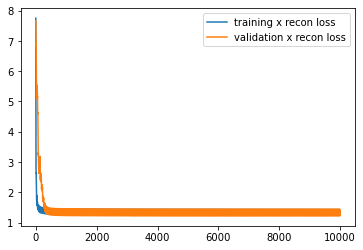

In [9]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_a_ep)
# plt.plot(np.arange(epochs),val_loss_a_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,15))
# plt.xlim((0,3000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [14]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(loss[:3280])
np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[1040]

(array([], dtype=int64),)

In [10]:
testepoch=9990
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv and (s in list(sampleLabellist_ae.keys())):
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 2.5608 loss_x_test: 1.4535 loss_a_test: 1.1073
control13
test results loss_test: 2.2175 loss_x_test: 1.3478 loss_a_test: 0.8697
disease8
test results loss_test: 3.0548 loss_x_test: 1.2328 loss_a_test: 1.8219
control8
test results loss_test: 3.7178 loss_x_test: 1.3820 loss_a_test: 2.3358


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [1]:
# model.pi.weight[:8,:8]
model_str

NameError: name 'model_str' is not defined